In [1]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt

In [2]:
import os
from pathlib import Path
p = Path('~/data_augmentation/CNN')
os.chdir(p.expanduser())

In [10]:
# file_name = './CWoLa_Hunting_Hidden_Valley_training_results.csv'
file_name = './CWoLa_Hunting_Hidden_Valley_training_results-4.csv'
# file_name = './CWoLa_Hunting_Hidden_Valley_training_results-3.csv'
df = pd.read_csv(file_name)

In [4]:
def realistic_sensitivity(S, B):
    sigma = np.where(S > 0, 
                 np.sqrt(2 * (S + B) * np.log(1 + S/B) - 2 * S), 
                 -np.sqrt(2 * (S + B) * np.log(1 + S/B) - 2 * S))
    return sigma


def convert_to_realistic_sensitivity(sensitivity, nB=136.1*139):
    nS = sensitivity * nB**0.5
    return realistic_sensitivity(nS, nB)


def simple_sensitivity(S, B):
    return S / np.sqrt(B)

In [5]:
# cross-section x luminosity

n_bkg_in_SR = 136.1 * 139


def get_realistic_sensitivity_and_std(model_name_format, sensitivity_range=range(11), s=slice(-10, None), filter_condition=None):
    # sensitivities after CWoLa selection with different background efficiencies 10%, 1%, 0.1%
    sensitivities = [[], [], []]
    stds = [[], [], []]

    # Apply filter condition if provided
    if filter_condition is not None:
        filtered_df = df.query(filter_condition)
    else:
        filtered_df = df

    for i in sensitivity_range:
        model_name = model_name_format.format(i)
        # compute mean value and standard deviation of realistic sensitivity
        for j, fpr in enumerate([0.1, 0.01, 0.001]):
            scale_factor = filtered_df[filtered_df['Model Name'] == model_name][f'TPR/FPR^0.5: FPR={fpr}'][s]
            real_sensitivities = convert_to_realistic_sensitivity(i * scale_factor, nB=n_bkg_in_SR * fpr)
            sensitivities[j].append(real_sensitivities.mean())
            stds[j].append(real_sensitivities.std())

    return sensitivities, stds

def get_realistic_sensitivity_and_std_bkg_subtraction(model_name_format, sensitivity_range=range(11), s=slice(-10, None), filter_condition=None):
    # sensitivities after CWoLa selection with different background efficiencies 10%, 1%, 0.1%
    sensitivities = [[], [], []]
    stds = [[], [], []]

    # Apply filter condition if provided
    if filter_condition is not None:
        filtered_df = df.query(filter_condition)
    else:
        filtered_df = df

    for i in sensitivity_range:
        model_name = model_name_format.format(i)
        # compute mean value and standard deviation of realistic sensitivity
        for j, fpr in enumerate([0.1, 0.01, 0.001]):
            train_S = filtered_df[filtered_df['Model Name'] == model_name][f'Train SR signal pass: Test FPR={fpr}'][s]
            train_B = filtered_df[filtered_df['Model Name'] == model_name][f'Train SR background pass: Test FPR={fpr}'][s]
            test_B = filtered_df[filtered_df['Model Name'] == model_name][f'Test SR background pass: Test FPR={fpr}'][s]

            nS = train_S + train_B - test_B
            nB = test_B

            real_sensitivities = realistic_sensitivity(nS, nB)
            # only keep non-nan values
            real_sensitivities = real_sensitivities[~np.isnan(real_sensitivities)]
            sensitivities[j].append(real_sensitivities.mean())
            stds[j].append(real_sensitivities.std())

    return sensitivities, stds


def get_realistic_sensitivity_and_std_bkg_subtraction_from_models(model_names, sensitivity, s=slice(-10, None)):
    # sensitivities after CWoLa selection with different background efficiencies 10%, 1%, 0.1%
    sensitivities = [[], [], []]
    stds = [[], [], []]

    for model_name in model_names:
        # compute mean value and standard deviation of realistic sensitivity
        for j, fpr in enumerate([0.1, 0.01, 0.001]):
            train_S = df[df['Model Name'] == model_name][f'Train SR signal pass: Test FPR={fpr}'][s]
            train_B = df[df['Model Name'] == model_name][f'Train SR background pass: Test FPR={fpr}'][s]
            test_B = df[df['Model Name'] == model_name][f'Test SR background pass: Test FPR={fpr}'][s]

            nS = train_S + train_B - test_B
            nB = test_B

            real_sensitivities = realistic_sensitivity(nS, nB)
            sensitivities[j].append(real_sensitivities.mean())
            stds[j].append(real_sensitivities.std())

    return sensitivities, stds


def get_train_test_event_numbers(model_name_format, sensitivity_range=range(11), s=slice(-10, None)):
    # sensitivities after CWoLa selection with different background efficiencies 10%, 1%, 0.1%
    n_train_S = [[], [], []]
    n_train_B = [[], [], []]
    n_test_B = [[], [], []]


    for i in sensitivity_range:
        model_name = model_name_format.format(i)
        # compute mean value and standard deviation of realistic sensitivity
        for j, fpr in enumerate([0.1, 0.01, 0.001]):
            train_S = df[df['Model Name'] == model_name][f'Train SR signal pass: Test FPR={fpr}'][s]
            train_B = df[df['Model Name'] == model_name][f'Train SR background pass: Test FPR={fpr}'][s]
            test_B = df[df['Model Name'] == model_name][f'Test SR background pass: Test FPR={fpr}'][s]

            # only keep non-zero values for test_B and the corresponding train_S and train_B
            train_S = train_S[test_B > 0]
            train_B = train_B[test_B > 0]
            test_B = test_B[test_B > 0]

            n_train_S[j].append([train_S.mean(), train_S.std()])
            n_train_B[j].append([train_B.mean(), train_B.std()])
            n_test_B[j].append([test_B.mean(), test_B.std()])

    return np.array(n_train_S), np.array(n_train_B), np.array(n_test_B)


def get_train_test_event_numbers_from_models(model_names, sensitivity, s=slice(-10, None)):
    # sensitivities after CWoLa selection with different background efficiencies 10%, 1%, 0.1%
    n_train_S = [[], [], []]
    n_train_B = [[], [], []]
    n_test_B = [[], [], []]

    for model_name in model_names:
        # compute mean value and standard deviation of realistic sensitivity
        for j, fpr in enumerate([0.1, 0.01, 0.001]):
            train_S = df[df['Model Name'] == model_name][f'Train SR signal pass: Test FPR={fpr}'][s]
            train_B = df[df['Model Name'] == model_name][f'Train SR background pass: Test FPR={fpr}'][s]
            test_B = df[df['Model Name'] == model_name][f'Test SR background pass: Test FPR={fpr}'][s]
            
            n_train_S[j].append([train_S.mean(), train_S.std()])
            n_train_B[j].append([train_B.mean(), train_B.std()])
            n_test_B[j].append([test_B.mean(), test_B.std()])

    return np.array(n_train_S), np.array(n_train_B), np.array(n_test_B)


def get_realistic_sensitivity_and_std_true(model_name_format, sensitivity_range=range(11), s=slice(-10, None)):
    # sensitivities after CWoLa selection with different background efficiencies 10%, 1%, 0.1%
    sensitivities = [[], [], []]
    stds = [[], [], []]

    for i in sensitivity_range:
        model_name = model_name_format.format(i)
        # compute mean value and standard deviation of realistic sensitivity
        for j, fpr in enumerate([0.1, 0.01, 0.001]):
            train_S = df[df['Model Name'] == model_name][f'Train SR signal pass: Test FPR={fpr}'][s]
            train_B = df[df['Model Name'] == model_name][f'Train SR background pass: Test FPR={fpr}'][s]
            test_B = df[df['Model Name'] == model_name][f'Test SR background pass: Test FPR={fpr}'][s]

            nS = train_S 
            nB = train_B

            real_sensitivities = realistic_sensitivity(nS, nB)
            sensitivities[j].append(real_sensitivities.mean())
            stds[j].append(real_sensitivities.std())

    return sensitivities, stds


def get_realistic_sensitivity_and_std_from_models(model_names, model_sensitivities, s=slice(-10, None)):
    # sensitivities after CWoLa selection with different background efficiencies 10%, 1%, 0.1%
    sensitivities = [[], [], []]
    stds = [[], [], []]

    # for model_name in model_names:
    for i, model_name in enumerate(model_names):
        # compute mean value and standard deviation of realistic sensitivity
        sensitivity = model_sensitivities[i]
        for j, fpr in enumerate([0.1, 0.01, 0.001]):
            scale_factor = df[df['Model Name'] == model_name][f'TPR/FPR^0.5: FPR={fpr}'][s]
            real_sensitivities = convert_to_realistic_sensitivity(sensitivity * scale_factor, nB=n_bkg_in_SR * fpr)
            sensitivities[j].append(real_sensitivities.mean())
            stds[j].append(real_sensitivities.std())

    return sensitivities, stds

def get_average_realistic_sensitivity_and_std(model_name_formats, sensitivity_range=range(11), s=slice(-10, None)):
    # sensitivities after CWoLa selection with different background efficiencies 10%, 1%, 0.1%
    sensitivities = [[], [], []]
    stds = [[], [], []]

    for i in sensitivity_range:
        for j, fpr in enumerate([0.1, 0.01, 0.001]):
            # compute mean value and standard deviation of realistic sensitivity
            real_sensitivities = []
            for model_name_format in model_name_formats:
                model_name = model_name_format.format(i)
            
            
                scale_factor = df[df['Model Name'] == model_name][f'TPR/FPR^0.5: FPR={fpr}'][s]
                real_sensitivities.append(convert_to_realistic_sensitivity(i * scale_factor, nB=n_bkg_in_SR * fpr))
            real_sensitivities = np.concatenate(real_sensitivities)
            sensitivities[j].append(np.mean(real_sensitivities))
            stds[j].append(np.std(real_sensitivities))

    return sensitivities, stds

# Basic 

/tmp/ipykernel_774382/3566785838.py:17: RuntimeWarning: Mean of empty slice.
  sensitivities[j].append(real_sensitivities.mean())
/home/r10222035/.conda/envs/jupyter/lib/python3.8/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/home/r10222035/.conda/envs/jupyter/lib/python3.8/site-packages/numpy/core/_methods.py:269: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/r10222035/.conda/envs/jupyter/lib/python3.8/site-packages/numpy/core/_methods.py:226: RuntimeWarning: invalid value encountered in divide
  arrmean = um.true_divide(arrmean, div, out=arrmean,
/home/r10222035/.conda/envs/jupyter/lib/python3.8/site-packages/numpy/core/_methods.py:261: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/home/r10222035/.conda/envs/jupyter/lib/python3.8/site-packages/numpy/core/_methods.py:45: Run

KeyboardInterrupt: 

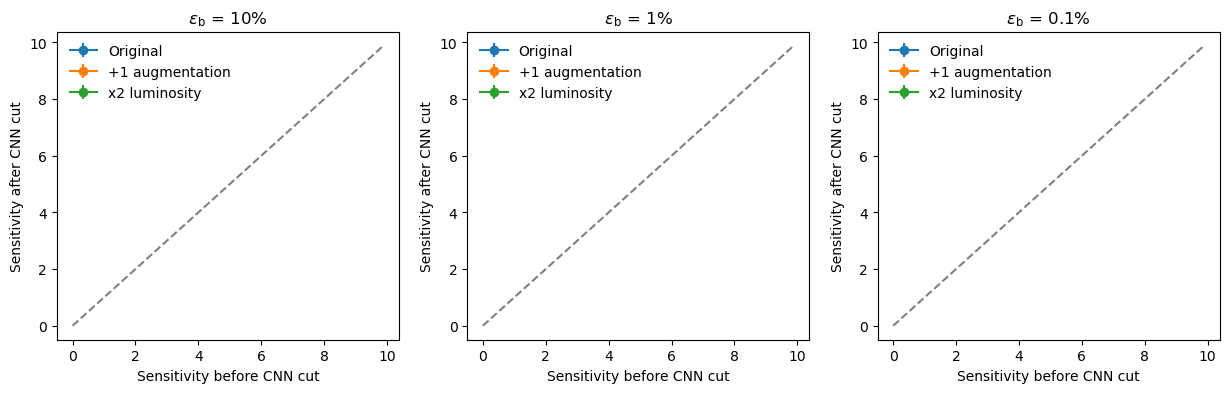

In [5]:
sensitivities_origin_split_val, stds_origin_split_val = get_realistic_sensitivity_and_std('SB_{:.1f}_75x75')
sensitivities_aug_1_split_val, stds_aug_1_split_val = get_realistic_sensitivity_and_std('SB_{:.1f}_aug_1_75x75')
sensitivities_x2_split_val, stds_x2_split_val = get_realistic_sensitivity_and_std('SB_{:.1f}_x2_75x75')

sensitivities = convert_to_realistic_sensitivity(np.arange(11), nB=n_bkg_in_SR)

fig, ax = plt.subplots(1, 3, figsize=(15,4))

titles = ['$\epsilon_\mathrm{b}$ = 10%', '$\epsilon_\mathrm{b}$ = 1%', '$\epsilon_\mathrm{b}$ = 0.1%']
for i in range(3):

    ax[i].errorbar(sensitivities, sensitivities_origin_split_val[i], yerr=stds_origin_split_val[i], marker='o', label='Original')
    ax[i].errorbar(sensitivities, sensitivities_aug_1_split_val[i], yerr=stds_aug_1_split_val[i], marker='o', label='+1 augmentation')
    ax[i].errorbar(sensitivities, sensitivities_x2_split_val[i], yerr=stds_x2_split_val[i], marker='o', label='x2 luminosity')

    ax[i].plot(sensitivities, sensitivities, '--', color='grey')

    ax[i].set_title(titles[i])
    ax[i].set_xlabel('Sensitivity before CNN cut')
    ax[i].set_ylabel('Sensitivity after CNN cut')

    ax[i].legend(frameon=False, loc='upper left')

plt.savefig('../figures/HVmodel_sensitivity_improvement_origin_aug_1_x2_split_val_res_75.pdf', dpi=300, facecolor='White', bbox_inches='tight')
plt.show()

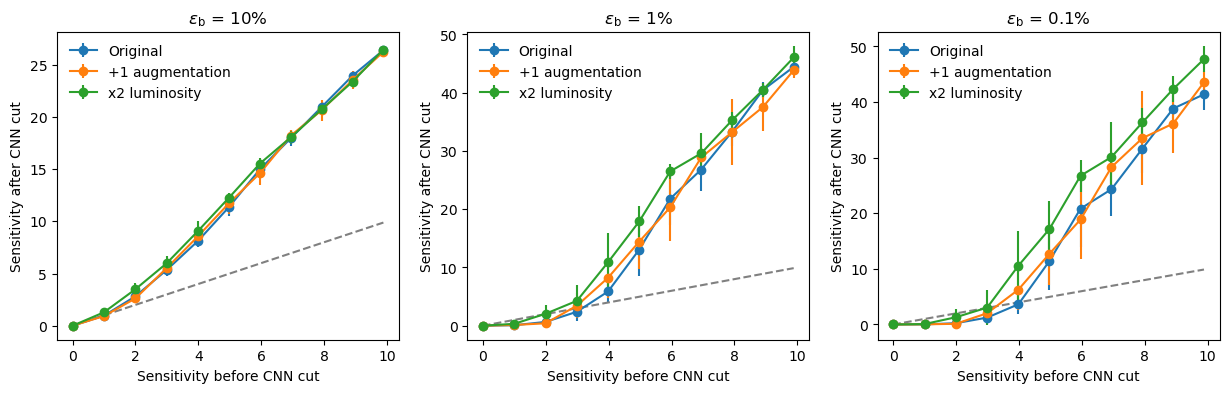

In [ ]:
sensitivities_origin_split_val, stds_origin_split_val = get_realistic_sensitivity_and_std('SB_{:.1f}_25x25')
sensitivities_aug_1_split_val, stds_aug_1_split_val = get_realistic_sensitivity_and_std('SB_{:.1f}_aug_1_25x25')
sensitivities_x2_split_val, stds_x2_split_val = get_realistic_sensitivity_and_std('SB_{:.1f}_x2_25x25')

sensitivities = convert_to_realistic_sensitivity(np.arange(11), nB=n_bkg_in_SR)

fig, ax = plt.subplots(1, 3, figsize=(15,4))

titles = ['$\epsilon_\mathrm{b}$ = 10%', '$\epsilon_\mathrm{b}$ = 1%', '$\epsilon_\mathrm{b}$ = 0.1%']
for i in range(3):

    ax[i].errorbar(sensitivities, sensitivities_origin_split_val[i], yerr=stds_origin_split_val[i], marker='o', label='Original')
    ax[i].errorbar(sensitivities, sensitivities_aug_1_split_val[i], yerr=stds_aug_1_split_val[i], marker='o', label='+1 augmentation')
    ax[i].errorbar(sensitivities, sensitivities_x2_split_val[i], yerr=stds_x2_split_val[i], marker='o', label='x2 luminosity')

    ax[i].plot(sensitivities, sensitivities, '--', color='grey')

    ax[i].set_title(titles[i])
    ax[i].set_xlabel('Sensitivity before CNN cut')
    ax[i].set_ylabel('Sensitivity after CNN cut')

    ax[i].legend(frameon=False, loc='upper left')

plt.savefig('../figures/HVmodel_sensitivity_improvement_origin_aug_1_x2_split_val_res_25.pdf', dpi=300, facecolor='White', bbox_inches='tight')
plt.show()

# Duplicated

/home/r10222035/.conda/envs/jupyter/lib/python3.8/site-packages/numpy/core/_methods.py:45: RuntimeWarning: invalid value encountered in reduce
  return umr_minimum(a, axis, None, out, keepdims, initial, where)
/home/r10222035/.conda/envs/jupyter/lib/python3.8/site-packages/numpy/core/_methods.py:41: RuntimeWarning: invalid value encountered in reduce
  return umr_maximum(a, axis, None, out, keepdims, initial, where)
/home/r10222035/.conda/envs/jupyter/lib/python3.8/site-packages/numpy/core/_methods.py:45: RuntimeWarning: invalid value encountered in reduce
  return umr_minimum(a, axis, None, out, keepdims, initial, where)
/home/r10222035/.conda/envs/jupyter/lib/python3.8/site-packages/numpy/core/_methods.py:41: RuntimeWarning: invalid value encountered in reduce
  return umr_maximum(a, axis, None, out, keepdims, initial, where)
/home/r10222035/.conda/envs/jupyter/lib/python3.8/site-packages/numpy/core/_methods.py:45: RuntimeWarning: invalid value encountered in reduce
  return umr_mini

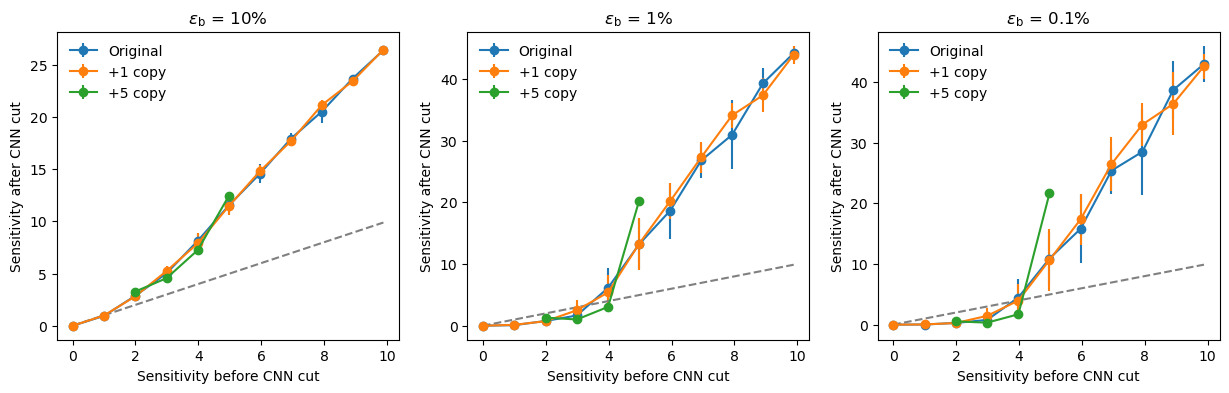

In [ ]:
sensitivities_origin, stds_origin = get_realistic_sensitivity_and_std('SB_{:.1f}_25x25')
sensitivities_copy_1, stds_copy_1 = get_realistic_sensitivity_and_std('SB_{:.1f}_copy_1_25x25')
sensitivities_copy_5, stds_copy_5 = get_realistic_sensitivity_and_std('SB_{:.1f}_copy_5_25x25')

sensitivities = convert_to_realistic_sensitivity(np.arange(11), nB=n_bkg_in_SR)

fig, ax = plt.subplots(1, 3, figsize=(15,4))

titles = ['$\epsilon_\mathrm{b}$ = 10%', '$\epsilon_\mathrm{b}$ = 1%', '$\epsilon_\mathrm{b}$ = 0.1%']
for i in range(3):

    ax[i].errorbar(sensitivities, sensitivities_origin[i], yerr=stds_origin[i], marker='o', label='Original')
    ax[i].errorbar(sensitivities, sensitivities_copy_1[i], yerr=stds_copy_1[i], marker='o', label='+1 copy')
    ax[i].errorbar(sensitivities, sensitivities_copy_5[i], yerr=stds_copy_5[i], marker='o', label='+5 copy')

    ax[i].plot(sensitivities, sensitivities, '--', color='grey')

    ax[i].set_title(titles[i])
    ax[i].set_xlabel('Sensitivity before CNN cut')
    ax[i].set_ylabel('Sensitivity after CNN cut')

    ax[i].legend(frameon=False, loc='upper left')

# plt.savefig('../figures/HVmodel_sensitivity_improvement_origin_aug_1_x2_split_val_res_25.pdf', dpi=300, facecolor='White', bbox_inches='tight')
plt.show()

## Smearing scale

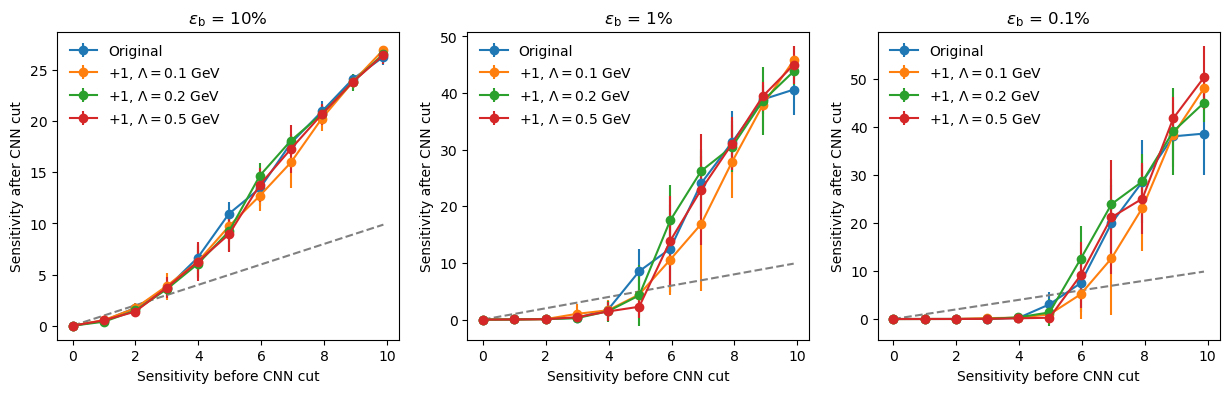

In [ ]:
sensitivities_origin, stds_origin = get_realistic_sensitivity_and_std('SB_{:.1f}_75x75')
sensitivities_01, stds_01 = get_realistic_sensitivity_and_std('SB_{:.1f}_aug_1_75x75')
sensitivities_02, stds_02 = get_realistic_sensitivity_and_std('SB_{:.1f}_aug_1_std_02_75x75')
sensitivities_05, stds_05 = get_realistic_sensitivity_and_std('SB_{:.1f}_aug_1_std_05_75x75')

sensitivities = convert_to_realistic_sensitivity(np.arange(11), nB=n_bkg_in_SR)

fig, ax = plt.subplots(1, 3, figsize=(15,4))

titles = ['$\epsilon_\mathrm{b}$ = 10%', '$\epsilon_\mathrm{b}$ = 1%', '$\epsilon_\mathrm{b}$ = 0.1%']
for i in range(3):

    ax[i].errorbar(sensitivities, sensitivities_origin[i], yerr=stds_origin[i], marker='o', label='Original')
    ax[i].errorbar(sensitivities, sensitivities_01[i], yerr=stds_01[i], marker='o', label='+1, $\Lambda=0.1$ GeV')
    ax[i].errorbar(sensitivities, sensitivities_02[i], yerr=stds_02[i], marker='o', label='+1, $\Lambda=0.2$ GeV')
    ax[i].errorbar(sensitivities, sensitivities_05[i], yerr=stds_05[i], marker='o', label='+1, $\Lambda=0.5$ GeV')

    ax[i].plot(sensitivities, sensitivities, '--', color='grey')

    ax[i].set_title(titles[i])
    ax[i].set_xlabel('Sensitivity before CNN cut')
    ax[i].set_ylabel('Sensitivity after CNN cut')

    ax[i].legend(frameon=False, loc='upper left')

plt.savefig('../figures/HVmodel_sensitivity_improvement_aug_1_std_01_02_05_res_75.pdf', dpi=300, facecolor='White', bbox_inches='tight')
plt.show()

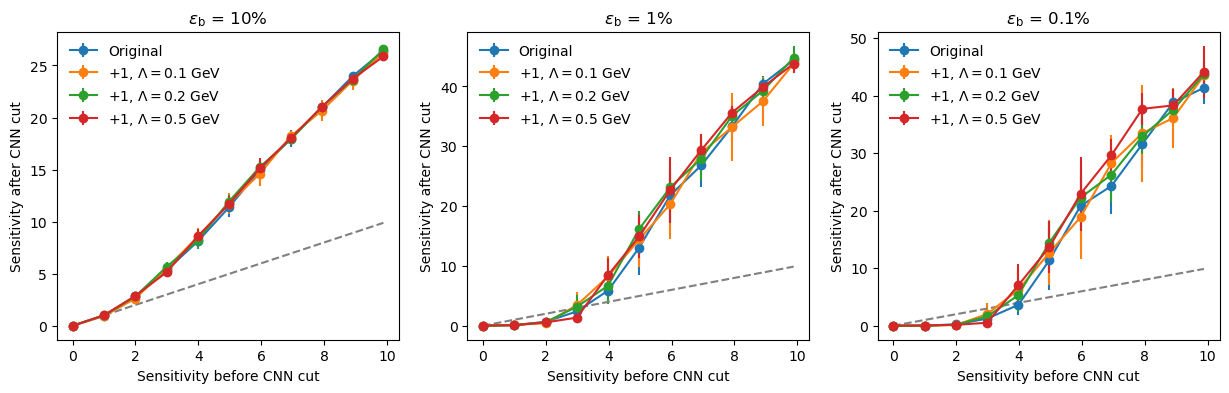

In [ ]:
sensitivities_origin, stds_origin = get_realistic_sensitivity_and_std('SB_{:.1f}_25x25')
sensitivities_01, stds_01 = get_realistic_sensitivity_and_std('SB_{:.1f}_aug_1_25x25')
sensitivities_02, stds_02 = get_realistic_sensitivity_and_std('SB_{:.1f}_aug_1_std_02_25x25')
sensitivities_05, stds_05 = get_realistic_sensitivity_and_std('SB_{:.1f}_aug_1_std_05_25x25')

sensitivities = convert_to_realistic_sensitivity(np.arange(11), nB=n_bkg_in_SR)

fig, ax = plt.subplots(1, 3, figsize=(15,4))

titles = ['$\epsilon_\mathrm{b}$ = 10%', '$\epsilon_\mathrm{b}$ = 1%', '$\epsilon_\mathrm{b}$ = 0.1%']
for i in range(3):

    ax[i].errorbar(sensitivities, sensitivities_origin[i], yerr=stds_origin[i], marker='o', label='Original')
    ax[i].errorbar(sensitivities, sensitivities_01[i], yerr=stds_01[i], marker='o', label='+1, $\Lambda=0.1$ GeV')
    ax[i].errorbar(sensitivities, sensitivities_02[i], yerr=stds_02[i], marker='o', label='+1, $\Lambda=0.2$ GeV')
    ax[i].errorbar(sensitivities, sensitivities_05[i], yerr=stds_05[i], marker='o', label='+1, $\Lambda=0.5$ GeV')

    ax[i].plot(sensitivities, sensitivities, '--', color='grey')

    ax[i].set_title(titles[i])
    ax[i].set_xlabel('Sensitivity before CNN cut')
    ax[i].set_ylabel('Sensitivity after CNN cut')

    ax[i].legend(frameon=False, loc='upper left')

plt.savefig('../figures/HVmodel_sensitivity_improvement_aug_1_std_01_02_05_res_25.pdf', dpi=300, facecolor='White', bbox_inches='tight')
plt.show()

## $p_\text{T}$ smearing

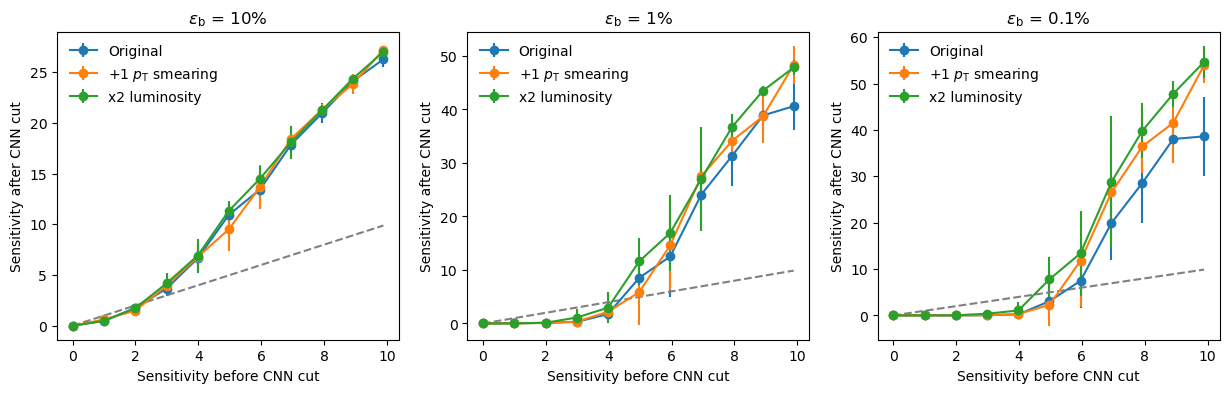

In [ ]:
sensitivities_origin, stds_origin = get_realistic_sensitivity_and_std('SB_{:.1f}_75x75')
sensitivities_aug, stds_aug = get_realistic_sensitivity_and_std('SB_{:.1f}_pt_aug_1_75x75')
sensitivities_x2, stds_x2 = get_realistic_sensitivity_and_std('SB_{:.1f}_x2_75x75')

sensitivities = convert_to_realistic_sensitivity(np.arange(11), nB=n_bkg_in_SR)

fig, ax = plt.subplots(1, 3, figsize=(15,4))

titles = ['$\epsilon_\mathrm{b}$ = 10%', '$\epsilon_\mathrm{b}$ = 1%', '$\epsilon_\mathrm{b}$ = 0.1%']
for i in range(3):

    ax[i].errorbar(sensitivities, sensitivities_origin[i], yerr=stds_origin[i], marker='o', label='Original')
    ax[i].errorbar(sensitivities, sensitivities_aug[i], yerr=stds_aug[i], marker='o', label='+1 $p_\mathrm{T}$ smearing')
    ax[i].errorbar(sensitivities, sensitivities_x2[i], yerr=stds_x2[i], marker='o', label='x2 luminosity')

    ax[i].plot(sensitivities, sensitivities, '--', color='grey')

    ax[i].set_title(titles[i])
    ax[i].set_xlabel('Sensitivity before CNN cut')
    ax[i].set_ylabel('Sensitivity after CNN cut')

    ax[i].legend(frameon=False, loc='upper left')

plt.savefig('../figures/HVmodel_sensitivity_improvement_origin_pt_aug_1_x2_res_75.pdf', dpi=300, facecolor='White', bbox_inches='tight')
plt.show()

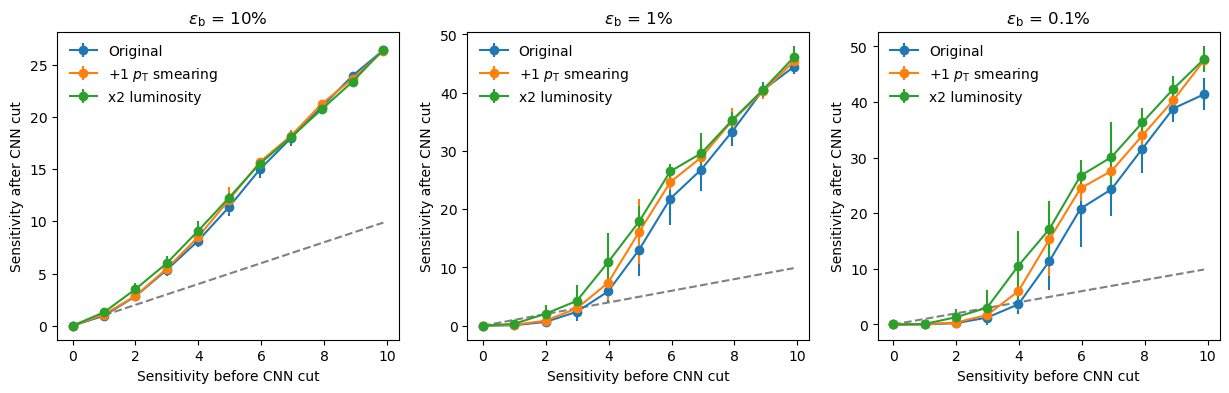

In [ ]:
sensitivities_origin, stds_origin = get_realistic_sensitivity_and_std('SB_{:.1f}_25x25')
sensitivities_aug, stds_aug = get_realistic_sensitivity_and_std('SB_{:.1f}_pt_aug_1_25x25')
sensitivities_x2, stds_x2 = get_realistic_sensitivity_and_std('SB_{:.1f}_x2_25x25')

sensitivities = convert_to_realistic_sensitivity(np.arange(11), nB=n_bkg_in_SR)

fig, ax = plt.subplots(1, 3, figsize=(15,4))

titles = ['$\epsilon_\mathrm{b}$ = 10%', '$\epsilon_\mathrm{b}$ = 1%', '$\epsilon_\mathrm{b}$ = 0.1%']
for i in range(3):

    ax[i].errorbar(sensitivities, sensitivities_origin[i], yerr=stds_origin[i], marker='o', label='Original')
    ax[i].errorbar(sensitivities, sensitivities_aug[i], yerr=stds_aug[i], marker='o', label='+1 $p_\mathrm{T}$ smearing')
    ax[i].errorbar(sensitivities, sensitivities_x2[i], yerr=stds_x2[i], marker='o', label='x2 luminosity')

    ax[i].plot(sensitivities, sensitivities, '--', color='grey')

    ax[i].set_title(titles[i])
    ax[i].set_xlabel('Sensitivity before CNN cut')
    ax[i].set_ylabel('Sensitivity after CNN cut')

    ax[i].legend(frameon=False, loc='upper left')

plt.savefig('../figures/HVmodel_sensitivity_improvement_origin_pt_aug_1_x2_res_25.pdf', dpi=300, facecolor='White', bbox_inches='tight')
plt.show()

## More augmented sample

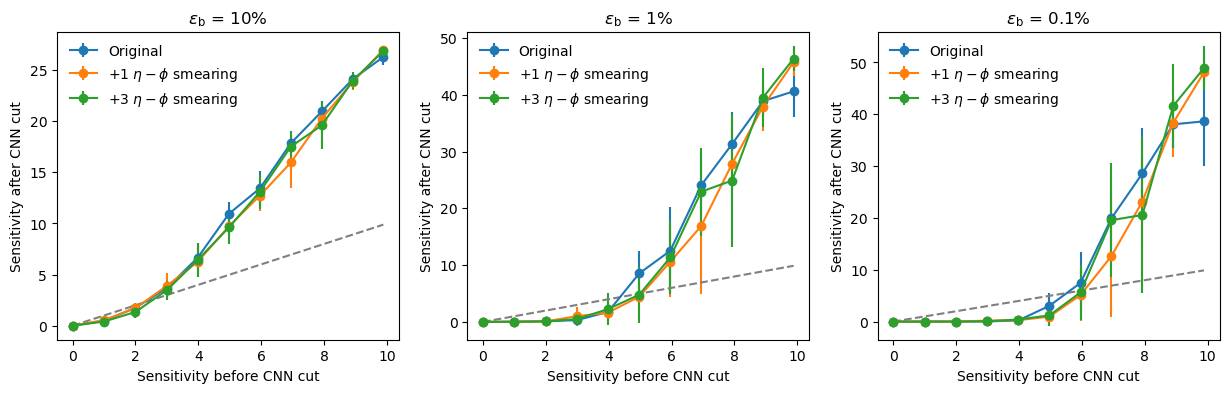

In [ ]:
sensitivities_origin, stds_origin = get_realistic_sensitivity_and_std('SB_{:.1f}_75x75')
sensitivities_aug_1, stds_aug_1 = get_realistic_sensitivity_and_std('SB_{:.1f}_aug_1_75x75')
sensitivities_aug_3, stds_aug_3 = get_realistic_sensitivity_and_std('SB_{:.1f}_aug_3_75x75')

sensitivities = convert_to_realistic_sensitivity(np.arange(11), nB=n_bkg_in_SR)

fig, ax = plt.subplots(1, 3, figsize=(15,4))

titles = ['$\epsilon_\mathrm{b}$ = 10%', '$\epsilon_\mathrm{b}$ = 1%', '$\epsilon_\mathrm{b}$ = 0.1%']
for i in range(3):

    ax[i].errorbar(sensitivities, sensitivities_origin[i], yerr=stds_origin[i], marker='o', label='Original')
    ax[i].errorbar(sensitivities, sensitivities_aug_1[i], yerr=stds_aug_1[i], marker='o', label='+1 $\eta-\phi$ smearing')
    ax[i].errorbar(sensitivities, sensitivities_aug_3[i], yerr=stds_aug_3[i], marker='o', label='+3 $\eta-\phi$ smearing')

    ax[i].plot(sensitivities, sensitivities, '--', color='grey')

    ax[i].set_title(titles[i])
    ax[i].set_xlabel('Sensitivity before CNN cut')
    ax[i].set_ylabel('Sensitivity after CNN cut')

    ax[i].legend(frameon=False, loc='upper left')

plt.savefig('../figures/HVmodel_sensitivity_improvement_origin_eta_phi_aug_1_3_res_75.pdf', dpi=300, facecolor='White', bbox_inches='tight')
plt.show()

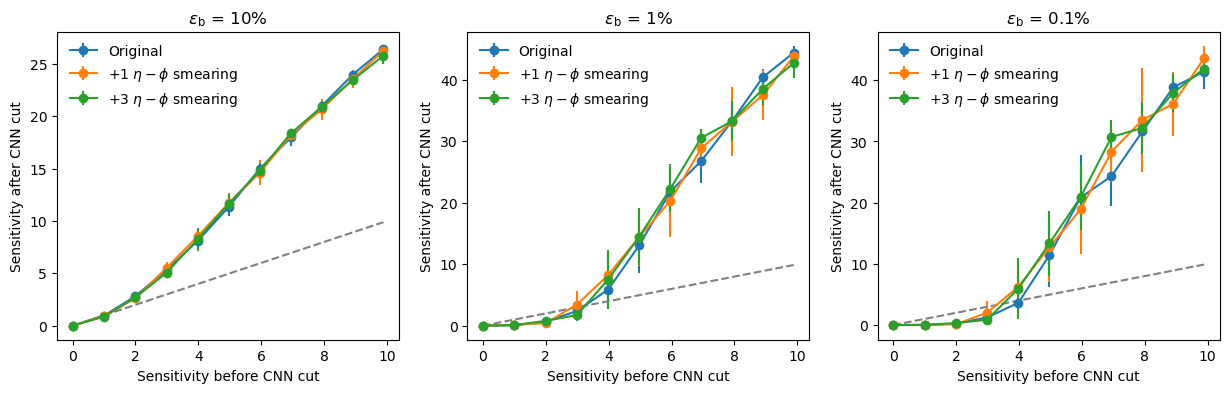

In [ ]:
sensitivities_origin, stds_origin = get_realistic_sensitivity_and_std('SB_{:.1f}_25x25')
sensitivities_aug_1, stds_aug_1 = get_realistic_sensitivity_and_std('SB_{:.1f}_aug_1_25x25')
sensitivities_aug_3, stds_aug_3 = get_realistic_sensitivity_and_std('SB_{:.1f}_aug_3_25x25')

sensitivities = convert_to_realistic_sensitivity(np.arange(11), nB=n_bkg_in_SR)

fig, ax = plt.subplots(1, 3, figsize=(15,4))

titles = ['$\epsilon_\mathrm{b}$ = 10%', '$\epsilon_\mathrm{b}$ = 1%', '$\epsilon_\mathrm{b}$ = 0.1%']
for i in range(3):

    ax[i].errorbar(sensitivities, sensitivities_origin[i], yerr=stds_origin[i], marker='o', label='Original')
    ax[i].errorbar(sensitivities, sensitivities_aug_1[i], yerr=stds_aug_1[i], marker='o', label='+1 $\eta-\phi$ smearing')
    ax[i].errorbar(sensitivities, sensitivities_aug_3[i], yerr=stds_aug_3[i], marker='o', label='+3 $\eta-\phi$ smearing')

    ax[i].plot(sensitivities, sensitivities, '--', color='grey')

    ax[i].set_title(titles[i])
    ax[i].set_xlabel('Sensitivity before CNN cut')
    ax[i].set_ylabel('Sensitivity after CNN cut')

    ax[i].legend(frameon=False, loc='upper left')

plt.savefig('../figures/HVmodel_sensitivity_improvement_origin_eta_phi_aug_1_3_res_25.pdf', dpi=300, facecolor='White', bbox_inches='tight')
plt.show()

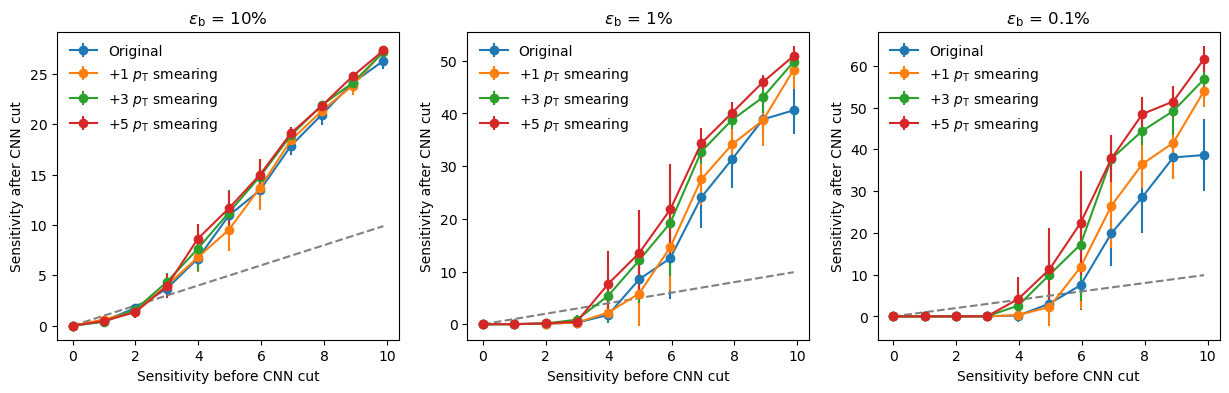

In [ ]:
sensitivities_origin, stds_origin = get_realistic_sensitivity_and_std('SB_{:.1f}_75x75')
sensitivities_aug_1, stds_aug_1 = get_realistic_sensitivity_and_std('SB_{:.1f}_pt_aug_1_75x75')
sensitivities_aug_3, stds_aug_3 = get_realistic_sensitivity_and_std('SB_{:.1f}_pt_aug_3_75x75')
sensitivities_aug_5, stds_aug_5 = get_realistic_sensitivity_and_std('SB_{:.1f}_pt_aug_5_75x75')

sensitivities = convert_to_realistic_sensitivity(np.arange(11), nB=n_bkg_in_SR)

fig, ax = plt.subplots(1, 3, figsize=(15,4))

titles = ['$\epsilon_\mathrm{b}$ = 10%', '$\epsilon_\mathrm{b}$ = 1%', '$\epsilon_\mathrm{b}$ = 0.1%']
for i in range(3):

    ax[i].errorbar(sensitivities, sensitivities_origin[i], yerr=stds_origin[i], marker='o', label='Original')
    ax[i].errorbar(sensitivities, sensitivities_aug_1[i], yerr=stds_aug_1[i], marker='o', label='+1 $p_\mathrm{T}$ smearing')
    ax[i].errorbar(sensitivities, sensitivities_aug_3[i], yerr=stds_aug_3[i], marker='o', label='+3 $p_\mathrm{T}$ smearing')
    ax[i].errorbar(sensitivities, sensitivities_aug_5[i], yerr=stds_aug_5[i], marker='o', label='+5 $p_\mathrm{T}$ smearing')

    ax[i].plot(sensitivities, sensitivities, '--', color='grey')

    ax[i].set_title(titles[i])
    ax[i].set_xlabel('Sensitivity before CNN cut')
    ax[i].set_ylabel('Sensitivity after CNN cut')

    ax[i].legend(frameon=False, loc='upper left')

plt.savefig('../figures/HVmodel_sensitivity_improvement_origin_pt_aug_1_3_5_res_75.pdf', dpi=300, facecolor='White', bbox_inches='tight')
plt.show()

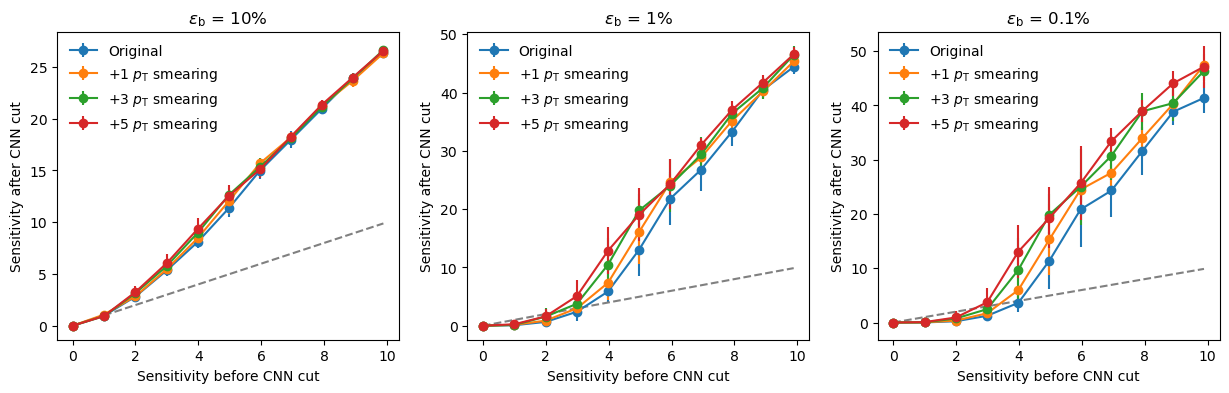

In [ ]:
sensitivities_origin, stds_origin = get_realistic_sensitivity_and_std('SB_{:.1f}_25x25')
sensitivities_aug_1, stds_aug_1 = get_realistic_sensitivity_and_std('SB_{:.1f}_pt_aug_1_25x25')
sensitivities_aug_3, stds_aug_3 = get_realistic_sensitivity_and_std('SB_{:.1f}_pt_aug_3_25x25')
sensitivities_aug_5, stds_aug_5 = get_realistic_sensitivity_and_std('SB_{:.1f}_pt_aug_5_25x25')

sensitivities = convert_to_realistic_sensitivity(np.arange(11), nB=n_bkg_in_SR)

fig, ax = plt.subplots(1, 3, figsize=(15,4))

titles = ['$\epsilon_\mathrm{b}$ = 10%', '$\epsilon_\mathrm{b}$ = 1%', '$\epsilon_\mathrm{b}$ = 0.1%']
for i in range(3):

    ax[i].errorbar(sensitivities, sensitivities_origin[i], yerr=stds_origin[i], marker='o', label='Original')
    ax[i].errorbar(sensitivities, sensitivities_aug_1[i], yerr=stds_aug_1[i], marker='o', label='+1 $p_\mathrm{T}$ smearing')
    ax[i].errorbar(sensitivities, sensitivities_aug_3[i], yerr=stds_aug_3[i], marker='o', label='+3 $p_\mathrm{T}$ smearing')
    ax[i].errorbar(sensitivities, sensitivities_aug_5[i], yerr=stds_aug_5[i], marker='o', label='+5 $p_\mathrm{T}$ smearing')

    ax[i].plot(sensitivities, sensitivities, '--', color='grey')

    ax[i].set_title(titles[i])
    ax[i].set_xlabel('Sensitivity before CNN cut')
    ax[i].set_ylabel('Sensitivity after CNN cut')

    ax[i].legend(frameon=False, loc='upper left')

plt.savefig('../figures/HVmodel_sensitivity_improvement_origin_pt_aug_1_3_5_res_25.pdf', dpi=300, facecolor='White', bbox_inches='tight')
plt.show()

# $\eta-\phi$ + $p_\text{T}$ smearing

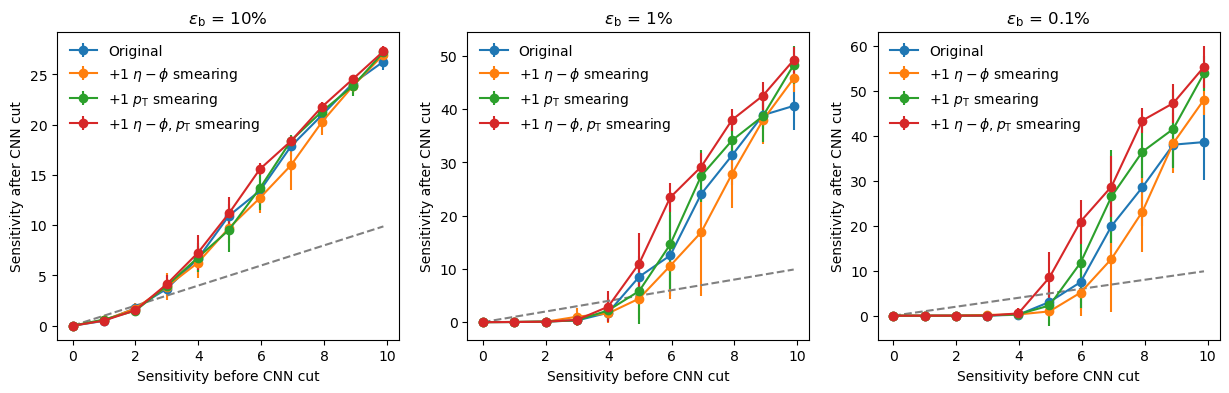

In [ ]:
sensitivities_origin, stds_origin = get_realistic_sensitivity_and_std('SB_{:.1f}_75x75')
sensitivities_eta_phi_aug_1, stds_eta_phi_aug_1 = get_realistic_sensitivity_and_std('SB_{:.1f}_aug_1_75x75')
sensitivities_pt_aug_1, stds_pt_aug_1 = get_realistic_sensitivity_and_std('SB_{:.1f}_pt_aug_1_75x75')
sensitivities_all_aug_1, stds_all_aug_1 = get_realistic_sensitivity_and_std('SB_{:.1f}_eta_phi_pt_aug_1_75x75')

sensitivities = convert_to_realistic_sensitivity(np.arange(11), nB=n_bkg_in_SR)

fig, ax = plt.subplots(1, 3, figsize=(15,4))

titles = ['$\epsilon_\mathrm{b}$ = 10%', '$\epsilon_\mathrm{b}$ = 1%', '$\epsilon_\mathrm{b}$ = 0.1%']
for i in range(3):

    ax[i].errorbar(sensitivities, sensitivities_origin[i], yerr=stds_origin[i], marker='o', label='Original')
    ax[i].errorbar(sensitivities, sensitivities_eta_phi_aug_1[i], yerr=stds_eta_phi_aug_1[i], marker='o', label='+1 $\eta-\phi$ smearing')
    ax[i].errorbar(sensitivities, sensitivities_pt_aug_1[i], yerr=stds_pt_aug_1[i], marker='o', label='+1 $p_\mathrm{T}$ smearing')
    ax[i].errorbar(sensitivities, sensitivities_all_aug_1[i], yerr=stds_all_aug_1[i], marker='o', label='+1 $\eta-\phi, p_\mathrm{T}$ smearing')

    ax[i].plot(sensitivities, sensitivities, '--', color='grey')

    ax[i].set_title(titles[i])
    ax[i].set_xlabel('Sensitivity before CNN cut')
    ax[i].set_ylabel('Sensitivity after CNN cut')

    ax[i].legend(frameon=False, loc='upper left')

plt.savefig('../figures/HVmodel_sensitivity_improvement_origin_eta_phi_pt_aug_1_res_75.pdf', dpi=300, facecolor='White', bbox_inches='tight')
plt.show()

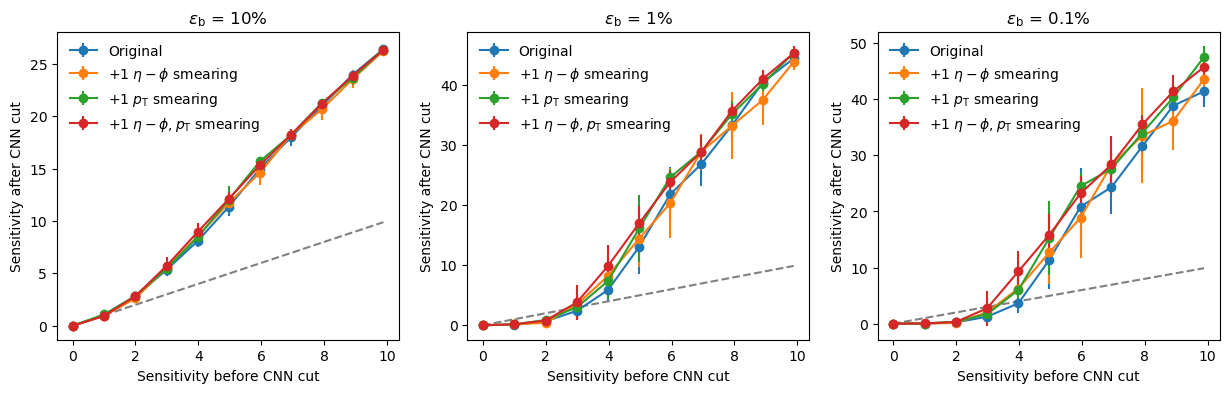

In [ ]:
sensitivities_origin, stds_origin = get_realistic_sensitivity_and_std('SB_{:.1f}_25x25')
sensitivities_eta_phi_aug_1, stds_eta_phi_aug_1 = get_realistic_sensitivity_and_std('SB_{:.1f}_aug_1_25x25')
sensitivities_pt_aug_1, stds_pt_aug_1 = get_realistic_sensitivity_and_std('SB_{:.1f}_pt_aug_1_25x25')
sensitivities_all_aug_1, stds_all_aug_1 = get_realistic_sensitivity_and_std('SB_{:.1f}_eta_phi_pt_aug_1_25x25')

sensitivities = convert_to_realistic_sensitivity(np.arange(11), nB=n_bkg_in_SR)

fig, ax = plt.subplots(1, 3, figsize=(15,4))

titles = ['$\epsilon_\mathrm{b}$ = 10%', '$\epsilon_\mathrm{b}$ = 1%', '$\epsilon_\mathrm{b}$ = 0.1%']
for i in range(3):

    ax[i].errorbar(sensitivities, sensitivities_origin[i], yerr=stds_origin[i], marker='o', label='Original')
    ax[i].errorbar(sensitivities, sensitivities_eta_phi_aug_1[i], yerr=stds_eta_phi_aug_1[i], marker='o', label='+1 $\eta-\phi$ smearing')
    ax[i].errorbar(sensitivities, sensitivities_pt_aug_1[i], yerr=stds_pt_aug_1[i], marker='o', label='+1 $p_\mathrm{T}$ smearing')
    ax[i].errorbar(sensitivities, sensitivities_all_aug_1[i], yerr=stds_all_aug_1[i], marker='o', label='+1 $\eta-\phi, p_\mathrm{T}$ smearing')

    ax[i].plot(sensitivities, sensitivities, '--', color='grey')

    ax[i].set_title(titles[i])
    ax[i].set_xlabel('Sensitivity before CNN cut')
    ax[i].set_ylabel('Sensitivity after CNN cut')

    ax[i].legend(frameon=False, loc='upper left')

plt.savefig('../figures/HVmodel_sensitivity_improvement_origin_eta_phi_pt_aug_1_res_25.pdf', dpi=300, facecolor='White', bbox_inches='tight')
plt.show()

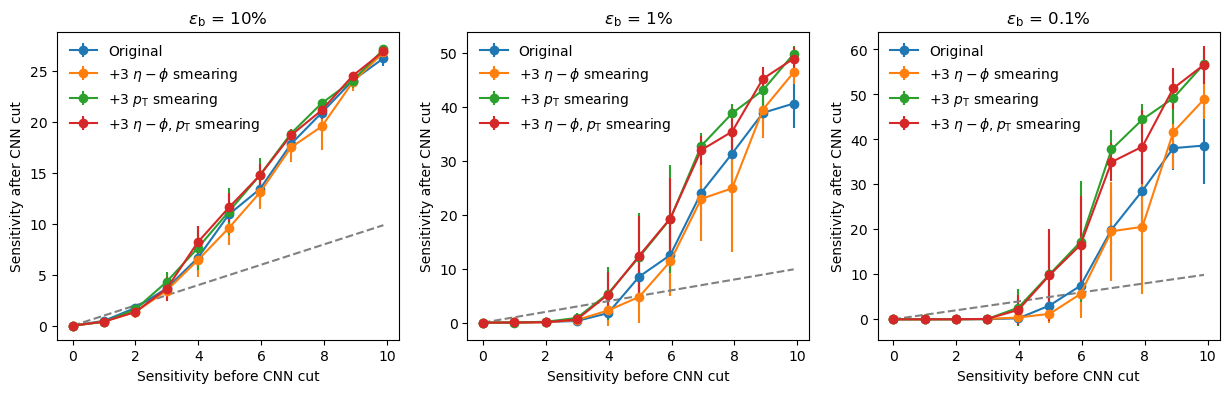

In [ ]:
sensitivities_origin, stds_origin = get_realistic_sensitivity_and_std('SB_{:.1f}_75x75')
sensitivities_eta_phi_aug_3, stds_eta_phi_aug_3 = get_realistic_sensitivity_and_std('SB_{:.1f}_aug_3_75x75')
sensitivities_pt_aug_3, stds_pt_aug_3 = get_realistic_sensitivity_and_std('SB_{:.1f}_pt_aug_3_75x75')
sensitivities_all_aug_3, stds_all_aug_3 = get_realistic_sensitivity_and_std('SB_{:.1f}_eta_phi_pt_aug_3_75x75')

sensitivities = convert_to_realistic_sensitivity(np.arange(11), nB=n_bkg_in_SR)

fig, ax = plt.subplots(1, 3, figsize=(15,4))

titles = ['$\epsilon_\mathrm{b}$ = 10%', '$\epsilon_\mathrm{b}$ = 1%', '$\epsilon_\mathrm{b}$ = 0.1%']
for i in range(3):

    ax[i].errorbar(sensitivities, sensitivities_origin[i], yerr=stds_origin[i], marker='o', label='Original')
    ax[i].errorbar(sensitivities, sensitivities_eta_phi_aug_3[i], yerr=stds_eta_phi_aug_3[i], marker='o', label='+3 $\eta-\phi$ smearing')
    ax[i].errorbar(sensitivities, sensitivities_pt_aug_3[i], yerr=stds_pt_aug_3[i], marker='o', label='+3 $p_\mathrm{T}$ smearing')
    ax[i].errorbar(sensitivities, sensitivities_all_aug_3[i], yerr=stds_all_aug_3[i], marker='o', label='+3 $\eta-\phi, p_\mathrm{T}$ smearing')

    ax[i].plot(sensitivities, sensitivities, '--', color='grey')

    ax[i].set_title(titles[i])
    ax[i].set_xlabel('Sensitivity before CNN cut')
    ax[i].set_ylabel('Sensitivity after CNN cut')

    ax[i].legend(frameon=False, loc='upper left')

plt.savefig('../figures/HVmodel_sensitivity_improvement_origin_eta_phi_pt_aug_3_res_75.pdf', dpi=300, facecolor='White', bbox_inches='tight')
plt.show()

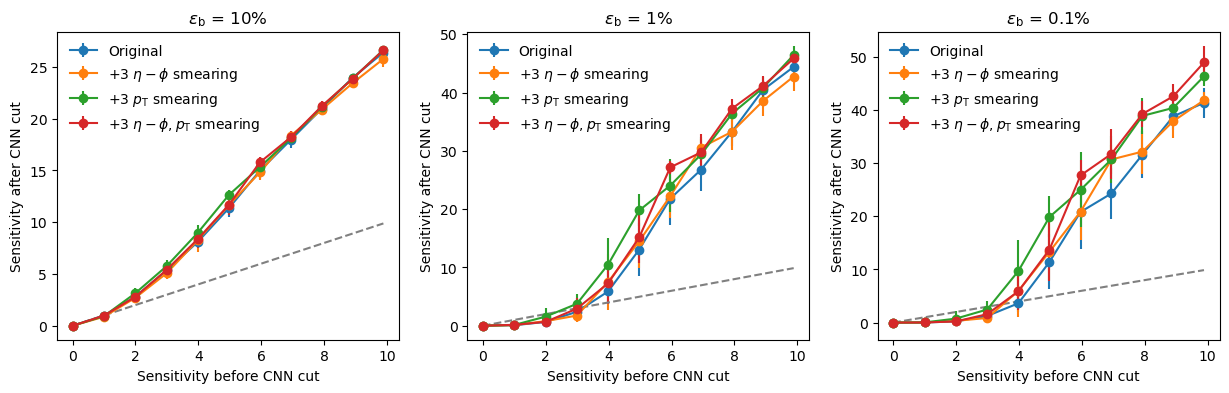

In [ ]:
sensitivities_origin, stds_origin = get_realistic_sensitivity_and_std('SB_{:.1f}_25x25')
sensitivities_eta_phi_aug_3, stds_eta_phi_aug_3 = get_realistic_sensitivity_and_std('SB_{:.1f}_aug_3_25x25')
sensitivities_pt_aug_3, stds_pt_aug_3 = get_realistic_sensitivity_and_std('SB_{:.1f}_pt_aug_3_25x25')
sensitivities_all_aug_3, stds_all_aug_3 = get_realistic_sensitivity_and_std('SB_{:.1f}_eta_phi_pt_aug_3_25x25')

sensitivities = convert_to_realistic_sensitivity(np.arange(11), nB=n_bkg_in_SR)

fig, ax = plt.subplots(1, 3, figsize=(15,4))

titles = ['$\epsilon_\mathrm{b}$ = 10%', '$\epsilon_\mathrm{b}$ = 1%', '$\epsilon_\mathrm{b}$ = 0.1%']
for i in range(3):

    ax[i].errorbar(sensitivities, sensitivities_origin[i], yerr=stds_origin[i], marker='o', label='Original')
    ax[i].errorbar(sensitivities, sensitivities_eta_phi_aug_3[i], yerr=stds_eta_phi_aug_3[i], marker='o', label='+3 $\eta-\phi$ smearing')
    ax[i].errorbar(sensitivities, sensitivities_pt_aug_3[i], yerr=stds_pt_aug_3[i], marker='o', label='+3 $p_\mathrm{T}$ smearing')
    ax[i].errorbar(sensitivities, sensitivities_all_aug_3[i], yerr=stds_all_aug_3[i], marker='o', label='+3 $\eta-\phi, p_\mathrm{T}$ smearing')

    ax[i].plot(sensitivities, sensitivities, '--', color='grey')

    ax[i].set_title(titles[i])
    ax[i].set_xlabel('Sensitivity before CNN cut')
    ax[i].set_ylabel('Sensitivity after CNN cut')

    ax[i].legend(frameon=False, loc='upper left')

plt.savefig('../figures/HVmodel_sensitivity_improvement_origin_eta_phi_pt_aug_3_res_25.pdf', dpi=300, facecolor='White', bbox_inches='tight')
plt.show()

## Jet rotation

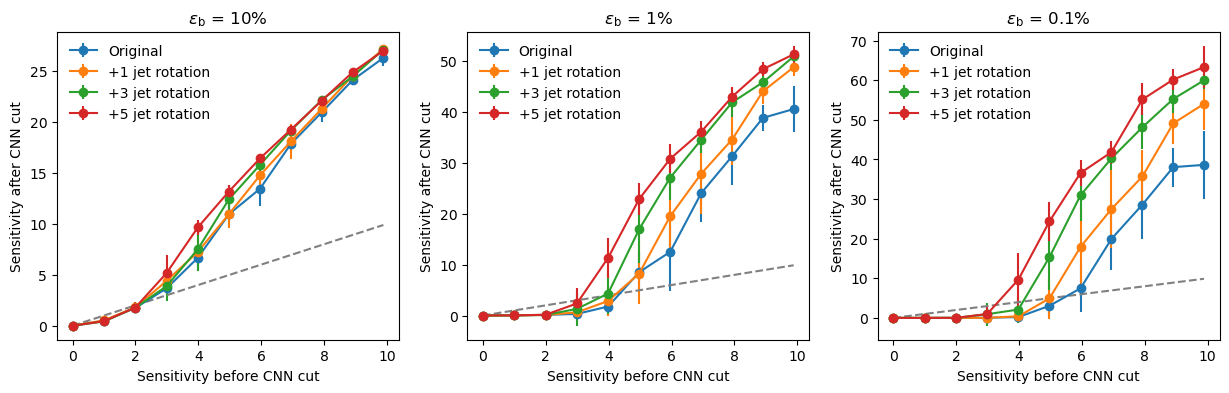

In [ ]:
sensitivities_origin, stds_origin = get_realistic_sensitivity_and_std('SB_{:.1f}_75x75')
sensitivities_jet_aug_1, stds_jet_aug_1 = get_realistic_sensitivity_and_std('SB_{:.1f}_jet_aug_1_75x75')
sensitivities_jet_aug_3, stds_jet_aug_3 = get_realistic_sensitivity_and_std('SB_{:.1f}_jet_aug_3_75x75')
sensitivities_jet_aug_5, stds_jet_aug_5 = get_realistic_sensitivity_and_std('SB_{:.1f}_jet_aug_5_75x75')

sensitivities = convert_to_realistic_sensitivity(np.arange(11), nB=n_bkg_in_SR)

fig, ax = plt.subplots(1, 3, figsize=(15, 4))

titles = ['$\epsilon_\mathrm{b}$ = 10%', '$\epsilon_\mathrm{b}$ = 1%', '$\epsilon_\mathrm{b}$ = 0.1%']
for i in range(3):

    ax[i].errorbar(sensitivities, sensitivities_origin[i], yerr=stds_origin[i], marker='o', label='Original')
    ax[i].errorbar(sensitivities, sensitivities_jet_aug_1[i], yerr=stds_jet_aug_1[i], marker='o', label='+1 jet rotation')
    ax[i].errorbar(sensitivities, sensitivities_jet_aug_3[i], yerr=stds_jet_aug_3[i], marker='o', label='+3 jet rotation')
    ax[i].errorbar(sensitivities, sensitivities_jet_aug_5[i], yerr=stds_jet_aug_5[i], marker='o', label='+5 jet rotation')

    ax[i].plot(sensitivities, sensitivities, '--', color='grey')

    ax[i].set_title(titles[i])
    ax[i].set_xlabel('Sensitivity before CNN cut')
    ax[i].set_ylabel('Sensitivity after CNN cut')

    ax[i].legend(frameon=False, loc='upper left')

plt.savefig('../figures/HVmodel_sensitivity_improvement_origin_jet_aug_1_3_5_res_75.pdf', dpi=300, facecolor='White', bbox_inches='tight')
plt.show()

(3, 11)


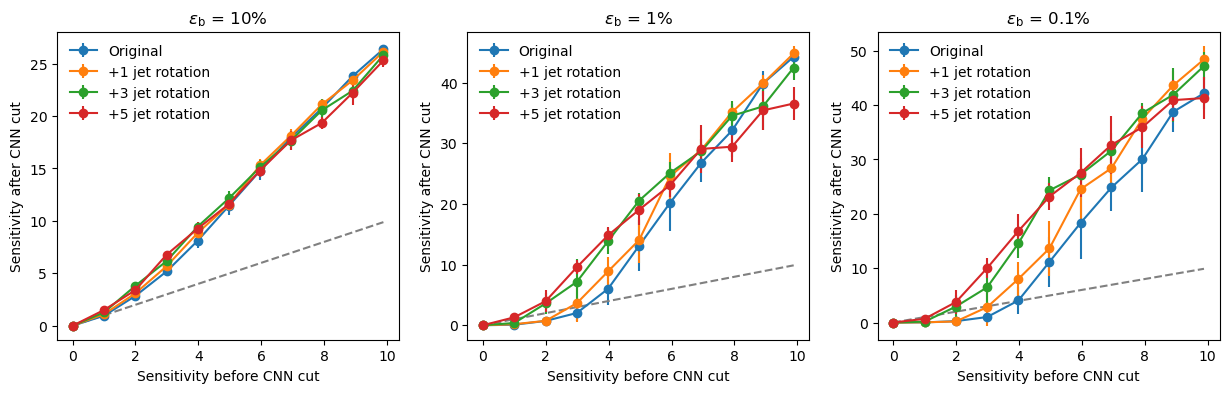

In [ ]:
sensitivities_origin, stds_origin = get_realistic_sensitivity_and_std('SB_{:.1f}_25x25')
sensitivities_jet_aug_1, stds_jet_aug_1 = get_realistic_sensitivity_and_std('SB_{:.1f}_jet_aug_1_25x25')
sensitivities_jet_aug_3, stds_jet_aug_3 = get_realistic_sensitivity_and_std('SB_{:.1f}_jet_aug_3_25x25')
sensitivities_jet_aug_5, stds_jet_aug_5 = get_realistic_sensitivity_and_std('SB_{:.1f}_jet_aug_5_25x25')

sensitivities = convert_to_realistic_sensitivity(np.arange(11), nB=n_bkg_in_SR)

fig, ax = plt.subplots(1, 3, figsize=(15, 4))

titles = ['$\epsilon_\mathrm{b}$ = 10%', '$\epsilon_\mathrm{b}$ = 1%', '$\epsilon_\mathrm{b}$ = 0.1%']
for i in range(3):

    ax[i].errorbar(sensitivities, sensitivities_origin[i], yerr=stds_origin[i], marker='o', label='Original')
    ax[i].errorbar(sensitivities, sensitivities_jet_aug_1[i], yerr=stds_jet_aug_1[i], marker='o', label='+1 jet rotation')
    ax[i].errorbar(sensitivities, sensitivities_jet_aug_3[i], yerr=stds_jet_aug_3[i], marker='o', label='+3 jet rotation')
    ax[i].errorbar(sensitivities, sensitivities_jet_aug_5[i], yerr=stds_jet_aug_5[i], marker='o', label='+5 jet rotation')

    ax[i].plot(sensitivities, sensitivities, '--', color='grey')

    ax[i].set_title(titles[i])
    ax[i].set_xlabel('Sensitivity before CNN cut')
    ax[i].set_ylabel('Sensitivity after CNN cut')

    ax[i].legend(frameon=False, loc='upper left')

plt.savefig('../figures/HVmodel_sensitivity_improvement_origin_jet_aug_1_3_5_res_25.pdf', dpi=300, facecolor='White', bbox_inches='tight')
plt.show()

# Asymptotic behaviour

## Jet rotation

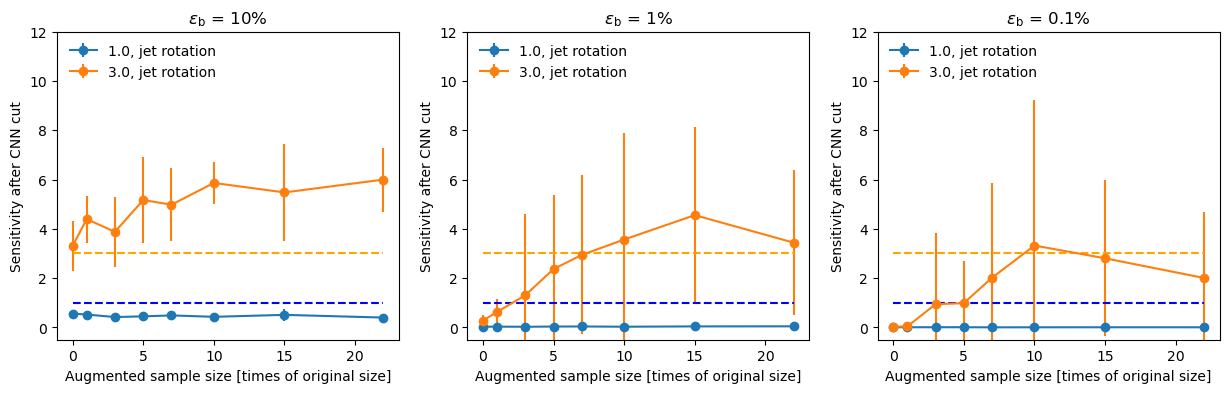

In [ ]:
sample_size = [1, 3, 5, 7, 10, 15, 22]

models = ['SB_1.0_75x75'] + [f'SB_1.0_jet_aug_{n}_75x75' for n in sample_size]
sensitivities_jet_aug_1, stds_jet_aug_1 = get_realistic_sensitivity_and_std_from_models(models, sensitivity=1.0)

models = ['SB_3.0_75x75'] + [f'SB_3.0_jet_aug_{n}_75x75' for n in sample_size]
sensitivities_jet_aug_3, stds_jet_aug_3 = get_realistic_sensitivity_and_std_from_models(models, sensitivity=3.0)

fig, ax = plt.subplots(1, 3, figsize=(15, 4))

titles = ['$\epsilon_\mathrm{b}$ = 10%', '$\epsilon_\mathrm{b}$ = 1%', '$\epsilon_\mathrm{b}$ = 0.1%']
for i in range(3):

    ax[i].errorbar([0] + sample_size, sensitivities_jet_aug_1[i], yerr=stds_jet_aug_1[i], marker='o', label='1.0, jet rotation')
    ax[i].errorbar([0] + sample_size, sensitivities_jet_aug_3[i], yerr=stds_jet_aug_3[i], marker='o', label='3.0, jet rotation')

    ax[i].set_title(titles[i])
    ax[i].hlines(1, 0, 22, color='b', linestyle='--')
    ax[i].hlines(3, 0, 22, color='orange', linestyle='--')
    ax[i].set_ylim(-0.5, 12)
    ax[i].set_xlabel('Augmented sample size [times of original size]')
    ax[i].set_ylabel('Sensitivity after CNN cut')

    ax[i].legend(frameon=False, loc='upper left')

plt.savefig('../figures/HVmodel_sensitivity_improvement_jet_aug_SB_1_3_res_75.pdf', dpi=300, facecolor='White', bbox_inches='tight')
plt.show()

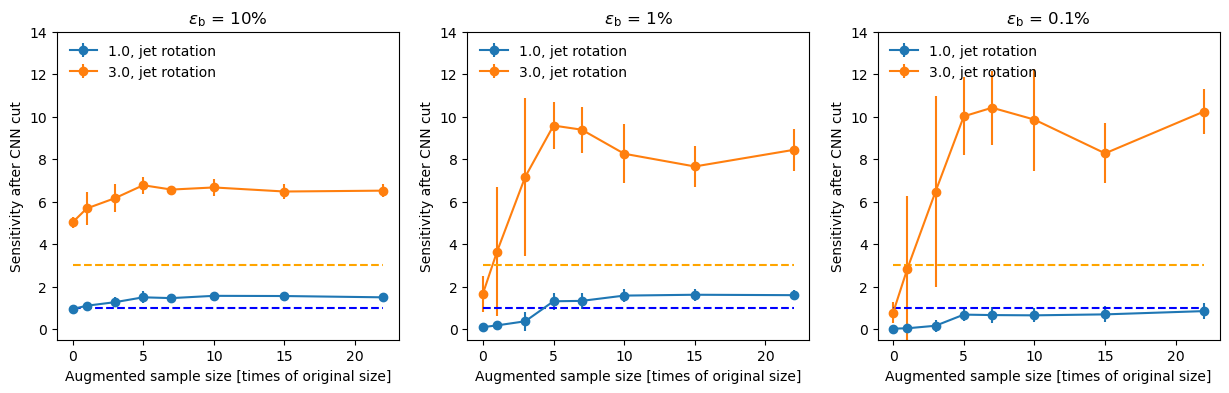

In [ ]:
sample_size = [1, 3, 5, 7, 10, 15, 22]

models = ['SB_1.0_25x25'] + [f'SB_1.0_jet_aug_{n}_25x25' for n in sample_size]
sensitivities_jet_aug_1, stds_jet_aug_1 = get_realistic_sensitivity_and_std_from_models(models, sensitivity=1.0)

models = ['SB_3.0_25x25'] + [f'SB_3.0_jet_aug_{n}_25x25' for n in sample_size]
sensitivities_jet_aug_3, stds_jet_aug_3 = get_realistic_sensitivity_and_std_from_models(models, sensitivity=3.0)

fig, ax = plt.subplots(1, 3, figsize=(15, 4))

titles = ['$\epsilon_\mathrm{b}$ = 10%', '$\epsilon_\mathrm{b}$ = 1%', '$\epsilon_\mathrm{b}$ = 0.1%']
for i in range(3):

    ax[i].errorbar([0] + sample_size, sensitivities_jet_aug_1[i], yerr=stds_jet_aug_1[i], marker='o', label='1.0, jet rotation')
    ax[i].errorbar([0] + sample_size, sensitivities_jet_aug_3[i], yerr=stds_jet_aug_3[i], marker='o', label='3.0, jet rotation')

    ax[i].set_title(titles[i])
    ax[i].hlines(1, 0, 22, color='b', linestyle='--')
    ax[i].hlines(3, 0, 22, color='orange', linestyle='--')
    ax[i].set_ylim(-0.5, 14)
    ax[i].set_xlabel('Augmented sample size [times of original size]')
    ax[i].set_ylabel('Sensitivity after CNN cut')

    ax[i].legend(frameon=False, loc='upper left')

plt.savefig('../figures/HVmodel_sensitivity_improvement_jet_aug_SB_1_3_res_25.pdf', dpi=300, facecolor='White', bbox_inches='tight')
plt.show()

## $p_\mathrm{T}$ smearing

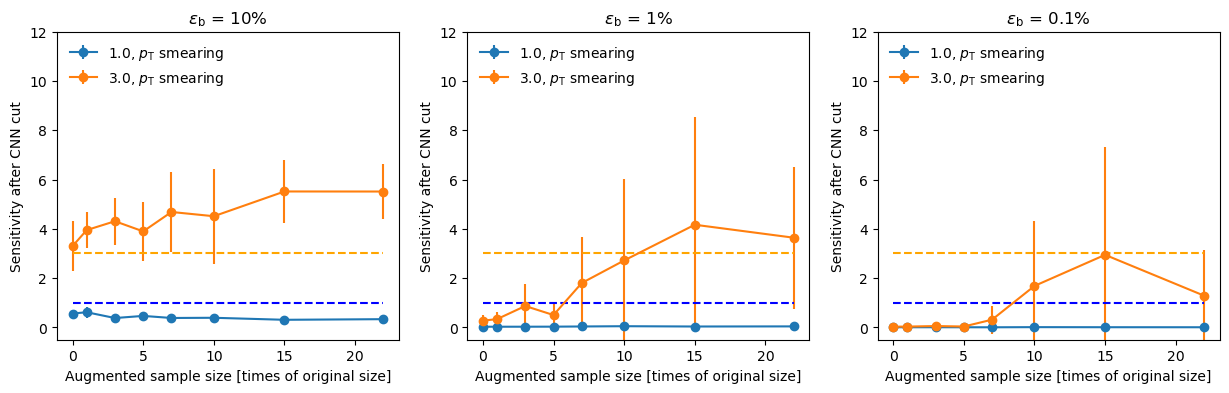

In [ ]:
sample_size = [1, 3, 5, 7, 10, 15, 22]

models = ['SB_1.0_75x75'] + [f'SB_1.0_pt_aug_{n}_75x75' for n in sample_size]
sensitivities_pt_aug_1, stds_pt_aug_1 = get_realistic_sensitivity_and_std_from_models(models, sensitivity=1.0)

models = ['SB_3.0_75x75'] + [f'SB_3.0_pt_aug_{n}_75x75' for n in sample_size]
sensitivities_pt_aug_3, stds_pt_aug_3 = get_realistic_sensitivity_and_std_from_models(models, sensitivity=3.0)

fig, ax = plt.subplots(1, 3, figsize=(15, 4))

titles = ['$\epsilon_\mathrm{b}$ = 10%', '$\epsilon_\mathrm{b}$ = 1%', '$\epsilon_\mathrm{b}$ = 0.1%']
for i in range(3):

    ax[i].errorbar([0] + sample_size, sensitivities_pt_aug_1[i], yerr=stds_pt_aug_1[i], marker='o', label='1.0, $p_\mathrm{T}$ smearing')
    ax[i].errorbar([0] + sample_size, sensitivities_pt_aug_3[i], yerr=stds_pt_aug_3[i], marker='o', label='3.0, $p_\mathrm{T}$ smearing')

    ax[i].set_title(titles[i])
    ax[i].hlines(1, 0, 22, color='b', linestyle='--')
    ax[i].hlines(3, 0, 22, color='orange', linestyle='--')
    ax[i].set_ylim(-0.5, 12)
    ax[i].set_xlabel('Augmented sample size [times of original size]')
    ax[i].set_ylabel('Sensitivity after CNN cut')

    ax[i].legend(frameon=False, loc='upper left')

plt.savefig('../figures/HVmodel_sensitivity_improvement_pt_aug_SB_1_3_res_75.pdf', dpi=300, facecolor='White', bbox_inches='tight')
plt.show()

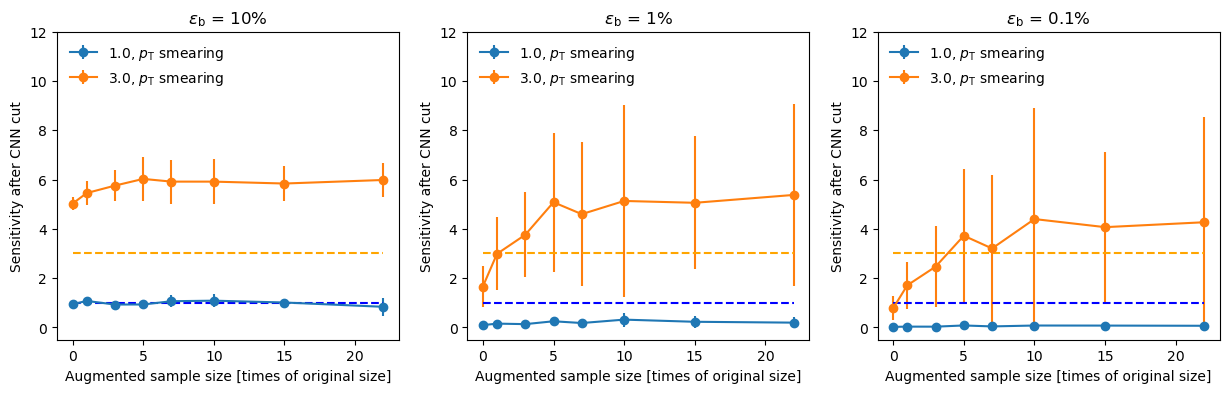

In [ ]:
sample_size = [1, 3, 5, 7, 10, 15, 22]

models = ['SB_1.0_25x25'] + [f'SB_1.0_pt_aug_{n}_25x25' for n in sample_size]
sensitivities_pt_aug_1, stds_pt_aug_1 = get_realistic_sensitivity_and_std_from_models(models, sensitivity=1.0)

models = ['SB_3.0_25x25'] + [f'SB_3.0_pt_aug_{n}_25x25' for n in sample_size]
sensitivities_pt_aug_3, stds_pt_aug_3 = get_realistic_sensitivity_and_std_from_models(models, sensitivity=3.0)

fig, ax = plt.subplots(1, 3, figsize=(15, 4))

titles = ['$\epsilon_\mathrm{b}$ = 10%', '$\epsilon_\mathrm{b}$ = 1%', '$\epsilon_\mathrm{b}$ = 0.1%']
for i in range(3):

    ax[i].errorbar([0] + sample_size, sensitivities_pt_aug_1[i], yerr=stds_pt_aug_1[i], marker='o', label='1.0, $p_\mathrm{T}$ smearing')
    ax[i].errorbar([0] + sample_size, sensitivities_pt_aug_3[i], yerr=stds_pt_aug_3[i], marker='o', label='3.0, $p_\mathrm{T}$ smearing')

    ax[i].set_title(titles[i])
    ax[i].hlines(1, 0, 22, color='b', linestyle='--')
    ax[i].hlines(3, 0, 22, color='orange', linestyle='--')
    ax[i].set_ylim(-0.5, 12)
    ax[i].set_xlabel('Augmented sample size [times of original size]')
    ax[i].set_ylabel('Sensitivity after CNN cut')

    ax[i].legend(frameon=False, loc='upper left')

plt.savefig('../figures/HVmodel_sensitivity_improvement_pt_aug_SB_1_3_res_25.pdf', dpi=300, facecolor='White', bbox_inches='tight')
plt.show()

## $p_\text{T}$ smearing + jet rotation 

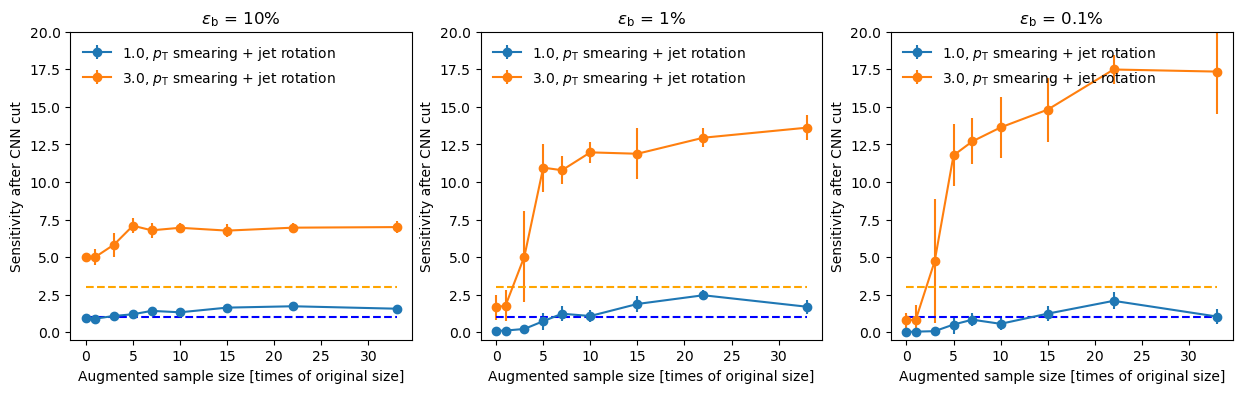

In [ ]:
sample_size = [1, 3, 5, 7, 10, 15, 22, 33]

models = ['SB_1.0_25x25'] + [f'SB_1.0_pt_jet_aug_{n}_25x25' for n in sample_size]
sensitivities_pt_jet_aug_1, stds_pt_jet_aug_1 = get_realistic_sensitivity_and_std_from_models(models, sensitivity=1.0)

models = ['SB_3.0_25x25'] + [f'SB_3.0_pt_jet_aug_{n}_25x25' for n in sample_size]
sensitivities_pt_jet_aug_3, stds_pt_jet_aug_3 = get_realistic_sensitivity_and_std_from_models(models, sensitivity=3.0)

fig, ax = plt.subplots(1, 3, figsize=(15, 4))

titles = ['$\epsilon_\mathrm{b}$ = 10%', '$\epsilon_\mathrm{b}$ = 1%', '$\epsilon_\mathrm{b}$ = 0.1%']
for i in range(3):

    ax[i].errorbar([0] + sample_size, sensitivities_pt_jet_aug_1[i], yerr=stds_pt_jet_aug_1[i], marker='o', label='1.0, $p_\mathrm{T}$ smearing + jet rotation')

    ax[i].errorbar([0] + sample_size, sensitivities_pt_jet_aug_3[i], yerr=stds_pt_jet_aug_3[i], marker='o', label='3.0, $p_\mathrm{T}$ smearing + jet rotation')

    ax[i].set_title(titles[i])
    ax[i].hlines(1, 0, 33, color='b', linestyle='--')
    ax[i].hlines(3, 0, 33, color='orange', linestyle='--')
    ax[i].set_ylim(-0.5, 20)
    ax[i].set_xlabel('Augmented sample size [times of original size]')
    ax[i].set_ylabel('Sensitivity after CNN cut')

    ax[i].legend(frameon=False, loc='upper left')

plt.savefig('../figures/HVmodel_sensitivity_improvement_pt_jet_aug_SB_1_3_res_25.pdf', dpi=300, facecolor='White', bbox_inches='tight')
plt.show()

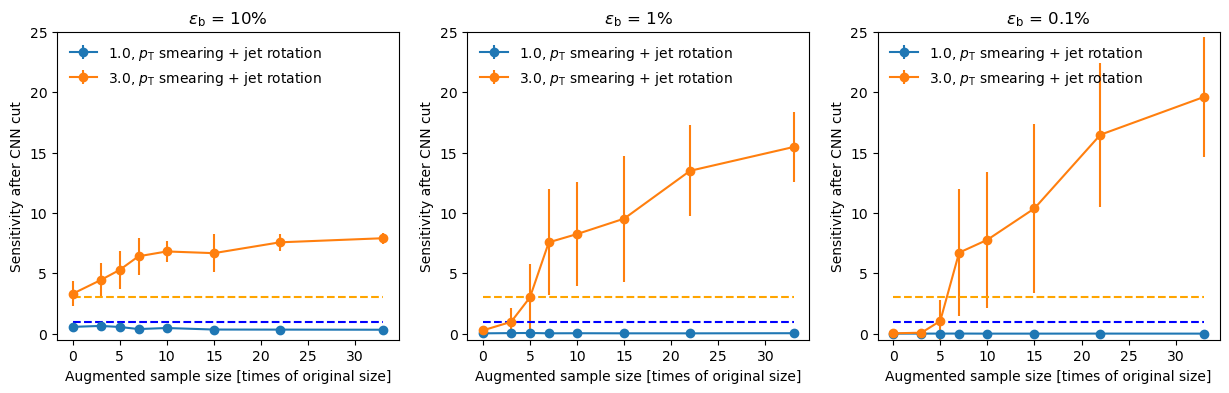

In [ ]:
sample_size = [3, 5, 7, 10, 15, 22, 33]

models = ['SB_1.0_75x75'] + [f'SB_1.0_pt_jet_aug_{n}_75x75' for n in sample_size]
sensitivities_pt_jet_aug_1, stds_pt_jet_aug_1 = get_realistic_sensitivity_and_std_from_models(models, sensitivity=1.0)

models = ['SB_3.0_75x75'] + [f'SB_3.0_jet_aug_{n}_75x75' for n in sample_size]
sensitivities_jet_aug_3, stds_jet_aug_3 = get_realistic_sensitivity_and_std_from_models(models, sensitivity=3.0)

models = ['SB_3.0_75x75'] + [f'SB_3.0_pt_jet_aug_{n}_75x75' for n in sample_size]
sensitivities_pt_jet_aug_3, stds_pt_jet_aug_3 = get_realistic_sensitivity_and_std_from_models(models, sensitivity=3.0)

fig, ax = plt.subplots(1, 3, figsize=(15, 4))

titles = ['$\epsilon_\mathrm{b}$ = 10%', '$\epsilon_\mathrm{b}$ = 1%', '$\epsilon_\mathrm{b}$ = 0.1%']
for i in range(3):

    ax[i].errorbar([0] + sample_size, sensitivities_pt_jet_aug_1[i], yerr=stds_pt_jet_aug_1[i], marker='o', label='1.0, $p_\mathrm{T}$ smearing + jet rotation')
    ax[i].errorbar([0] + sample_size, sensitivities_pt_jet_aug_3[i], yerr=stds_pt_jet_aug_3[i], marker='o', label='3.0, $p_\mathrm{T}$ smearing + jet rotation')

    ax[i].set_title(titles[i])
    ax[i].hlines(1, 0, 33, color='b', linestyle='--')
    ax[i].hlines(3, 0, 33, color='orange', linestyle='--')
    ax[i].set_ylim(-0.5, 25)
    ax[i].set_xlabel('Augmented sample size [times of original size]')
    ax[i].set_ylabel('Sensitivity after CNN cut')

    ax[i].legend(frameon=False, loc='upper left')

plt.savefig('../figures/HVmodel_sensitivity_improvement_pt_jet_aug_SB_1_3_res_75.pdf', dpi=300, facecolor='White', bbox_inches='tight')
plt.show()

## Summary

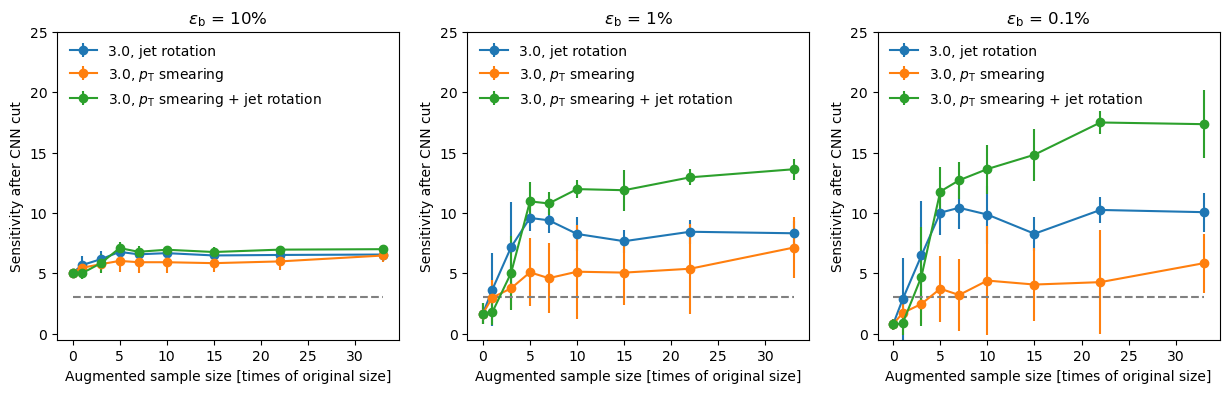

In [ ]:
sample_size = [1, 3, 5, 7, 10, 15, 22, 33]
res = 25
models = [f'SB_3.0_{res}x{res}'] + [f'SB_3.0_jet_aug_{n}_{res}x{res}' for n in sample_size]
sensitivities_jet_aug_3, stds_jet_aug_3 = get_realistic_sensitivity_and_std_from_models(models, sensitivity=3.0)

models = [f'SB_3.0_{res}x{res}'] + [f'SB_3.0_pt_aug_{n}_{res}x{res}' for n in sample_size]
sensitivities_pt_aug_3, stds_pt_aug_3 = get_realistic_sensitivity_and_std_from_models(models, sensitivity=3.0)

models = [f'SB_3.0_{res}x{res}'] + [f'SB_3.0_pt_jet_aug_{n}_{res}x{res}' for n in sample_size]
sensitivities_pt_jet_aug_3, stds_pt_jet_aug_3 = get_realistic_sensitivity_and_std_from_models(models, sensitivity=3.0)

fig, ax = plt.subplots(1, 3, figsize=(15, 4))

titles = ['$\epsilon_\mathrm{b}$ = 10%', '$\epsilon_\mathrm{b}$ = 1%', '$\epsilon_\mathrm{b}$ = 0.1%']
for i in range(3):

    ax[i].errorbar([0] + sample_size, sensitivities_jet_aug_3[i], yerr=stds_jet_aug_3[i], marker='o', label='3.0, jet rotation')
    ax[i].errorbar([0] + sample_size, sensitivities_pt_aug_3[i], yerr=stds_pt_aug_3[i], marker='o', label='3.0, $p_\mathrm{T}$ smearing')
    ax[i].errorbar([0] + sample_size, sensitivities_pt_jet_aug_3[i], yerr=stds_pt_jet_aug_3[i], marker='o', label='3.0, $p_\mathrm{T}$ smearing + jet rotation')

    ax[i].set_title(titles[i])
    ax[i].hlines(3, 0, sample_size[-1], color='gray', linestyle='--')
    ax[i].set_ylim(-0.5, 25)
    ax[i].set_xlabel('Augmented sample size [times of original size]')
    ax[i].set_ylabel('Sensitivity after CNN cut')

    ax[i].legend(frameon=False, loc='upper left')

plt.savefig(f'../figures/HVmodel_sensitivity_improvement_summary_aug_SB_3_res_{res}.pdf', dpi=300, facecolor='White', bbox_inches='tight')
plt.show()

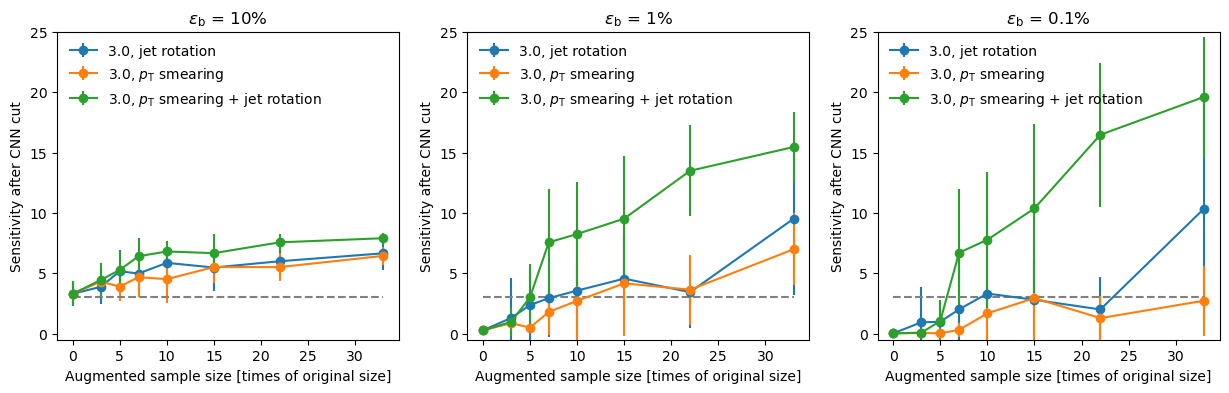

In [ ]:
sample_size = [3, 5, 7, 10, 15, 22, 33]
res = 75
models = [f'SB_3.0_{res}x{res}'] + [f'SB_3.0_jet_aug_{n}_{res}x{res}' for n in sample_size]
sensitivities_jet_aug_3, stds_jet_aug_3 = get_realistic_sensitivity_and_std_from_models(models, sensitivity=3.0)

models = [f'SB_3.0_{res}x{res}'] + [f'SB_3.0_pt_aug_{n}_{res}x{res}' for n in sample_size]
sensitivities_pt_aug_3, stds_pt_aug_3 = get_realistic_sensitivity_and_std_from_models(models, sensitivity=3.0)

models = [f'SB_3.0_{res}x{res}'] + [f'SB_3.0_pt_jet_aug_{n}_{res}x{res}' for n in sample_size]
sensitivities_pt_jet_aug_3, stds_pt_jet_aug_3 = get_realistic_sensitivity_and_std_from_models(models, sensitivity=3.0)

fig, ax = plt.subplots(1, 3, figsize=(15, 4))

titles = ['$\epsilon_\mathrm{b}$ = 10%', '$\epsilon_\mathrm{b}$ = 1%', '$\epsilon_\mathrm{b}$ = 0.1%']
for i in range(3):

    ax[i].errorbar([0] + sample_size, sensitivities_jet_aug_3[i], yerr=stds_jet_aug_3[i], marker='o', label='3.0, jet rotation')
    ax[i].errorbar([0] + sample_size, sensitivities_pt_aug_3[i], yerr=stds_pt_aug_3[i], marker='o', label='3.0, $p_\mathrm{T}$ smearing')
    ax[i].errorbar([0] + sample_size, sensitivities_pt_jet_aug_3[i], yerr=stds_pt_jet_aug_3[i], marker='o', label='3.0, $p_\mathrm{T}$ smearing + jet rotation')

    ax[i].set_title(titles[i])
    ax[i].hlines(3, 0, sample_size[-1], color='gray', linestyle='--')
    ax[i].set_ylim(-0.5, 25)
    ax[i].set_xlabel('Augmented sample size [times of original size]')
    ax[i].set_ylabel('Sensitivity after CNN cut')

    ax[i].legend(frameon=False, loc='upper left')

plt.savefig(f'../figures/HVmodel_sensitivity_improvement_summary_aug_SB_3_res_{res}.pdf', dpi=300, facecolor='White', bbox_inches='tight')
plt.show()


# $p_\text{T}$ smearing + jet rotation 

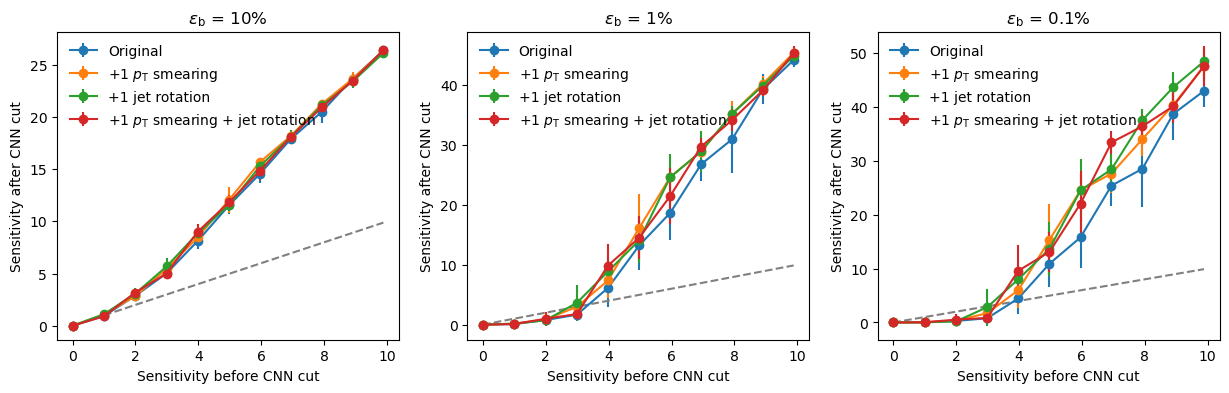

In [ ]:
sensitivities_origin, stds_origin = get_realistic_sensitivity_and_std('SB_{:.1f}_25x25')
sensitivities_jet_aug_1, stds_jet_aug_1 = get_realistic_sensitivity_and_std('SB_{:.1f}_jet_aug_1_25x25')
sensitivities_pt_aug_1, stds_pt_aug_1 = get_realistic_sensitivity_and_std('SB_{:.1f}_pt_aug_1_25x25')
sensitivities_pt_jet_aug_1, stds_pt_jet_aug_1 = get_realistic_sensitivity_and_std('SB_{:.1f}_pT_jet_aug_1_25x25')


sensitivities = convert_to_realistic_sensitivity(np.arange(11), nB=n_bkg_in_SR)

fig, ax = plt.subplots(1, 3, figsize=(15, 4))

titles = ['$\epsilon_\mathrm{b}$ = 10%', '$\epsilon_\mathrm{b}$ = 1%', '$\epsilon_\mathrm{b}$ = 0.1%']
for i in range(3):

    ax[i].errorbar(sensitivities, sensitivities_origin[i], yerr=stds_origin[i], marker='o', label='Original')
    ax[i].errorbar(sensitivities, sensitivities_pt_aug_1[i], yerr=stds_pt_aug_1[i], marker='o', label='+1 $p_\mathrm{T}$ smearing')
    ax[i].errorbar(sensitivities, sensitivities_jet_aug_1[i], yerr=stds_jet_aug_1[i], marker='o', label='+1 jet rotation')
    ax[i].errorbar(sensitivities, sensitivities_pt_jet_aug_1[i], yerr=stds_pt_jet_aug_1[i], marker='o', label='+1 $p_\mathrm{T}$ smearing + jet rotation')

    ax[i].plot(sensitivities, sensitivities, '--', color='grey')

    ax[i].set_title(titles[i])
    ax[i].set_xlabel('Sensitivity before CNN cut')
    ax[i].set_ylabel('Sensitivity after CNN cut')

    ax[i].legend(frameon=False, loc='upper left')

plt.savefig('../figures/HVmodel_sensitivity_improvement_origin_pt_jet_aug_1_res_25.pdf', dpi=300, facecolor='White', bbox_inches='tight')
plt.show()

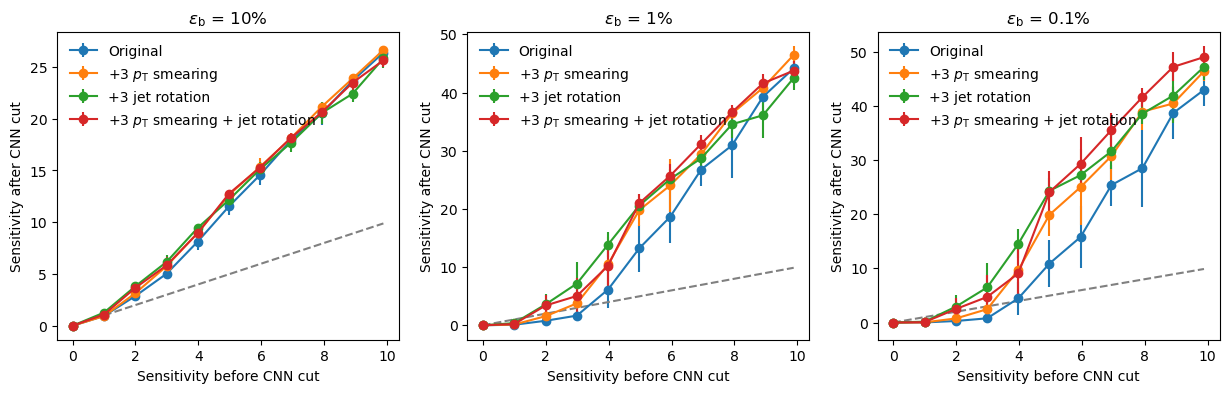

In [ ]:
sensitivities_origin, stds_origin = get_realistic_sensitivity_and_std('SB_{:.1f}_25x25')
sensitivities_jet_aug_3, stds_jet_aug_3 = get_realistic_sensitivity_and_std('SB_{:.1f}_jet_aug_3_25x25')
sensitivities_pt_aug_3, stds_pt_aug_3 = get_realistic_sensitivity_and_std('SB_{:.1f}_pt_aug_3_25x25')
sensitivities_pt_jet_aug_3, stds_pt_jet_aug_3 = get_realistic_sensitivity_and_std('SB_{:.1f}_pT_jet_aug_3_25x25')


sensitivities = convert_to_realistic_sensitivity(np.arange(11), nB=n_bkg_in_SR)

fig, ax = plt.subplots(1, 3, figsize=(15, 4))

titles = ['$\epsilon_\mathrm{b}$ = 10%', '$\epsilon_\mathrm{b}$ = 1%', '$\epsilon_\mathrm{b}$ = 0.1%']
for i in range(3):

    ax[i].errorbar(sensitivities, sensitivities_origin[i], yerr=stds_origin[i], marker='o', label='Original')
    ax[i].errorbar(sensitivities, sensitivities_pt_aug_3[i], yerr=stds_pt_aug_3[i], marker='o', label='+3 $p_\mathrm{T}$ smearing')
    ax[i].errorbar(sensitivities, sensitivities_jet_aug_3[i], yerr=stds_jet_aug_3[i], marker='o', label='+3 jet rotation')
    ax[i].errorbar(sensitivities, sensitivities_pt_jet_aug_3[i], yerr=stds_pt_jet_aug_3[i], marker='o', label='+3 $p_\mathrm{T}$ smearing + jet rotation')

    ax[i].plot(sensitivities, sensitivities, '--', color='grey')

    ax[i].set_title(titles[i])
    ax[i].set_xlabel('Sensitivity before CNN cut')
    ax[i].set_ylabel('Sensitivity after CNN cut')

    ax[i].legend(frameon=False, loc='upper left')

plt.savefig('../figures/HVmodel_sensitivity_improvement_origin_pt_jet_aug_3_res_25.pdf', dpi=300, facecolor='White', bbox_inches='tight')
plt.show()

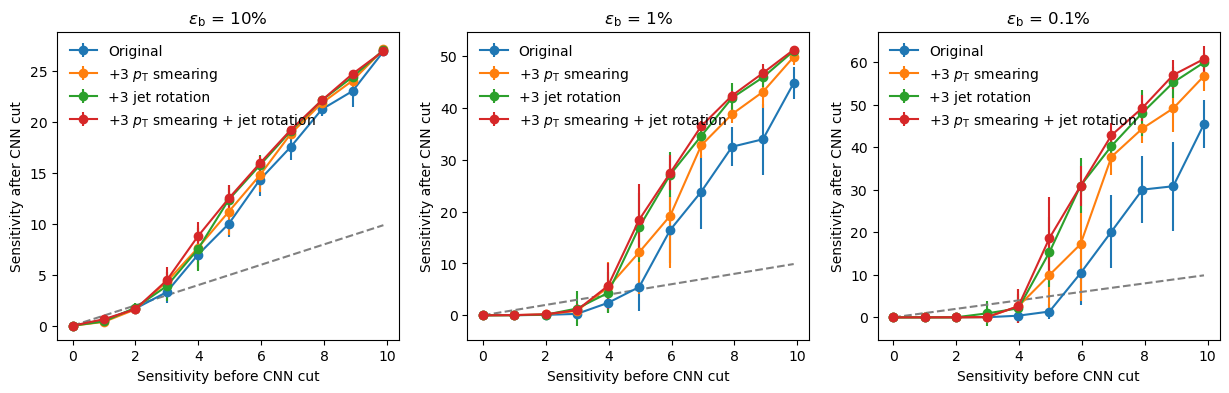

In [ ]:
sensitivities_origin, stds_origin = get_realistic_sensitivity_and_std('SB_{:.1f}_75x75')
sensitivities_jet_aug_3, stds_jet_aug_3 = get_realistic_sensitivity_and_std('SB_{:.1f}_jet_aug_3_75x75')
sensitivities_pt_aug_3, stds_pt_aug_3 = get_realistic_sensitivity_and_std('SB_{:.1f}_pt_aug_3_75x75')
sensitivities_pt_jet_aug_3, stds_pt_jet_aug_3 = get_realistic_sensitivity_and_std('SB_{:.1f}_pT_jet_aug_3_75x75')


sensitivities = convert_to_realistic_sensitivity(np.arange(11), nB=n_bkg_in_SR)

fig, ax = plt.subplots(1, 3, figsize=(15, 4))

titles = ['$\epsilon_\mathrm{b}$ = 10%', '$\epsilon_\mathrm{b}$ = 1%', '$\epsilon_\mathrm{b}$ = 0.1%']
for i in range(3):

    ax[i].errorbar(sensitivities, sensitivities_origin[i], yerr=stds_origin[i], marker='o', label='Original')
    ax[i].errorbar(sensitivities, sensitivities_pt_aug_3[i], yerr=stds_pt_aug_3[i], marker='o', label='+3 $p_\mathrm{T}$ smearing')
    ax[i].errorbar(sensitivities, sensitivities_jet_aug_3[i], yerr=stds_jet_aug_3[i], marker='o', label='+3 jet rotation')
    ax[i].errorbar(sensitivities, sensitivities_pt_jet_aug_3[i], yerr=stds_pt_jet_aug_3[i], marker='o', label='+3 $p_\mathrm{T}$ smearing + jet rotation')

    ax[i].plot(sensitivities, sensitivities, '--', color='grey')

    ax[i].set_title(titles[i])
    ax[i].set_xlabel('Sensitivity before CNN cut')
    ax[i].set_ylabel('Sensitivity after CNN cut')

    ax[i].legend(frameon=False, loc='upper left')

plt.savefig('../figures/HVmodel_sensitivity_improvement_origin_pt_jet_aug_3_res_75.pdf', dpi=300, facecolor='White', bbox_inches='tight')
plt.show()

## Different training dataset

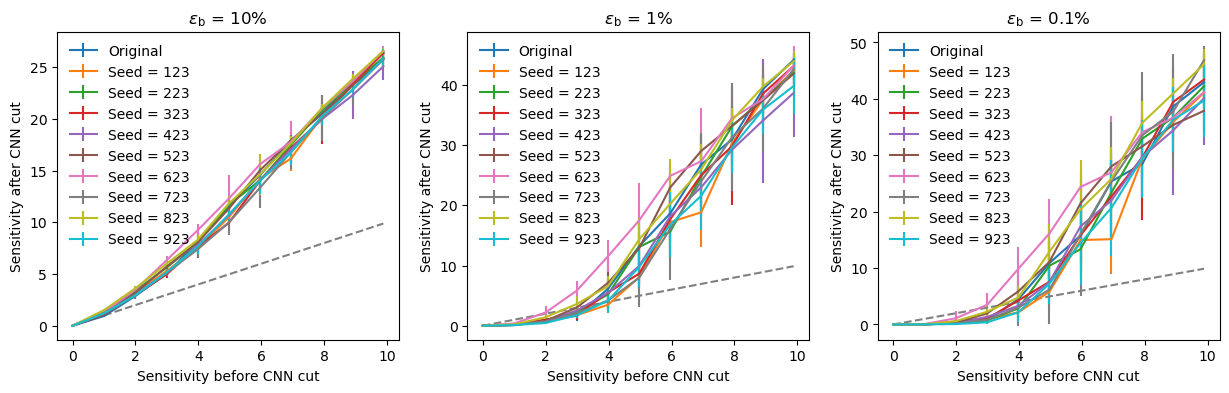

In [ ]:
sensitivities_origin, stds_origin = get_realistic_sensitivity_and_std('SB_{:.1f}_25x25')

sensitivities = convert_to_realistic_sensitivity(np.arange(11), nB=n_bkg_in_SR)

fig, ax = plt.subplots(1, 3, figsize=(15, 4))

titles = ['$\epsilon_\mathrm{b}$ = 10%', '$\epsilon_\mathrm{b}$ = 1%', '$\epsilon_\mathrm{b}$ = 0.1%']
for i in range(3):

    ax[i].errorbar(sensitivities, sensitivities_origin[i], yerr=stds_origin[i], marker='', label='Original')
    for j in range(1, 10):
        sn = j * 100 + 23
        sensitivities_rad, stds_rad = get_realistic_sensitivity_and_std('SB_{:.1f}_25x25_sn_' + f'{sn}')
        ax[i].errorbar(sensitivities, sensitivities_rad[i], yerr=stds_rad[i], marker='', label=f'Seed = {sn}')

    ax[i].plot(sensitivities, sensitivities, '--', color='grey')

    ax[i].set_title(titles[i])
    ax[i].set_xlabel('Sensitivity before CNN cut')
    ax[i].set_ylabel('Sensitivity after CNN cut')

    ax[i].legend(frameon=False, loc='upper left')

plt.savefig('../figures/HVmodel_sensitivity_improvement_origin_random_res_25.pdf', dpi=300, facecolor='White', bbox_inches='tight')
plt.show()

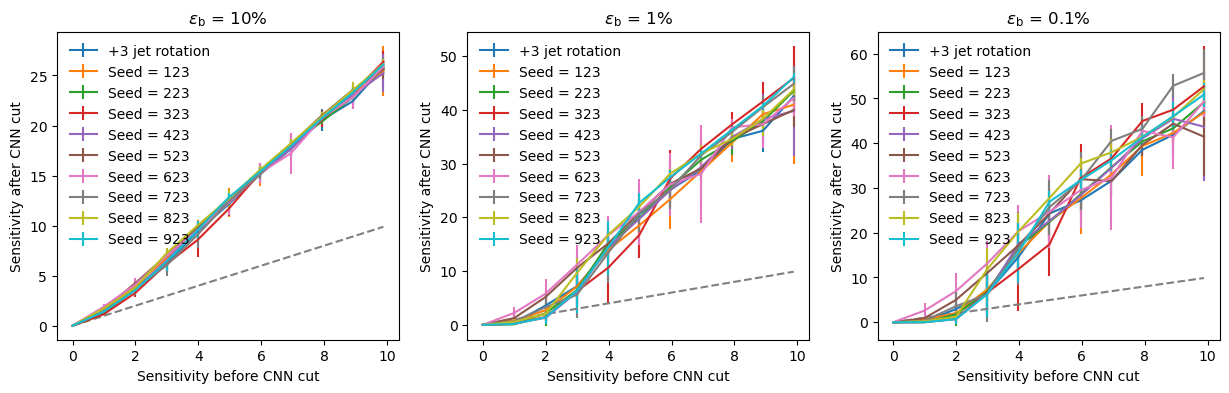

In [ ]:
sensitivities_origin, stds_origin = get_realistic_sensitivity_and_std('SB_{:.1f}_jet_aug_3_25x25')

sensitivities = convert_to_realistic_sensitivity(np.arange(11), nB=n_bkg_in_SR)

fig, ax = plt.subplots(1, 3, figsize=(15, 4))

titles = ['$\epsilon_\mathrm{b}$ = 10%', '$\epsilon_\mathrm{b}$ = 1%', '$\epsilon_\mathrm{b}$ = 0.1%']
for i in range(3):

    ax[i].errorbar(sensitivities, sensitivities_origin[i], yerr=stds_origin[i], marker='', label='+3 jet rotation')
    for j in range(1, 10):
        sn = j * 100 + 23
        sensitivities_rad, stds_rad = get_realistic_sensitivity_and_std('SB_{:.1f}_jet_aug_3_25x25_sn_' + f'{sn}')
        ax[i].errorbar(sensitivities, sensitivities_rad[i], yerr=stds_rad[i], marker='', label=f'Seed = {sn}')

    ax[i].plot(sensitivities, sensitivities, '--', color='grey')

    ax[i].set_title(titles[i])
    ax[i].set_xlabel('Sensitivity before CNN cut')
    ax[i].set_ylabel('Sensitivity after CNN cut')

    ax[i].legend(frameon=False, loc='upper left')

plt.savefig('../figures/HVmodel_sensitivity_improvement_jet_aug_3_random_res_25.pdf', dpi=300, facecolor='White', bbox_inches='tight')
plt.show()

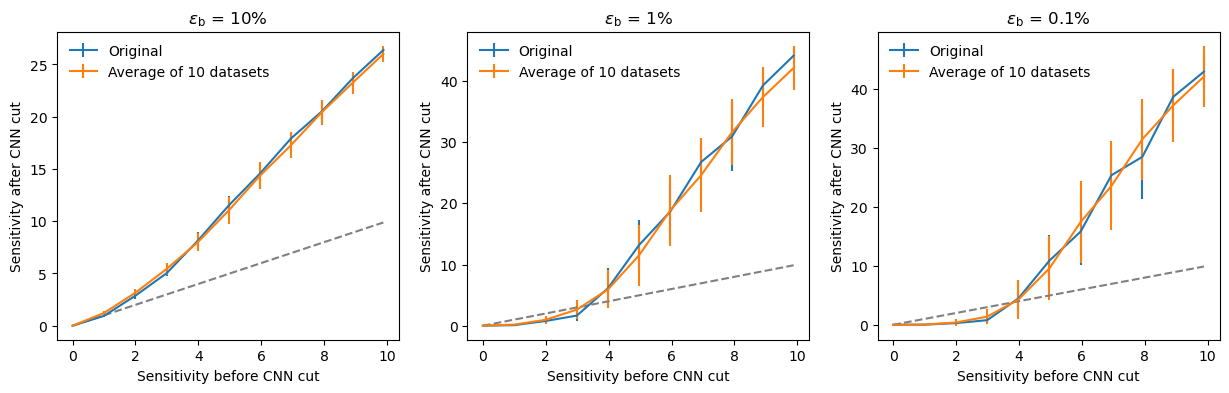

In [ ]:
sensitivities_origin, stds_origin = get_realistic_sensitivity_and_std('SB_{:.1f}_25x25')

model_formats = ['SB_{:.1f}_25x25'] + ['SB_{:.1f}_25x25_sn_'+ f'{sn}' for sn in range(123, 1000, 100)]
sensitivities_rad, stds_rad = get_average_realistic_sensitivity_and_std(model_formats)

sensitivities = convert_to_realistic_sensitivity(np.arange(11), nB=n_bkg_in_SR)

fig, ax = plt.subplots(1, 3, figsize=(15, 4))

titles = ['$\epsilon_\mathrm{b}$ = 10%', '$\epsilon_\mathrm{b}$ = 1%', '$\epsilon_\mathrm{b}$ = 0.1%']
for i in range(3):

    ax[i].errorbar(sensitivities, sensitivities_origin[i], yerr=stds_origin[i], marker='', label='Original')
    ax[i].errorbar(sensitivities, sensitivities_rad[i], yerr=stds_rad[i], marker='', label=f'Average of 10 datasets')

    ax[i].plot(sensitivities, sensitivities, '--', color='grey')

    ax[i].set_title(titles[i])
    ax[i].set_xlabel('Sensitivity before CNN cut')
    ax[i].set_ylabel('Sensitivity after CNN cut')

    ax[i].legend(frameon=False, loc='upper left')

plt.savefig('../figures/HVmodel_sensitivity_improvement_origin_random_average_res_25.pdf', dpi=300, facecolor='White', bbox_inches='tight')
plt.show()

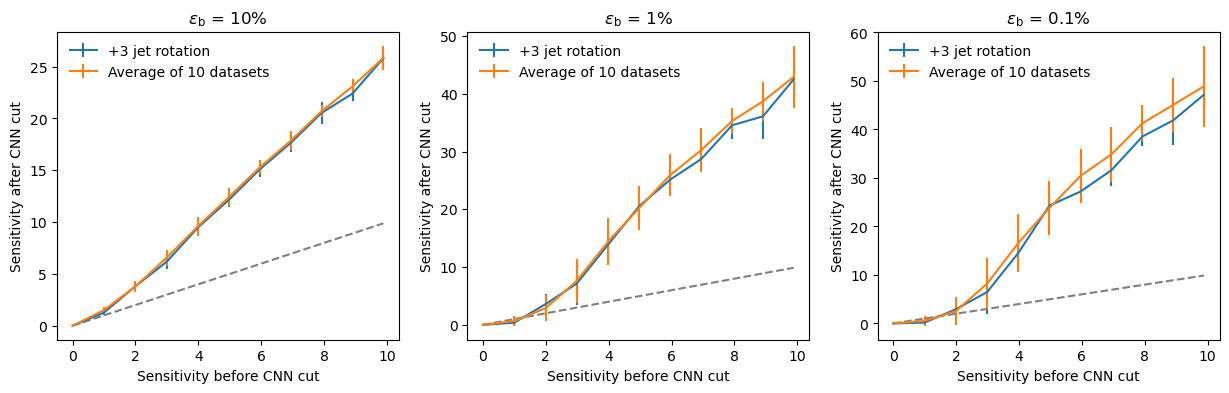

In [ ]:
sensitivities_origin, stds_origin = get_realistic_sensitivity_and_std('SB_{:.1f}_jet_aug_3_25x25')

model_formats = ['SB_{:.1f}_jet_aug_3_25x25'] + ['SB_{:.1f}_jet_aug_3_25x25_sn_'+ f'{sn}' for sn in range(123, 1000, 100)]
sensitivities_rad, stds_rad = get_average_realistic_sensitivity_and_std(model_formats)

sensitivities = convert_to_realistic_sensitivity(np.arange(11), nB=n_bkg_in_SR)

fig, ax = plt.subplots(1, 3, figsize=(15, 4))

titles = ['$\epsilon_\mathrm{b}$ = 10%', '$\epsilon_\mathrm{b}$ = 1%', '$\epsilon_\mathrm{b}$ = 0.1%']
for i in range(3):

    ax[i].errorbar(sensitivities, sensitivities_origin[i], yerr=stds_origin[i], marker='', label='+3 jet rotation')
    ax[i].errorbar(sensitivities, sensitivities_rad[i], yerr=stds_rad[i], marker='', label=f'Average of 10 datasets')

    ax[i].plot(sensitivities, sensitivities, '--', color='grey')

    ax[i].set_title(titles[i])
    ax[i].set_xlabel('Sensitivity before CNN cut')
    ax[i].set_ylabel('Sensitivity after CNN cut')

    ax[i].legend(frameon=False, loc='upper left')

plt.savefig('../figures/HVmodel_sensitivity_improvement_jet_aug_3_random_average_res_25.pdf', dpi=300, facecolor='White', bbox_inches='tight')
plt.show()

## Hyperparameter optimization

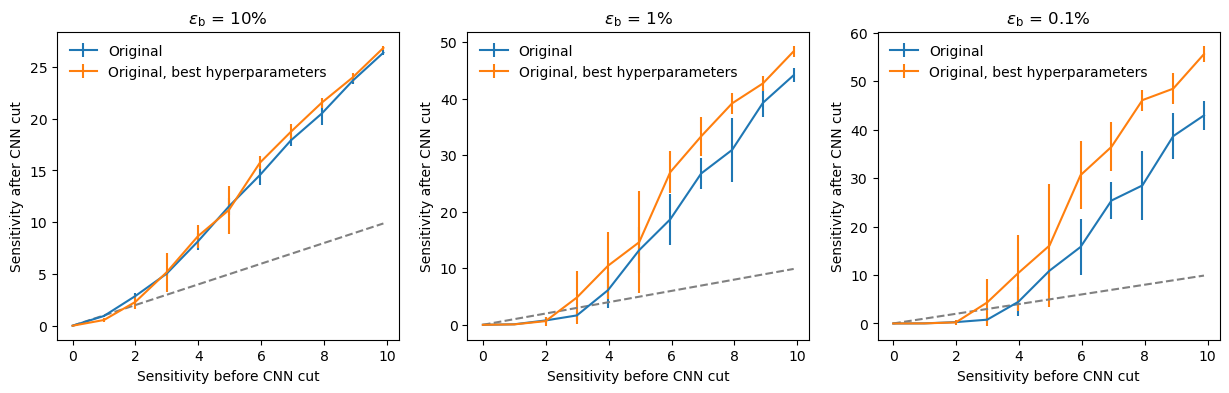

In [ ]:
sensitivities_origin, stds_origin = get_realistic_sensitivity_and_std('SB_{:.1f}_25x25')
sensitivities_origin_hp, stds_origin_hp = get_realistic_sensitivity_and_std('SB_{:.1f}_25x25_best_hp')

sensitivities = convert_to_realistic_sensitivity(np.arange(11), nB=n_bkg_in_SR)

fig, ax = plt.subplots(1, 3, figsize=(15, 4))

titles = ['$\epsilon_\mathrm{b}$ = 10%', '$\epsilon_\mathrm{b}$ = 1%', '$\epsilon_\mathrm{b}$ = 0.1%']
for i in range(3):

    ax[i].errorbar(sensitivities, sensitivities_origin[i], yerr=stds_origin[i], marker='', label='Original')
    ax[i].errorbar(sensitivities, sensitivities_origin_hp[i], yerr=stds_origin_hp[i], marker='', label='Original, best hyperparameters')

    ax[i].plot(sensitivities, sensitivities, '--', color='grey')

    ax[i].set_title(titles[i])
    ax[i].set_xlabel('Sensitivity before CNN cut')
    ax[i].set_ylabel('Sensitivity after CNN cut')

    ax[i].legend(frameon=False, loc='upper left')

plt.savefig('../figures/HVmodel_sensitivity_improvement_origin_best_hp_res_25.pdf', dpi=300, facecolor='White', bbox_inches='tight')
plt.show()

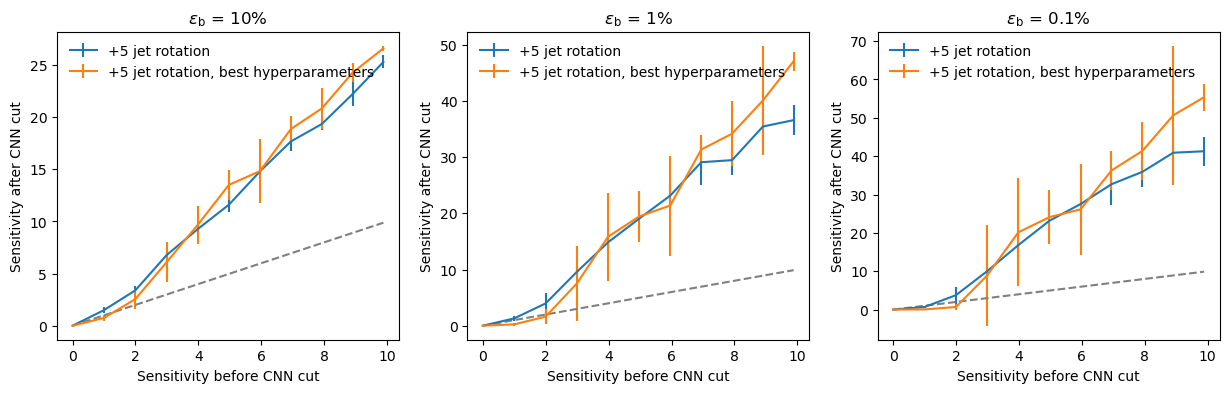

In [ ]:
sensitivities_jet_aug, stds_jet_aug = get_realistic_sensitivity_and_std('SB_{:.1f}_jet_aug_5_25x25')
sensitivities_jet_aug_hp, stds_jet_aug_hp = get_realistic_sensitivity_and_std('SB_{:.1f}_jet_aug_5_25x25_best_hp')

sensitivities = convert_to_realistic_sensitivity(np.arange(11), nB=n_bkg_in_SR)

fig, ax = plt.subplots(1, 3, figsize=(15, 4))

titles = ['$\epsilon_\mathrm{b}$ = 10%', '$\epsilon_\mathrm{b}$ = 1%', '$\epsilon_\mathrm{b}$ = 0.1%']
for i in range(3):

    ax[i].errorbar(sensitivities, sensitivities_jet_aug[i], yerr=stds_jet_aug[i], marker='', label='+5 jet rotation')
    ax[i].errorbar(sensitivities, sensitivities_jet_aug_hp[i], yerr=stds_jet_aug_hp[i], marker='', label='+5 jet rotation, best hyperparameters')

    ax[i].plot(sensitivities, sensitivities, '--', color='grey')

    ax[i].set_title(titles[i])
    ax[i].set_xlabel('Sensitivity before CNN cut')
    ax[i].set_ylabel('Sensitivity after CNN cut')

    ax[i].legend(frameon=False, loc='upper left')

plt.savefig('../figures/HVmodel_sensitivity_improvement_jet_aug_5_best_hp_res_25.pdf', dpi=300, facecolor='White', bbox_inches='tight')
plt.show()

## Jet rotation range

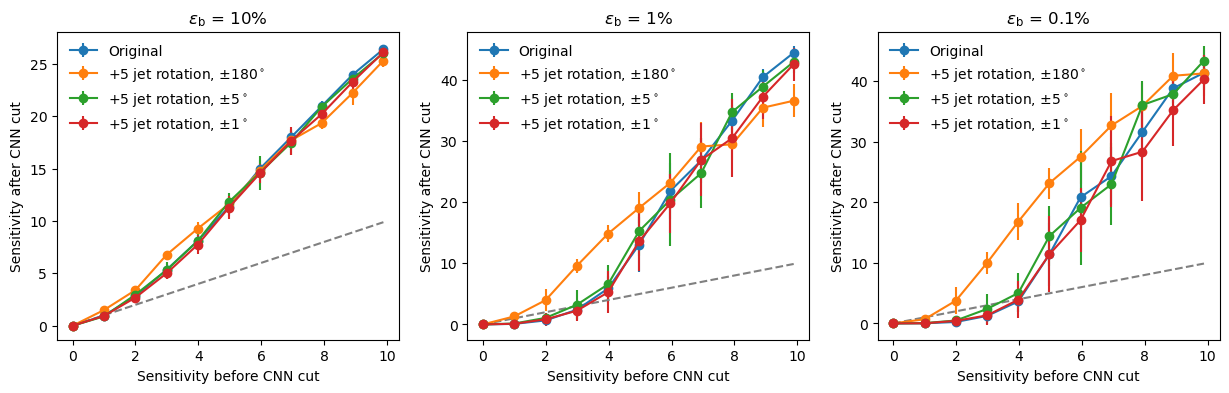

In [ ]:
sensitivities_origin, stds_origin = get_realistic_sensitivity_and_std('SB_{:.1f}_25x25', s=slice(10))
sensitivities_jet_aug_5_180, stds_jet_aug_5_180 = get_realistic_sensitivity_and_std('SB_{:.1f}_jet_aug_5_25x25')
sensitivities_jet_aug_5_5, stds_jet_aug_5_5 = get_realistic_sensitivity_and_std('SB_{:.1f}_jet_aug_5_range_5_25x25')
sensitivities_jet_aug_5_1, stds_jet_aug_5_1 = get_realistic_sensitivity_and_std('SB_{:.1f}_jet_aug_5_range_1_25x25')

sensitivities = convert_to_realistic_sensitivity(np.arange(11), nB=n_bkg_in_SR)

fig, ax = plt.subplots(1, 3, figsize=(15, 4))

titles = ['$\epsilon_\mathrm{b}$ = 10%', '$\epsilon_\mathrm{b}$ = 1%', '$\epsilon_\mathrm{b}$ = 0.1%']
for i in range(3):

    ax[i].errorbar(sensitivities, sensitivities_origin[i], yerr=stds_origin[i], marker='o', label='Original')
    ax[i].errorbar(sensitivities, sensitivities_jet_aug_5_180[i], yerr=stds_jet_aug_5_180[i], marker='o', label='+5 jet rotation, $\pm 180^\circ$')
    ax[i].errorbar(sensitivities, sensitivities_jet_aug_5_5[i], yerr=stds_jet_aug_5_5[i], marker='o', label='+5 jet rotation, $\pm 5^\circ$')
    ax[i].errorbar(sensitivities, sensitivities_jet_aug_5_1[i], yerr=stds_jet_aug_5_1[i], marker='o', label='+5 jet rotation, $\pm 1^\circ$')

    ax[i].plot(sensitivities, sensitivities, '--', color='grey')

    ax[i].set_title(titles[i])
    ax[i].set_xlabel('Sensitivity before CNN cut')
    ax[i].set_ylabel('Sensitivity after CNN cut')

    ax[i].legend(frameon=False, loc='upper left')

plt.savefig('../figures/HVmodel_sensitivity_improvement_origin_jet_aug_5_range_180_5_1_res_25.pdf', dpi=300, facecolor='White', bbox_inches='tight')
plt.show()

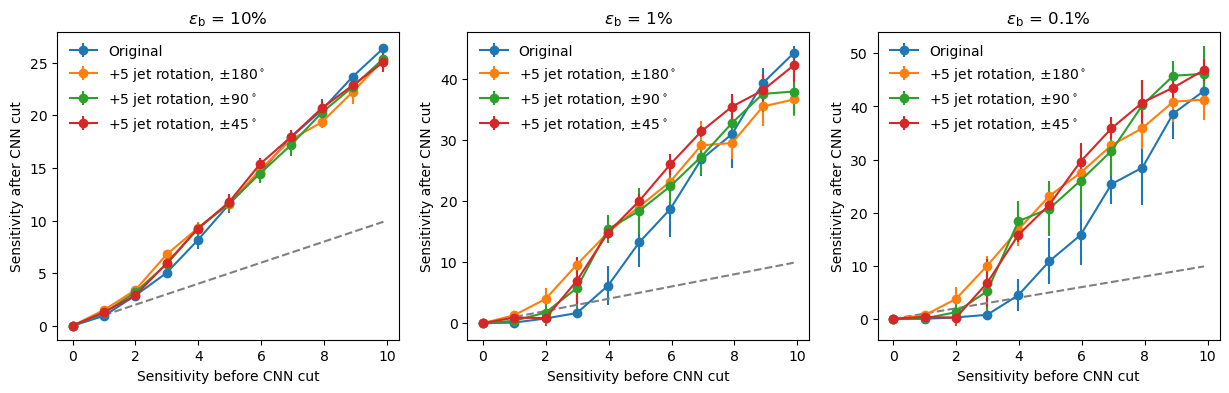

In [ ]:
sensitivities_origin, stds_origin = get_realistic_sensitivity_and_std('SB_{:.1f}_25x25')
sensitivities_jet_aug_5_180, stds_jet_aug_5_180 = get_realistic_sensitivity_and_std('SB_{:.1f}_jet_aug_5_25x25')
sensitivities_jet_aug_5_90, stds_jet_aug_5_90 = get_realistic_sensitivity_and_std('SB_{:.1f}_jet_aug_5_range_90_25x25')
sensitivities_jet_aug_5_45, stds_jet_aug_5_45 = get_realistic_sensitivity_and_std('SB_{:.1f}_jet_aug_5_range_45_25x25')


sensitivities = convert_to_realistic_sensitivity(np.arange(11), nB=n_bkg_in_SR)

fig, ax = plt.subplots(1, 3, figsize=(15, 4))

titles = ['$\epsilon_\mathrm{b}$ = 10%', '$\epsilon_\mathrm{b}$ = 1%', '$\epsilon_\mathrm{b}$ = 0.1%']
for i in range(3):

    ax[i].errorbar(sensitivities, sensitivities_origin[i], yerr=stds_origin[i], marker='o', label='Original')
    ax[i].errorbar(sensitivities, sensitivities_jet_aug_5_180[i], yerr=stds_jet_aug_5_180[i], marker='o', label='+5 jet rotation, $\pm 180^\circ$')
    ax[i].errorbar(sensitivities, sensitivities_jet_aug_5_90[i], yerr=stds_jet_aug_5_90[i], marker='o', label='+5 jet rotation, $\pm 90^\circ$')
    ax[i].errorbar(sensitivities, sensitivities_jet_aug_5_45[i], yerr=stds_jet_aug_5_45[i], marker='o', label='+5 jet rotation, $\pm 45^\circ$')

    ax[i].plot(sensitivities, sensitivities, '--', color='grey')

    ax[i].set_title(titles[i])
    ax[i].set_xlabel('Sensitivity before CNN cut')
    ax[i].set_ylabel('Sensitivity after CNN cut')

    ax[i].legend(frameon=False, loc='upper left')

plt.savefig('../figures/HVmodel_sensitivity_improvement_origin_jet_aug_5_range_180_90_45_res_25.pdf', dpi=300, facecolor='White', bbox_inches='tight')
plt.show()

## Fixed rotation angles

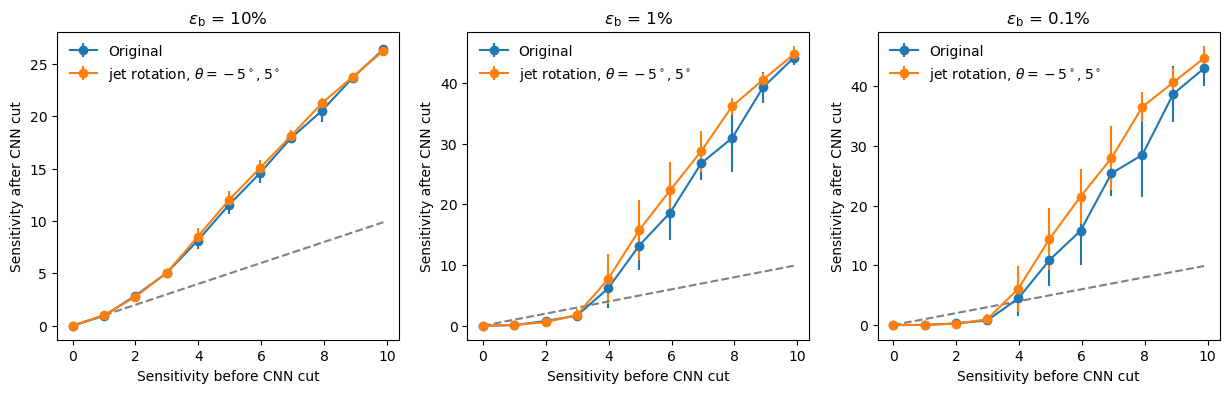

In [ ]:
sensitivities_origin, stds_origin = get_realistic_sensitivity_and_std('SB_{:.1f}_25x25')
sensitivities_jet_aug_angles, stds_jet_aug_angles = get_realistic_sensitivity_and_std('SB_{:.1f}_jet_aug_angles_-5_5_25x25')

sensitivities = convert_to_realistic_sensitivity(np.arange(11), nB=n_bkg_in_SR)

fig, ax = plt.subplots(1, 3, figsize=(15, 4))

titles = ['$\epsilon_\mathrm{b}$ = 10%', '$\epsilon_\mathrm{b}$ = 1%', '$\epsilon_\mathrm{b}$ = 0.1%']
for i in range(3):

    ax[i].errorbar(sensitivities, sensitivities_origin[i], yerr=stds_origin[i], marker='o', label='Original')
    ax[i].errorbar(sensitivities, sensitivities_jet_aug_angles[i], yerr=stds_jet_aug_angles[i], marker='o', label='jet rotation, $\\theta=-5^\circ, 5^\circ$')

    ax[i].plot(sensitivities, sensitivities, '--', color='grey')

    ax[i].set_title(titles[i])
    ax[i].set_xlabel('Sensitivity before CNN cut')
    ax[i].set_ylabel('Sensitivity after CNN cut')

    ax[i].legend(frameon=False, loc='upper left')

plt.savefig('../figures/HVmodel_sensitivity_improvement_origin_jet_aug_angles_-5_5_res_25.pdf', dpi=300, facecolor='White', bbox_inches='tight')
plt.show()

# Re-sampling

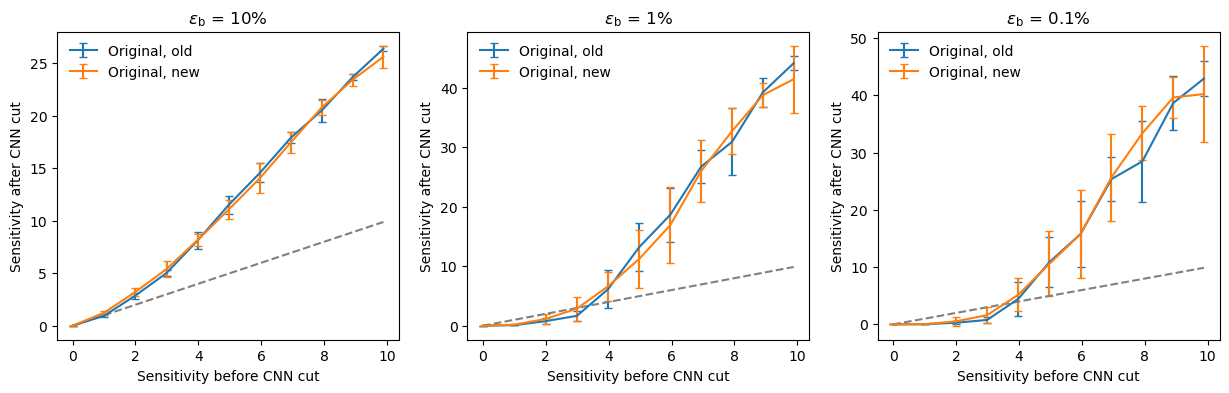

In [ ]:
df = pd.read_csv('./CWoLa_Hunting_Hidden_Valley_training_results-2.csv')
sensitivities_origin_old, stds_origin_old = get_realistic_sensitivity_and_std('SB_{:.1f}_25x25')

df = pd.read_csv('./CWoLa_Hunting_Hidden_Valley_training_results-3.csv')
sensitivities_origin, stds_origin = get_realistic_sensitivity_and_std('SB_{:.1f}_25x25')

sensitivities = convert_to_realistic_sensitivity(np.arange(11), nB=n_bkg_in_SR)

fig, ax = plt.subplots(1, 3, figsize=(15, 4))

titles = ['$\epsilon_\mathrm{b}$ = 10%', '$\epsilon_\mathrm{b}$ = 1%', '$\epsilon_\mathrm{b}$ = 0.1%']
for i in range(3):

    ax[i].errorbar(sensitivities, sensitivities_origin_old[i], yerr=stds_origin_old[i], marker='', capsize=3, label='Original, old')
    ax[i].errorbar(sensitivities, sensitivities_origin[i], yerr=stds_origin[i], marker='', capsize=3, label='Original, new')

    ax[i].plot(sensitivities, sensitivities, '--', color='grey')

    ax[i].set_title(titles[i])
    ax[i].set_xlabel('Sensitivity before CNN cut')
    ax[i].set_ylabel('Sensitivity after CNN cut')

    ax[i].legend(frameon=False, loc='upper left')

plt.savefig('../figures/HVmodel_sensitivity_improvement_origin_resample_res_25.pdf', dpi=300, facecolor='White', bbox_inches='tight')
plt.show()

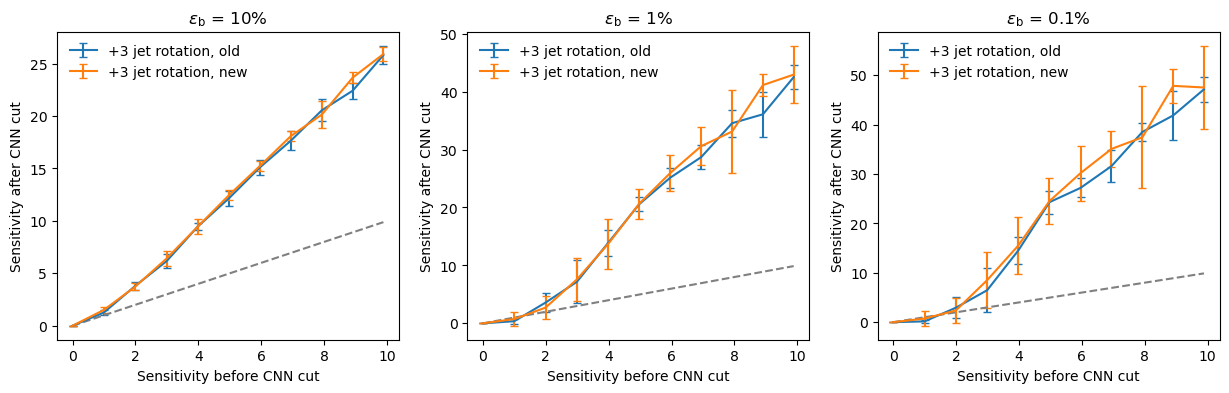

In [ ]:
df = pd.read_csv('./CWoLa_Hunting_Hidden_Valley_training_results-2.csv')
sensitivities_jet_aug_old, stds_jet_aug_old = get_realistic_sensitivity_and_std('SB_{:.1f}_jet_aug_3_25x25')

df = pd.read_csv('./CWoLa_Hunting_Hidden_Valley_training_results-3.csv')
sensitivities_jet_aug, stds_jet_aug = get_realistic_sensitivity_and_std('SB_{:.1f}_jet_aug_3_25x25')

sensitivities = convert_to_realistic_sensitivity(np.arange(11), nB=n_bkg_in_SR)

fig, ax = plt.subplots(1, 3, figsize=(15, 4))

titles = ['$\epsilon_\mathrm{b}$ = 10%', '$\epsilon_\mathrm{b}$ = 1%', '$\epsilon_\mathrm{b}$ = 0.1%']
for i in range(3):

    ax[i].errorbar(sensitivities, sensitivities_jet_aug_old[i], yerr=stds_jet_aug_old[i], marker='', capsize=3, label='+3 jet rotation, old')
    ax[i].errorbar(sensitivities, sensitivities_jet_aug[i], yerr=stds_jet_aug[i], marker='', capsize=3, label='+3 jet rotation, new')

    ax[i].plot(sensitivities, sensitivities, '--', color='grey')

    ax[i].set_title(titles[i])
    ax[i].set_xlabel('Sensitivity before CNN cut')
    ax[i].set_ylabel('Sensitivity after CNN cut')

    ax[i].legend(frameon=False, loc='upper left')

plt.savefig('../figures/HVmodel_sensitivity_improvement_jet_aug_3_resample_res_25.pdf', dpi=300, facecolor='White', bbox_inches='tight')
plt.show()

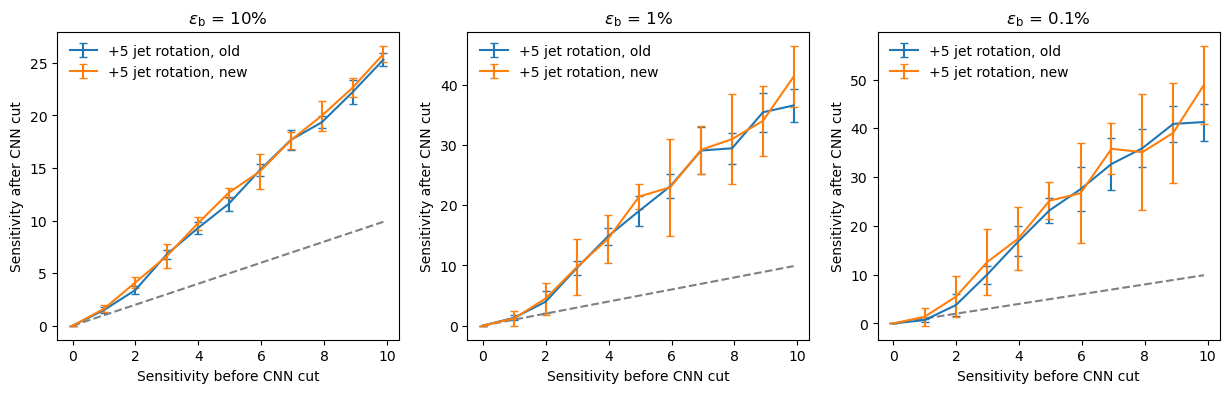

In [ ]:
df = pd.read_csv('./CWoLa_Hunting_Hidden_Valley_training_results-2.csv')
sensitivities_jet_aug_old, stds_jet_aug_old = get_realistic_sensitivity_and_std('SB_{:.1f}_jet_aug_5_25x25')

df = pd.read_csv('./CWoLa_Hunting_Hidden_Valley_training_results-3.csv')
sensitivities_jet_aug, stds_jet_aug = get_realistic_sensitivity_and_std('SB_{:.1f}_jet_aug_5_25x25')

sensitivities = convert_to_realistic_sensitivity(np.arange(11), nB=n_bkg_in_SR)

fig, ax = plt.subplots(1, 3, figsize=(15, 4))

titles = ['$\epsilon_\mathrm{b}$ = 10%', '$\epsilon_\mathrm{b}$ = 1%', '$\epsilon_\mathrm{b}$ = 0.1%']
for i in range(3):

    ax[i].errorbar(sensitivities, sensitivities_jet_aug_old[i], yerr=stds_jet_aug_old[i], marker='', capsize=3, label='+5 jet rotation, old')
    ax[i].errorbar(sensitivities, sensitivities_jet_aug[i], yerr=stds_jet_aug[i], marker='', capsize=3, label='+5 jet rotation, new')

    ax[i].plot(sensitivities, sensitivities, '--', color='grey')

    ax[i].set_title(titles[i])
    ax[i].set_xlabel('Sensitivity before CNN cut')
    ax[i].set_ylabel('Sensitivity after CNN cut')

    ax[i].legend(frameon=False, loc='upper left')

plt.savefig('../figures/HVmodel_sensitivity_improvement_jet_aug_5_resample_res_25.pdf', dpi=300, facecolor='White', bbox_inches='tight')
plt.show()

# $\eta-\phi$ + $p_\text{T}$ smearing + Jet rotation 

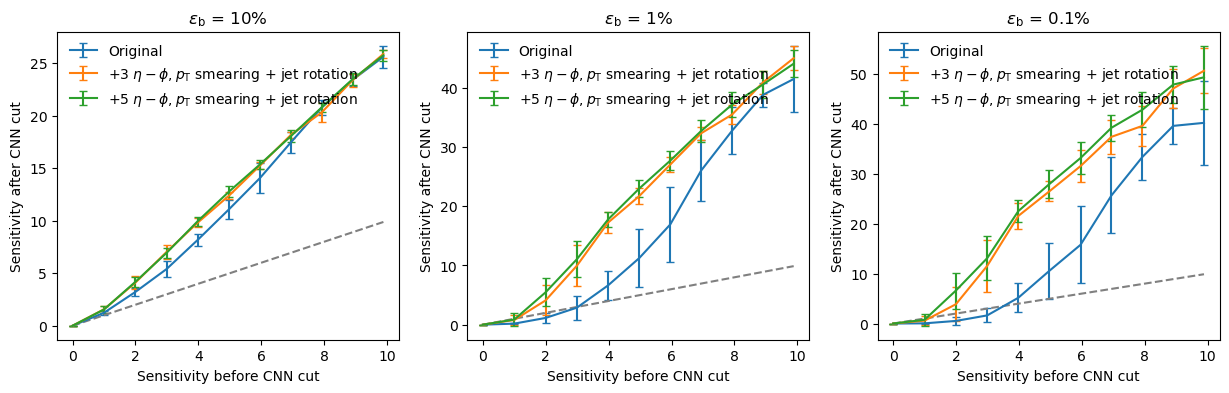

In [ ]:
sensitivities_origin, stds_origin = get_realistic_sensitivity_and_std('SB_{:.1f}_25x25')
sensitivities_eta_phi_pt_jet_aug_3, stds_eta_phi_pt_jet_aug_3 = get_realistic_sensitivity_and_std('SB_{:.1f}_eta_phi_pt_jet_aug_3_25x25')
sensitivities_eta_phi_pt_jet_aug_5, stds_eta_phi_pt_jet_aug_5 = get_realistic_sensitivity_and_std('SB_{:.1f}_eta_phi_pt_jet_aug_5_25x25')

sensitivities = convert_to_realistic_sensitivity(np.arange(11), nB=n_bkg_in_SR)

fig, ax = plt.subplots(1, 3, figsize=(15, 4))

titles = ['$\epsilon_\mathrm{b}$ = 10%', '$\epsilon_\mathrm{b}$ = 1%', '$\epsilon_\mathrm{b}$ = 0.1%']
for i in range(3):
    ax[i].errorbar(sensitivities, sensitivities_origin[i], yerr=stds_origin[i], marker='', capsize=3, label='Original')

    ax[i].errorbar(sensitivities, sensitivities_eta_phi_pt_jet_aug_3[i], yerr=stds_eta_phi_pt_jet_aug_3[i], marker='', capsize=3, label='+3 $\eta-\phi, p_\mathrm{T}$ smearing + jet rotation')
    ax[i].errorbar(sensitivities, sensitivities_eta_phi_pt_jet_aug_5[i], yerr=stds_eta_phi_pt_jet_aug_5[i], marker='', capsize=3, label='+5 $\eta-\phi, p_\mathrm{T}$ smearing + jet rotation')

    ax[i].plot(sensitivities, sensitivities, '--', color='grey')

    ax[i].set_title(titles[i])
    ax[i].set_xlabel('Sensitivity before CNN cut')
    ax[i].set_ylabel('Sensitivity after CNN cut')

    ax[i].legend(frameon=False, loc='upper left')

plt.savefig('../figures/HVmodel_sensitivity_improvement_origin_eta_phi_pt_jet_aug_3_5_res_25.pdf', dpi=300, facecolor='White', bbox_inches='tight')
plt.show()

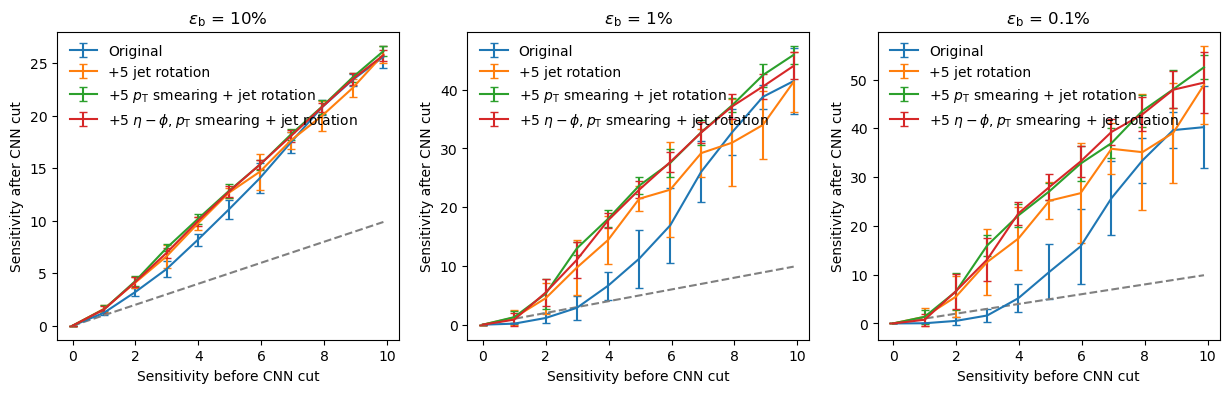

In [ ]:
sensitivities_origin, stds_origin = get_realistic_sensitivity_and_std('SB_{:.1f}_25x25')
sensitivities_jet_aug, stds_jet_aug = get_realistic_sensitivity_and_std('SB_{:.1f}_jet_aug_5_25x25')
sensitivities_pt_jet_aug, stds_pt_jet_aug = get_realistic_sensitivity_and_std('SB_{:.1f}_pt_jet_aug_5_25x25')
sensitivities_eta_phi_pt_jet_aug, stds_eta_phi_pt_jet_aug = get_realistic_sensitivity_and_std('SB_{:.1f}_eta_phi_pt_jet_aug_5_25x25')

sensitivities = convert_to_realistic_sensitivity(np.arange(11), nB=n_bkg_in_SR)

fig, ax = plt.subplots(1, 3, figsize=(15, 4))

titles = ['$\epsilon_\mathrm{b}$ = 10%', '$\epsilon_\mathrm{b}$ = 1%', '$\epsilon_\mathrm{b}$ = 0.1%']
for i in range(3):
    ax[i].errorbar(sensitivities, sensitivities_origin[i], yerr=stds_origin[i], marker='', capsize=3, label='Original')

    ax[i].errorbar(sensitivities, sensitivities_jet_aug[i], yerr=stds_jet_aug[i], marker='', capsize=3, label='+5 jet rotation')
    ax[i].errorbar(sensitivities, sensitivities_pt_jet_aug[i], yerr=stds_pt_jet_aug[i], marker='', capsize=3, label='+5 $p_\mathrm{T}$ smearing + jet rotation')
    ax[i].errorbar(sensitivities, sensitivities_eta_phi_pt_jet_aug[i], yerr=stds_eta_phi_pt_jet_aug[i], marker='', capsize=3, label='+5 $\eta-\phi, p_\mathrm{T}$ smearing + jet rotation')

    ax[i].plot(sensitivities, sensitivities, '--', color='grey')

    ax[i].set_title(titles[i])
    ax[i].set_xlabel('Sensitivity before CNN cut')
    ax[i].set_ylabel('Sensitivity after CNN cut')

    ax[i].legend(frameon=False, loc='upper left')

plt.savefig('../figures/HVmodel_sensitivity_improvement_origin_eta_phi_pt_jet_aug_5_res_25.pdf', dpi=300, facecolor='White', bbox_inches='tight')
plt.show()

# Asymptotic behaviour

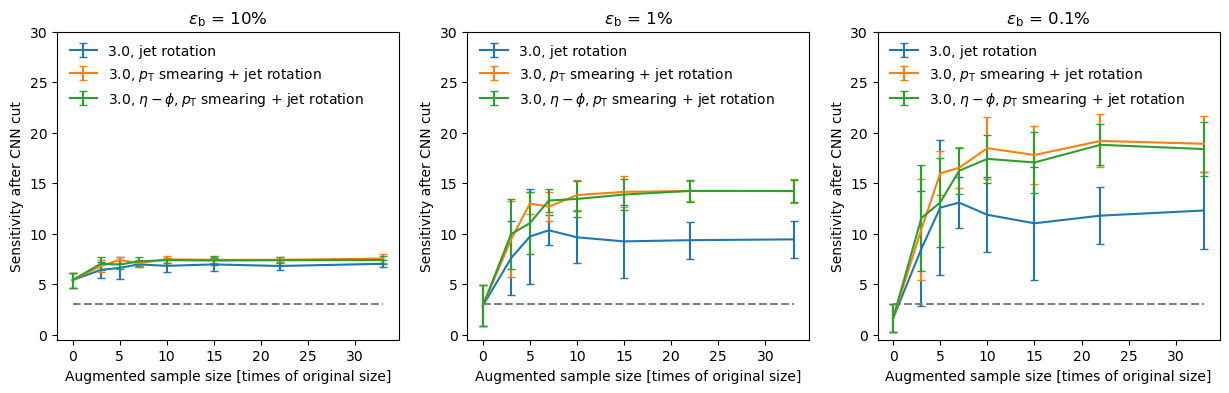

In [ ]:
sample_size = [3, 5, 7, 10, 15, 22, 33]
res = 25
models = [f'SB_3.0_{res}x{res}'] + [f'SB_3.0_jet_aug_{n}_{res}x{res}' for n in sample_size]
sensitivities_jet_aug_3, stds_jet_aug_3 = get_realistic_sensitivity_and_std_from_models(models, sensitivity=3.0)

models = [f'SB_3.0_{res}x{res}'] + [f'SB_3.0_pt_jet_aug_{n}_{res}x{res}' for n in sample_size]
sensitivities_pt_jet_aug_3, stds_pt_jet_aug_3 = get_realistic_sensitivity_and_std_from_models(models, sensitivity=3.0)

models = [f'SB_3.0_{res}x{res}'] + [f'SB_3.0_eta_phi_pt_jet_aug_{n}_{res}x{res}' for n in sample_size]
sensitivities_eta_phi_pt_jet_aug_3, stds_eta_phi_pt_jet_aug_3 = get_realistic_sensitivity_and_std_from_models(models, sensitivity=3.0)

fig, ax = plt.subplots(1, 3, figsize=(15, 4))

titles = ['$\epsilon_\mathrm{b}$ = 10%', '$\epsilon_\mathrm{b}$ = 1%', '$\epsilon_\mathrm{b}$ = 0.1%']
for i in range(3):

    ax[i].errorbar([0] + sample_size, sensitivities_jet_aug_3[i], yerr=stds_jet_aug_3[i], marker='', capsize=3, label='3.0, jet rotation')
    ax[i].errorbar([0] + sample_size, sensitivities_pt_jet_aug_3[i], yerr=stds_pt_jet_aug_3[i], marker='', capsize=3, label='3.0, $p_\mathrm{T}$ smearing + jet rotation')
    ax[i].errorbar([0] + sample_size, sensitivities_eta_phi_pt_jet_aug_3[i], yerr=stds_eta_phi_pt_jet_aug_3[i], marker='', capsize=3, label='3.0, $\eta-\phi, p_\mathrm{T}$ smearing + jet rotation')

    ax[i].set_title(titles[i])
    ax[i].hlines(3, 0, sample_size[-1], color='gray', linestyle='--')
    ax[i].set_ylim(-0.5, 30)
    ax[i].set_xlabel('Augmented sample size [times of original size]')
    ax[i].set_ylabel('Sensitivity after CNN cut')

    ax[i].legend(frameon=False, loc='upper left')

plt.savefig(f'../figures/HVmodel_sensitivity_improvement_summary_aug_3_to_33_SB_3_res_{res}.pdf', dpi=300, facecolor='White', bbox_inches='tight')
plt.show()

# Only shift to $p_\text{T}$ center

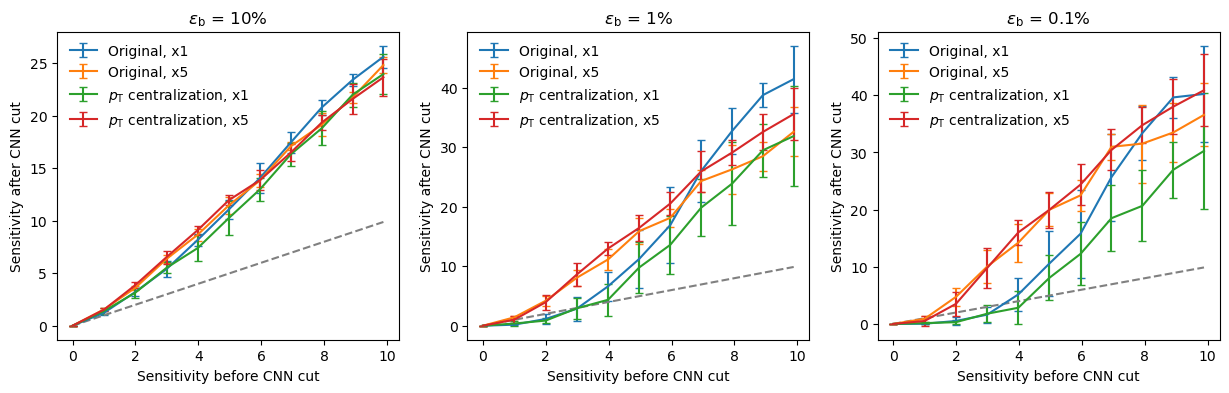

In [ ]:
sensitivities_origin, stds_origin = get_realistic_sensitivity_and_std('SB_{:.1f}_25x25')
sensitivities_origin_x5, stds_origin_x5 = get_realistic_sensitivity_and_std('SB_{:.1f}_x5_25x25')
sensitivities_pt_center_x1, stds_pt_center_x1 = get_realistic_sensitivity_and_std('SB_{:.1f}_pt_center_x1_25x25')
sensitivities_pt_center_x5, stds_pt_center_x5 = get_realistic_sensitivity_and_std('SB_{:.1f}_pt_center_x5_25x25')

sensitivities = convert_to_realistic_sensitivity(np.arange(11), nB=n_bkg_in_SR)

fig, ax = plt.subplots(1, 3, figsize=(15, 4))

titles = ['$\epsilon_\mathrm{b}$ = 10%', '$\epsilon_\mathrm{b}$ = 1%', '$\epsilon_\mathrm{b}$ = 0.1%']
for i in range(3):
    ax[i].errorbar(sensitivities, sensitivities_origin[i], yerr=stds_origin[i], marker='', capsize=3, label='Original, x1')
    ax[i].errorbar(sensitivities, sensitivities_origin_x5[i], yerr=stds_origin_x5[i], marker='', capsize=3, label='Original, x5')

    ax[i].errorbar(sensitivities, sensitivities_pt_center_x1[i], yerr=stds_pt_center_x1[i], marker='', capsize=3, label='$p_\mathrm{T}$ centralization, x1')
    ax[i].errorbar(sensitivities, sensitivities_pt_center_x5[i], yerr=stds_pt_center_x5[i], marker='', capsize=3, label='$p_\mathrm{T}$ centralization, x5')

    ax[i].plot(sensitivities, sensitivities, '--', color='grey')

    ax[i].set_title(titles[i])
    ax[i].set_xlabel('Sensitivity before CNN cut')
    ax[i].set_ylabel('Sensitivity after CNN cut')

    ax[i].legend(frameon=False, loc='upper left')

plt.savefig('../figures/HVmodel_sensitivity_improvement_origin_pt_centralization_x1_x5_res_25.pdf', dpi=300, facecolor='White', bbox_inches='tight')
plt.show()

# Background subtraction

/tmp/ipykernel_2291918/2813646834.py:39: RuntimeWarning: Mean of empty slice.
  sensitivities[j].append(real_sensitivities.mean())
/home/r10222035/.conda/envs/jupyter/lib/python3.8/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/home/r10222035/.conda/envs/jupyter/lib/python3.8/site-packages/numpy/core/_methods.py:269: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/r10222035/.conda/envs/jupyter/lib/python3.8/site-packages/numpy/core/_methods.py:226: RuntimeWarning: invalid value encountered in divide
  arrmean = um.true_divide(arrmean, div, out=arrmean,
/home/r10222035/.conda/envs/jupyter/lib/python3.8/site-packages/numpy/core/_methods.py:261: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/home/r10222035/.conda/envs/jupyter/lib/python3.8/site-packages/numpy/core/_methods.py:45: Ru

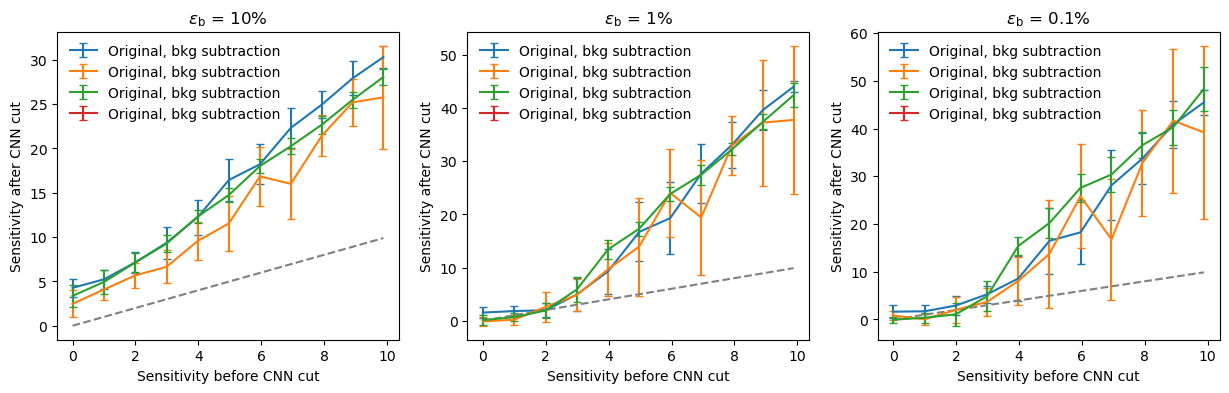

In [ ]:
sensitivities_origin, stds_origin = get_realistic_sensitivity_and_std_bkg_subtraction('SB_{:.1f}_25x25')
sensitivities_origin_dp_025, stds_origin_dp_025 = get_realistic_sensitivity_and_std_bkg_subtraction('SB_{:.1f}_25x25_dp_025')
sensitivities_origin_dp_035, stds_origin_dp_035 = get_realistic_sensitivity_and_std_bkg_subtraction('SB_{:.1f}_25x25_dp_035')
# sensitivities_origin_dp_035_l2_0001, stds_origin_dp_035_l2_0001 = get_realistic_sensitivity_and_std_bkg_subtraction('SB_{:.1f}_25x25_dp_035_l2_0001')
sensitivities_origin_dp_035_CNN_l2_0001, stds_origin_dp_035_CNN_l2_0001 = get_realistic_sensitivity_and_std_bkg_subtraction('SB_{:.1f}_25x25_dp_035_CNN_l2_0001')
sensitivities_origin_old, stds_origin_old = get_realistic_sensitivity_and_std('SB_{:.1f}_25x25')

sensitivities = convert_to_realistic_sensitivity(np.arange(11), nB=n_bkg_in_SR)

fig, ax = plt.subplots(1, 3, figsize=(15, 4))

titles = ['$\epsilon_\mathrm{b}$ = 10%', '$\epsilon_\mathrm{b}$ = 1%', '$\epsilon_\mathrm{b}$ = 0.1%']
for i in range(3):
    ax[i].errorbar(sensitivities, sensitivities_origin[i], yerr=stds_origin[i], marker='', capsize=3, label='Original, bkg subtraction')
    # ax[i].errorbar(sensitivities, sensitivities_origin_dp_025[i], yerr=stds_origin_dp_025[i], marker='', capsize=3, label='Original, bkg subtraction')
    ax[i].errorbar(sensitivities, sensitivities_origin_dp_035[i], yerr=stds_origin_dp_035[i], marker='', capsize=3, label='Original, bkg subtraction')
    # ax[i].errorbar(sensitivities, sensitivities_origin_dp_035_l2_0001[i], yerr=stds_origin_dp_035_l2_0001[i], marker='', capsize=3, label='Original, bkg subtraction')
    ax[i].errorbar(sensitivities, sensitivities_origin_dp_035_CNN_l2_0001[i], yerr=stds_origin_dp_035_CNN_l2_0001[i], marker='', capsize=3, label='Original, bkg subtraction')
    # ax[i].errorbar(sensitivities, sensitivities_origin_old[i], yerr=stds_origin_old[i], marker='', capsize=3, label='Original, true label')

    ax[i].plot(sensitivities, sensitivities, '--', color='grey')

    ax[i].set_title(titles[i])
    ax[i].set_xlabel('Sensitivity before CNN cut')
    ax[i].set_ylabel('Sensitivity after CNN cut')

    ax[i].legend(frameon=False, loc='upper left')

# plt.savefig('../figures/HVmodel_sensitivity_improvement_origin_bkg_subtraction_true_label.pdf', dpi=300, facecolor='White', bbox_inches='tight')
plt.show()

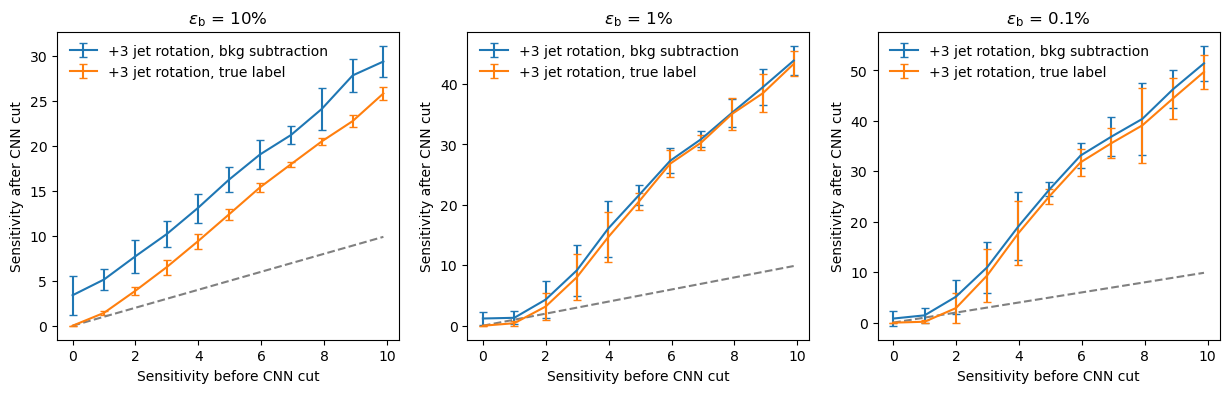

In [ ]:
sensitivities_jet_aug_3, stds_jet_aug_3 = get_realistic_sensitivity_and_std_bkg_subtraction('SB_{:.1f}_jet_aug_3_25x25')

sensitivities_jet_aug_3_old, stds_jet_aug_3_old = get_realistic_sensitivity_and_std('SB_{:.1f}_jet_aug_3_25x25')

sensitivities = convert_to_realistic_sensitivity(np.arange(11), nB=n_bkg_in_SR)

fig, ax = plt.subplots(1, 3, figsize=(15, 4))

titles = ['$\epsilon_\mathrm{b}$ = 10%', '$\epsilon_\mathrm{b}$ = 1%', '$\epsilon_\mathrm{b}$ = 0.1%']
for i in range(3):
    ax[i].errorbar(sensitivities, sensitivities_jet_aug_3[i], yerr=stds_jet_aug_3[i], marker='', capsize=3, label='+3 jet rotation, bkg subtraction')
    ax[i].errorbar(sensitivities, sensitivities_jet_aug_3_old[i], yerr=stds_jet_aug_3_old[i], marker='', capsize=3, label='+3 jet rotation, true label')

    ax[i].plot(sensitivities, sensitivities, '--', color='grey')

    ax[i].set_title(titles[i])
    ax[i].set_xlabel('Sensitivity before CNN cut')
    ax[i].set_ylabel('Sensitivity after CNN cut')

    ax[i].legend(frameon=False, loc='upper left')

plt.savefig('../figures/HVmodel_sensitivity_improvement_jet_aug_3_bkg_subtraction_true_label.pdf', dpi=300, facecolor='White', bbox_inches='tight')
plt.show()

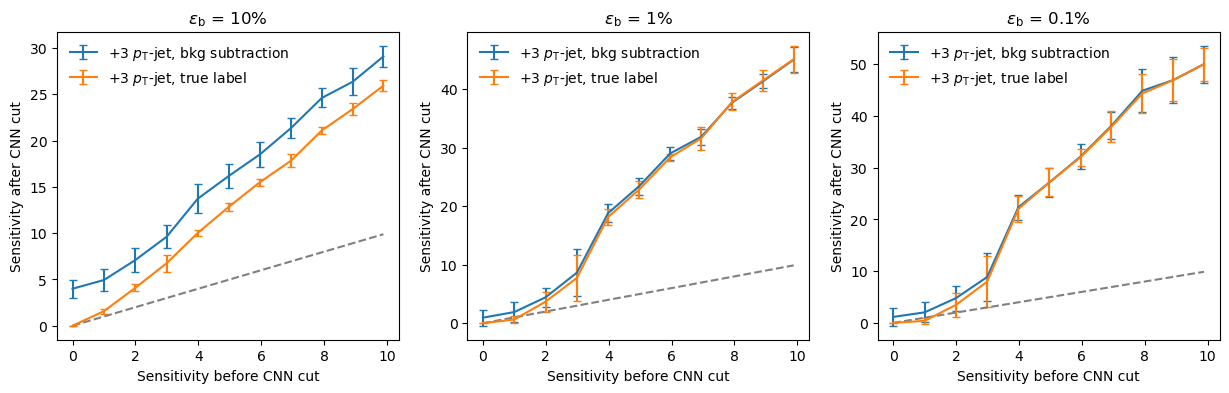

In [ ]:
sensitivities_pt_jet_aug_3, stds_pt_jet_aug_3 = get_realistic_sensitivity_and_std_bkg_subtraction('SB_{:.1f}_pt_jet_aug_3_25x25')
sensitivities_pt_jet_aug_3_old, stds_pt_jet_aug_3_old = get_realistic_sensitivity_and_std('SB_{:.1f}_pt_jet_aug_3_25x25')

sensitivities = convert_to_realistic_sensitivity(np.arange(11), nB=n_bkg_in_SR)

fig, ax = plt.subplots(1, 3, figsize=(15, 4))

titles = ['$\epsilon_\mathrm{b}$ = 10%', '$\epsilon_\mathrm{b}$ = 1%', '$\epsilon_\mathrm{b}$ = 0.1%']
for i in range(3):
    ax[i].errorbar(sensitivities, sensitivities_pt_jet_aug_3[i], yerr=stds_pt_jet_aug_3[i], marker='', capsize=3, label='+3 $p_\mathrm{T}$-jet, bkg subtraction')
    ax[i].errorbar(sensitivities, sensitivities_pt_jet_aug_3_old[i], yerr=stds_pt_jet_aug_3_old[i], marker='', capsize=3, label='+3 $p_\mathrm{T}$-jet, true label')

    ax[i].plot(sensitivities, sensitivities, '--', color='grey')

    ax[i].set_title(titles[i])
    ax[i].set_xlabel('Sensitivity before CNN cut')
    ax[i].set_ylabel('Sensitivity after CNN cut')

    ax[i].legend(frameon=False, loc='upper left')

plt.savefig('../figures/HVmodel_sensitivity_improvement_pt_jet_aug_3_bkg_subtraction_true_label.pdf', dpi=300, facecolor='White', bbox_inches='tight')
plt.show()

[[4.273963364161078, 5.230728887723404, 7.146776679575623, 9.352374834597734, 12.246074765953153, 16.436342169762504, 18.21133743193601, 22.32025181138204, 24.937245133001774, 27.907355401645088, 30.292587297983278], [1.508375878656988, 1.7971879066081389, 1.9554629361519038, 4.919430209239913, 9.267248329128346, 16.710866237951937, 19.305167202712, 27.687845875281102, 33.13539827500507, 39.6772611383673, 44.07653704519021], [1.6323127223804732, 1.7174226252760973, 2.9246458800440034, 5.283022092105614, 8.599186126289757, 16.481044983582244, 18.257075885458374, 28.116787649149188, 33.712143605929626, 40.84394253517206, 45.50353907281017]]


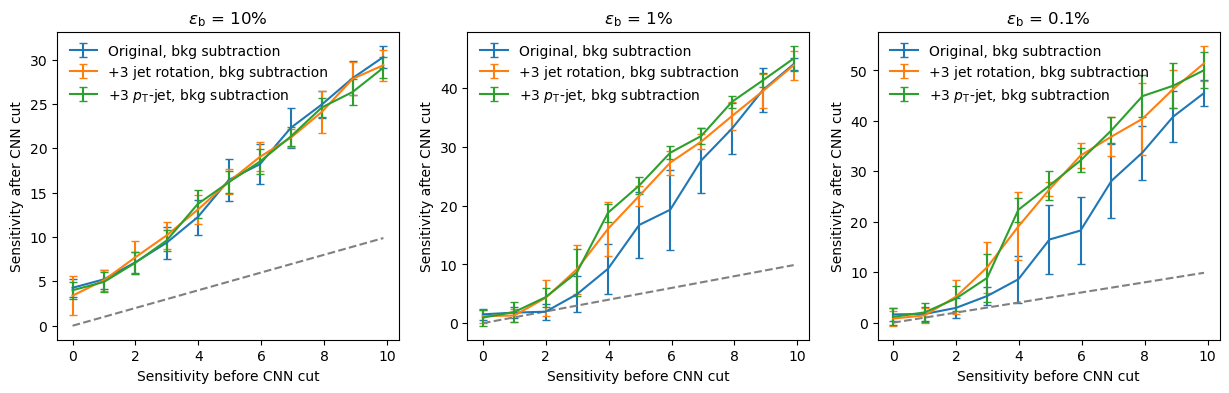

In [ ]:
sensitivities_origin, stds_origin = get_realistic_sensitivity_and_std_bkg_subtraction('SB_{:.1f}_25x25')
sensitivities_jet_aug_3, stds_jet_aug_3 = get_realistic_sensitivity_and_std_bkg_subtraction('SB_{:.1f}_jet_aug_3_25x25')
sensitivities_pt_jet_aug_3, stds_pt_jet_aug_3 = get_realistic_sensitivity_and_std_bkg_subtraction('SB_{:.1f}_pt_jet_aug_3_25x25')
print(sensitivities_origin)
sensitivities = convert_to_realistic_sensitivity(np.arange(11), nB=n_bkg_in_SR)

fig, ax = plt.subplots(1, 3, figsize=(15, 4))

titles = ['$\epsilon_\mathrm{b}$ = 10%', '$\epsilon_\mathrm{b}$ = 1%', '$\epsilon_\mathrm{b}$ = 0.1%']
for i in range(3):
    ax[i].errorbar(sensitivities, sensitivities_origin[i], yerr=stds_origin[i], marker='', capsize=3, label='Original, bkg subtraction')
    ax[i].errorbar(sensitivities, sensitivities_jet_aug_3[i], yerr=stds_jet_aug_3[i], marker='', capsize=3, label='+3 jet rotation, bkg subtraction')
    ax[i].errorbar(sensitivities, sensitivities_pt_jet_aug_3[i], yerr=stds_pt_jet_aug_3[i], marker='', capsize=3, label='+3 $p_\mathrm{T}$-jet, bkg subtraction')

    ax[i].plot(sensitivities, sensitivities, '--', color='grey')

    ax[i].set_title(titles[i])
    ax[i].set_xlabel('Sensitivity before CNN cut')
    ax[i].set_ylabel('Sensitivity after CNN cut')

    ax[i].legend(frameon=False, loc='upper left')

# plt.savefig('../figures/HVmodel_sensitivity_improvement_origin_jet_aug_3_pt_jet_aug_3_bkg_subtraction.pdf', dpi=300, facecolor='White', bbox_inches='tight')
plt.show()

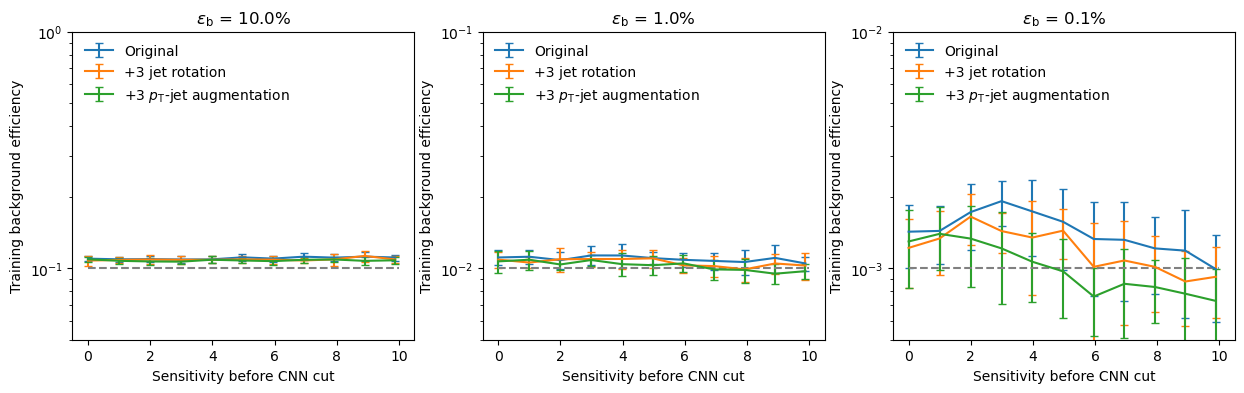

In [ ]:
n_train_S_origin, n_train_B_origin, n_test_B_origin = get_train_test_event_numbers('SB_{:.1f}_25x25')
n_train_S_origin_jet_aug_3, n_train_B_origin_jet_aug_3, n_test_B_origin_jet_aug_3 = get_train_test_event_numbers('SB_{:.1f}_jet_aug_3_25x25')
n_train_S_origin_pt_jet_aug_3, n_train_B_origin_pt_jet_aug_3, n_test_B_origin_pt_jet_aug_3 = get_train_test_event_numbers('SB_{:.1f}_pt_jet_aug_3_25x25')

fig, ax = plt.subplots(1, 3, figsize=(15, 4))

efficiencies = [0.1, 0.01, 0.001]
sensitivities = convert_to_realistic_sensitivity(np.arange(11), nB=n_bkg_in_SR)

titles = ['$\epsilon_\mathrm{b}$ = ' + f'{eff * 100}%' for eff in efficiencies]
for i in range(3):
    test_bkg_eff = efficiencies[i]
    train_bkg_eff_origin = n_train_B_origin[i] / n_test_B_origin[i,:,0][:, None] * test_bkg_eff
    train_bkg_eff_origin_jet_aug_3 = n_train_B_origin_jet_aug_3[i] / n_test_B_origin_jet_aug_3[i,:,0][:, None] * test_bkg_eff
    train_bkg_eff_origin_pt_jet_aug_3 = n_train_B_origin_pt_jet_aug_3[i] / n_test_B_origin_pt_jet_aug_3[i,:,0][:, None] * test_bkg_eff

    ax[i].errorbar(sensitivities, train_bkg_eff_origin[:,0], yerr=train_bkg_eff_origin[:,1], marker='', capsize=3, label='Original')
    ax[i].errorbar(sensitivities, train_bkg_eff_origin_jet_aug_3[:,0], yerr=train_bkg_eff_origin_jet_aug_3[:,1], marker='', capsize=3, label='+3 jet rotation')
    ax[i].errorbar(sensitivities, train_bkg_eff_origin_pt_jet_aug_3[:,0], yerr=train_bkg_eff_origin_pt_jet_aug_3[:,1], marker='', capsize=3, label='+3 $p_\mathrm{T}$-jet augmentation')

    ax[i].hlines(test_bkg_eff, 0, 10, color='gray', linestyle='--')

    ax[i].set_title(titles[i])
    ax[i].set_xlabel('Sensitivity before CNN cut')
    ax[i].set_ylabel('Training background efficiency')

    ax[i].set_ylim(test_bkg_eff * 0.5, test_bkg_eff * 10)
    ax[i].set_yscale('log')

    ax[i].legend(frameon=False, loc='upper left')

plt.savefig('../figures/HVmodel_train_B_passing_rate_origin_jet_aug_3_pt_jet_aug_3.pdf', dpi=300, facecolor='White', bbox_inches='tight')
plt.show()

# Reduce overfitting on training sample

[[4.273963364161078, 5.230728887723404, 7.146776679575623, 9.352374834597734, 12.246074765953153, 16.436342169762504, 18.21133743193601, 22.32025181138204, 24.937245133001774, 27.907355401645088, 30.292587297983278], [1.508375878656988, 1.7971879066081389, 1.9554629361519038, 4.919430209239913, 9.267248329128346, 16.710866237951937, 19.305167202712, 27.687845875281102, 33.13539827500507, 39.6772611383673, 44.07653704519021], [1.6323127223804732, 1.7174226252760973, 2.9246458800440034, 5.283022092105614, 8.599186126289757, 16.481044983582244, 18.257075885458374, 28.116787649149188, 33.712143605929626, 40.84394253517206, 45.50353907281017]]
[[1.0393197137688428, 1.0962201213628642, 1.151904342072874, 1.806739449819225, 1.9763858817794349, 2.3759199293591013, 2.2484272746436136, 2.2684644150747832, 1.515184787536215, 1.9114708597192176, 1.26898583164058], [0.9854696350619377, 0.9591097308103848, 1.3338639060173172, 3.0535534629438223, 4.265568081047915, 5.57201758551054, 6.831225383855109

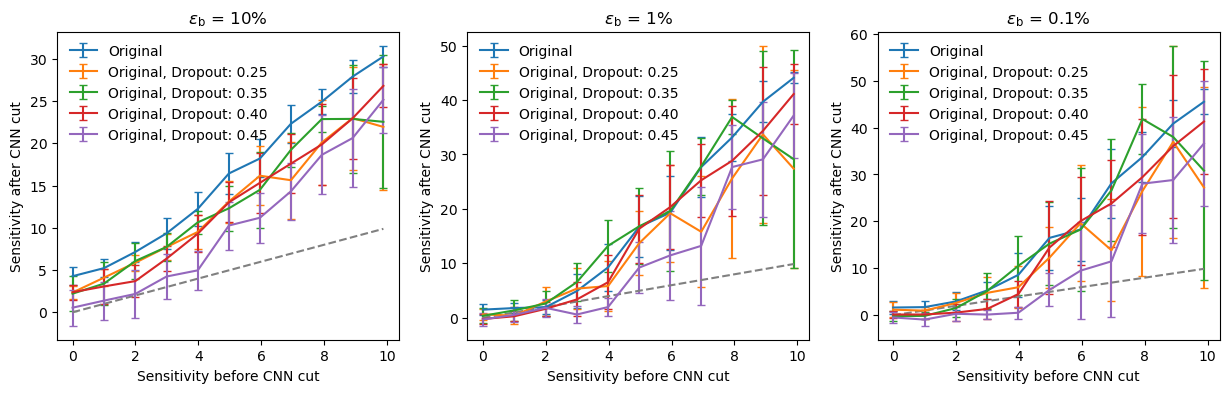

In [ ]:
sensitivities_origin, stds_origin = get_realistic_sensitivity_and_std_bkg_subtraction('SB_{:.1f}_25x25')
sensitivities_origin_dp_025, stds_origin_dp_025 = get_realistic_sensitivity_and_std_bkg_subtraction('SB_{:.1f}_25x25_dp_025')
sensitivities_origin_dp_035, stds_origin_dp_035 = get_realistic_sensitivity_and_std_bkg_subtraction('SB_{:.1f}_25x25_dp_035')
sensitivities_origin_dp_040, stds_origin_dp_040 = get_realistic_sensitivity_and_std_bkg_subtraction('SB_{:.1f}_25x25_dp_040')
sensitivities_origin_dp_045, stds_origin_dp_045 = get_realistic_sensitivity_and_std_bkg_subtraction('SB_{:.1f}_25x25_dp_045')
sensitivities_origin_dp_050, stds_origin_dp_050 = get_realistic_sensitivity_and_std_bkg_subtraction('SB_{:.1f}_25x25_dp_050')

sensitivities = convert_to_realistic_sensitivity(np.arange(11), nB=n_bkg_in_SR)

fig, ax = plt.subplots(1, 3, figsize=(15, 4))

titles = ['$\epsilon_\mathrm{b}$ = 10%', '$\epsilon_\mathrm{b}$ = 1%', '$\epsilon_\mathrm{b}$ = 0.1%']
for i in range(3):
    ax[i].errorbar(sensitivities, sensitivities_origin[i], yerr=stds_origin[i], marker='', capsize=3, label='Original')
    ax[i].errorbar(sensitivities, sensitivities_origin_dp_025[i], yerr=stds_origin_dp_025[i], marker='', capsize=3, label='Original, Dropout: 0.25')
    ax[i].errorbar(sensitivities, sensitivities_origin_dp_035[i], yerr=stds_origin_dp_035[i], marker='', capsize=3, label='Original, Dropout: 0.35')
    ax[i].errorbar(sensitivities, sensitivities_origin_dp_040[i], yerr=stds_origin_dp_040[i], marker='', capsize=3, label='Original, Dropout: 0.40')
    ax[i].errorbar(sensitivities, sensitivities_origin_dp_045[i], yerr=stds_origin_dp_045[i], marker='', capsize=3, label='Original, Dropout: 0.45')
    # ax[i].errorbar(sensitivities, sensitivities_origin_dp_050[i], yerr=stds_origin_dp_050[i], marker='', capsize=3, label='Original, Dropout: 0.50')

    ax[i].plot(sensitivities, sensitivities, '--', color='grey')

    ax[i].set_title(titles[i])
    ax[i].set_xlabel('Sensitivity before CNN cut')
    ax[i].set_ylabel('Sensitivity after CNN cut')

    ax[i].legend(frameon=False, loc='upper left')

# plt.savefig('../figures/HVmodel_sensitivity_improvement_origin_bkg_subtraction_dp_25_35_50.pdf', dpi=300, facecolor='White', bbox_inches='tight')
plt.show()

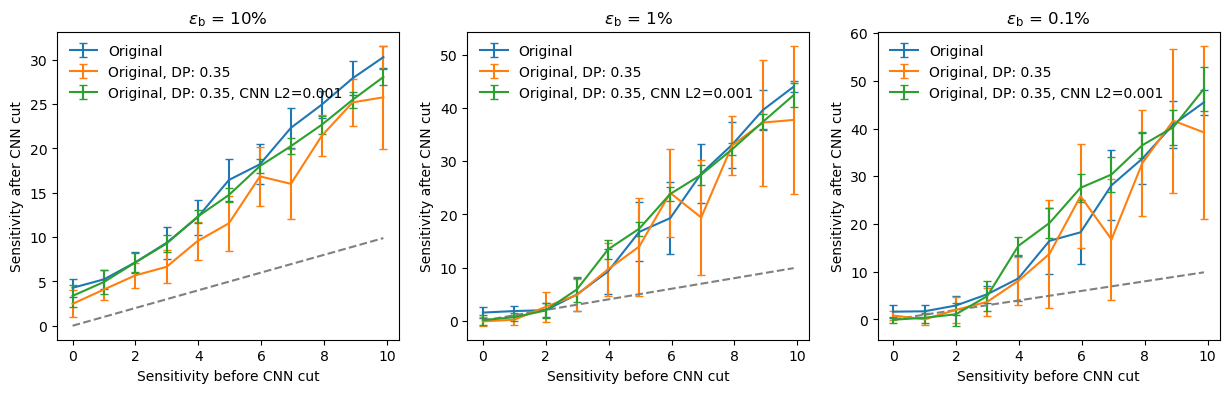

In [ ]:
sensitivities_origin, stds_origin = get_realistic_sensitivity_and_std_bkg_subtraction('SB_{:.1f}_25x25')
sensitivities_origin_dp_035, stds_origin_dp_035 = get_realistic_sensitivity_and_std_bkg_subtraction('SB_{:.1f}_25x25_dp_035')
sensitivities_origin_dp_035_CNN_l2_0001, stds_origin_dp_035_CNN_l2_0001 = get_realistic_sensitivity_and_std_bkg_subtraction('SB_{:.1f}_25x25_dp_035_CNN_l2_0001')

sensitivities = convert_to_realistic_sensitivity(np.arange(11), nB=n_bkg_in_SR)

fig, ax = plt.subplots(1, 3, figsize=(15, 4))

titles = ['$\epsilon_\mathrm{b}$ = 10%', '$\epsilon_\mathrm{b}$ = 1%', '$\epsilon_\mathrm{b}$ = 0.1%']
for i in range(3):
    ax[i].errorbar(sensitivities, sensitivities_origin[i], yerr=stds_origin[i], marker='', capsize=3, label='Original')
    ax[i].errorbar(sensitivities, sensitivities_origin_dp_035[i], yerr=stds_origin_dp_035[i], marker='', capsize=3, label='Original, DP: 0.35')
    ax[i].errorbar(sensitivities, sensitivities_origin_dp_035_CNN_l2_0001[i], yerr=stds_origin_dp_035_CNN_l2_0001[i], marker='', capsize=3, label='Original, DP: 0.35, CNN L2=0.001')

    ax[i].plot(sensitivities, sensitivities, '--', color='grey')

    ax[i].set_title(titles[i])
    ax[i].set_xlabel('Sensitivity before CNN cut')
    ax[i].set_ylabel('Sensitivity after CNN cut')

    ax[i].legend(frameon=False, loc='upper left')

plt.savefig('../figures/HVmodel_sensitivity_improvement_origin_bkg_subtraction_dp_35_CNN_l2_0001.pdf', dpi=300, facecolor='White', bbox_inches='tight')
plt.show()

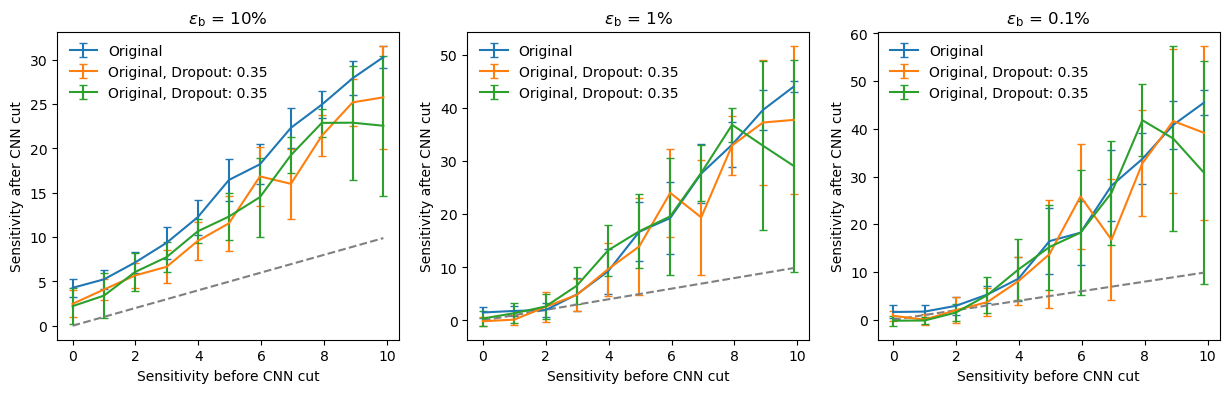

In [ ]:
sensitivities_origin, stds_origin = get_realistic_sensitivity_and_std_bkg_subtraction('SB_{:.1f}_25x25')
sensitivities_origin_dp_035, stds_origin_dp_035 = get_realistic_sensitivity_and_std_bkg_subtraction('SB_{:.1f}_25x25_dp_035', s=slice(0, 10))

sensitivities = convert_to_realistic_sensitivity(np.arange(11), nB=n_bkg_in_SR)

fig, ax = plt.subplots(1, 3, figsize=(15, 4))

titles = ['$\epsilon_\mathrm{b}$ = 10%', '$\epsilon_\mathrm{b}$ = 1%', '$\epsilon_\mathrm{b}$ = 0.1%']
for i in range(3):
    ax[i].errorbar(sensitivities, sensitivities_origin[i], yerr=stds_origin[i], marker='', capsize=3, label='Original')
    ax[i].errorbar(sensitivities, sensitivities_origin_dp_035[i], yerr=stds_origin_dp_035[i], marker='', capsize=3, label='Original, Dropout: 0.35')

    ax[i].plot(sensitivities, sensitivities, '--', color='grey')

    ax[i].set_title(titles[i])
    ax[i].set_xlabel('Sensitivity before CNN cut')
    ax[i].set_ylabel('Sensitivity after CNN cut')

    ax[i].legend(frameon=False, loc='upper left')

# plt.savefig('../figures/HVmodel_sensitivity_improvement_origin_bkg_subtraction_dp_35.pdf', dpi=300, facecolor='White', bbox_inches='tight')
plt.show()

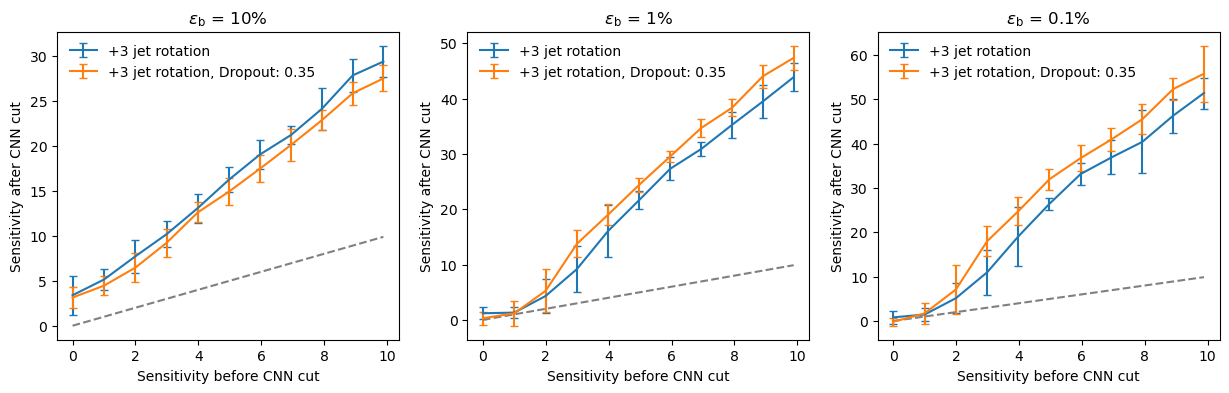

In [ ]:
sensitivities_jet_aug_3, stds_jet_aug_3 = get_realistic_sensitivity_and_std_bkg_subtraction('SB_{:.1f}_jet_aug_3_25x25')
sensitivities_jet_aug_3_dp_035, stds_jet_aug_3_dp_035 = get_realistic_sensitivity_and_std_bkg_subtraction('SB_{:.1f}_jet_aug_3_25x25_dp_035')

sensitivities = convert_to_realistic_sensitivity(np.arange(11), nB=n_bkg_in_SR)

fig, ax = plt.subplots(1, 3, figsize=(15, 4))

titles = ['$\epsilon_\mathrm{b}$ = 10%', '$\epsilon_\mathrm{b}$ = 1%', '$\epsilon_\mathrm{b}$ = 0.1%']
for i in range(3):
    ax[i].errorbar(sensitivities, sensitivities_jet_aug_3[i], yerr=stds_jet_aug_3[i], marker='', capsize=3, label='+3 jet rotation')
    ax[i].errorbar(sensitivities, sensitivities_jet_aug_3_dp_035[i], yerr=stds_jet_aug_3_dp_035[i], marker='', capsize=3, label='+3 jet rotation, Dropout: 0.35')

    ax[i].plot(sensitivities, sensitivities, '--', color='grey')

    ax[i].set_title(titles[i])
    ax[i].set_xlabel('Sensitivity before CNN cut')
    ax[i].set_ylabel('Sensitivity after CNN cut')

    ax[i].legend(frameon=False, loc='upper left')

plt.savefig('../figures/HVmodel_sensitivity_improvement_jet_aug_3_bkg_subtraction_dp_35.pdf', dpi=300, facecolor='White', bbox_inches='tight')
plt.show()

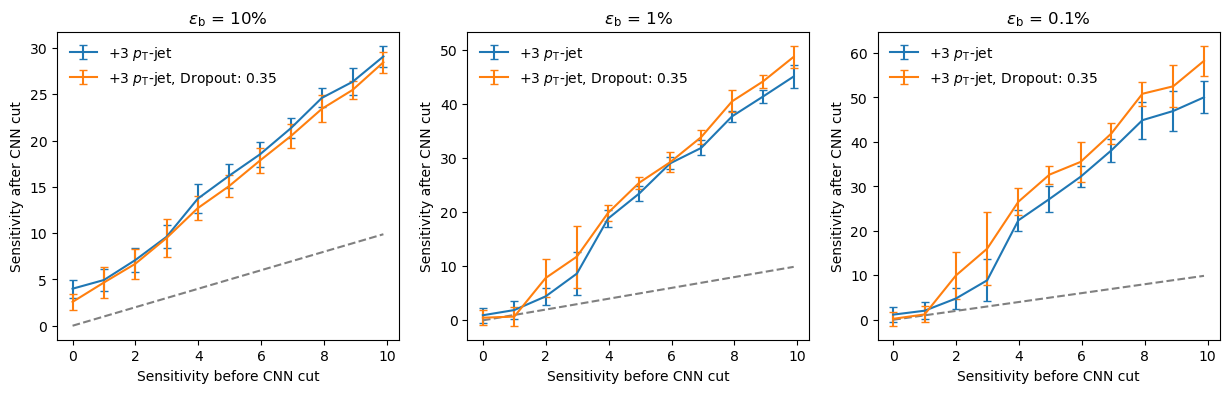

In [ ]:
sensitivitiespt_jet_aug_3, stdspt_jet_aug_3 = get_realistic_sensitivity_and_std_bkg_subtraction('SB_{:.1f}_pt_jet_aug_3_25x25')
sensitivitiespt_jet_aug_3_dp_035, stdspt_jet_aug_3_dp_035 = get_realistic_sensitivity_and_std_bkg_subtraction('SB_{:.1f}_pt_jet_aug_3_25x25_dp_035')

sensitivities = convert_to_realistic_sensitivity(np.arange(11), nB=n_bkg_in_SR)

fig, ax = plt.subplots(1, 3, figsize=(15, 4))

titles = ['$\epsilon_\mathrm{b}$ = 10%', '$\epsilon_\mathrm{b}$ = 1%', '$\epsilon_\mathrm{b}$ = 0.1%']
for i in range(3):
    ax[i].errorbar(sensitivities, sensitivitiespt_jet_aug_3[i], yerr=stdspt_jet_aug_3[i], marker='', capsize=3, label='+3 $p_\mathrm{T}$-jet')
    ax[i].errorbar(sensitivities, sensitivitiespt_jet_aug_3_dp_035[i], yerr=stdspt_jet_aug_3_dp_035[i], marker='', capsize=3, label='+3 $p_\mathrm{T}$-jet, Dropout: 0.35')

    ax[i].plot(sensitivities, sensitivities, '--', color='grey')

    ax[i].set_title(titles[i])
    ax[i].set_xlabel('Sensitivity before CNN cut')
    ax[i].set_ylabel('Sensitivity after CNN cut')

    ax[i].legend(frameon=False, loc='upper left')

plt.savefig('../figures/HVmodel_sensitivity_improvement_pt_jet_aug_3_bkg_subtraction_dp_35.pdf', dpi=300, facecolor='White', bbox_inches='tight')
plt.show()

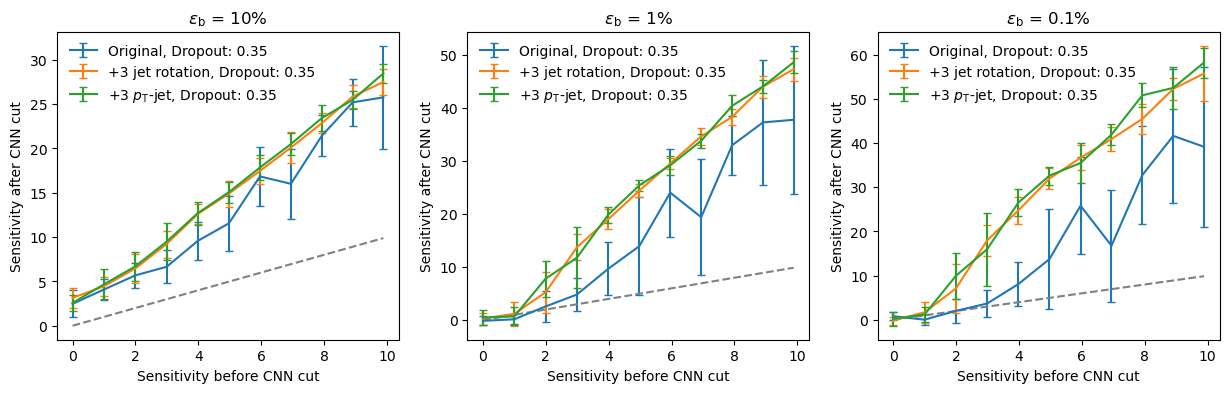

In [ ]:
sensitivities_origin, stds_origin = get_realistic_sensitivity_and_std_bkg_subtraction('SB_{:.1f}_25x25_dp_035')
sensitivities_jet_aug_3, stds_jet_aug_3 = get_realistic_sensitivity_and_std_bkg_subtraction('SB_{:.1f}_jet_aug_3_25x25_dp_035')
sensitivities_pt_jet_aug_3, stds_pt_jet_aug_3 = get_realistic_sensitivity_and_std_bkg_subtraction('SB_{:.1f}_pt_jet_aug_3_25x25_dp_035')

sensitivities = convert_to_realistic_sensitivity(np.arange(11), nB=n_bkg_in_SR)

fig, ax = plt.subplots(1, 3, figsize=(15, 4))

titles = ['$\epsilon_\mathrm{b}$ = 10%', '$\epsilon_\mathrm{b}$ = 1%', '$\epsilon_\mathrm{b}$ = 0.1%']
for i in range(3):
    ax[i].errorbar(sensitivities, sensitivities_origin[i], yerr=stds_origin[i], marker='', capsize=3, label='Original, Dropout: 0.35')
    ax[i].errorbar(sensitivities, sensitivities_jet_aug_3[i], yerr=stds_jet_aug_3[i], marker='', capsize=3, label='+3 jet rotation, Dropout: 0.35')
    ax[i].errorbar(sensitivities, sensitivities_pt_jet_aug_3[i], yerr=stds_pt_jet_aug_3[i], marker='', capsize=3, label='+3 $p_\mathrm{T}$-jet, Dropout: 0.35')

    ax[i].plot(sensitivities, sensitivities, '--', color='grey')

    ax[i].set_title(titles[i])
    ax[i].set_xlabel('Sensitivity before CNN cut')
    ax[i].set_ylabel('Sensitivity after CNN cut')

    ax[i].legend(frameon=False, loc='upper left')

plt.savefig('../figures/HVmodel_sensitivity_improvement_origin_jet_aug_3_pt_jet_aug_3_bkg_subtraction_dp_35.pdf', dpi=300, facecolor='White', bbox_inches='tight')
plt.show()

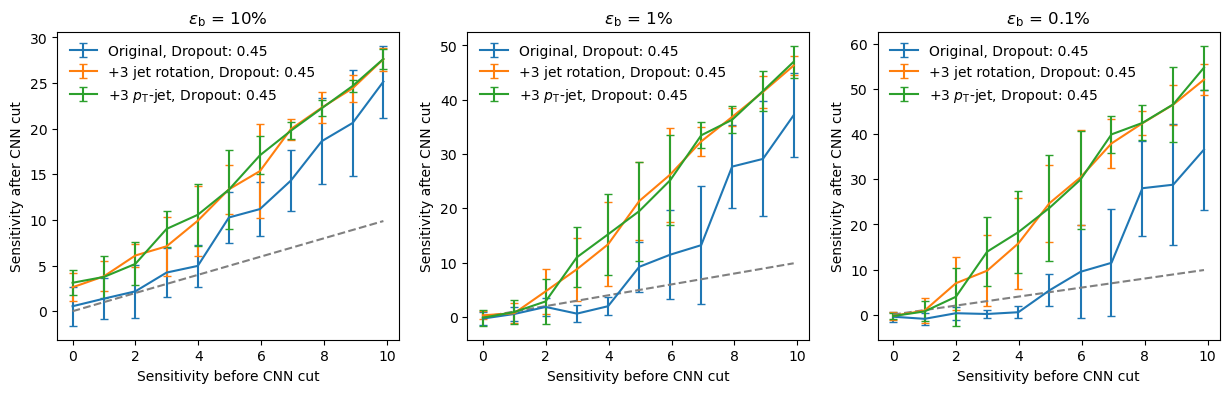

In [ ]:
sensitivities_origin, stds_origin = get_realistic_sensitivity_and_std_bkg_subtraction('SB_{:.1f}_25x25_dp_045')
sensitivities_jet_aug_3, stds_jet_aug_3 = get_realistic_sensitivity_and_std_bkg_subtraction('SB_{:.1f}_jet_aug_3_25x25_dp_045')
sensitivities_pt_jet_aug_3, stds_pt_jet_aug_3 = get_realistic_sensitivity_and_std_bkg_subtraction('SB_{:.1f}_pt_jet_aug_3_25x25_dp_045')

sensitivities = convert_to_realistic_sensitivity(np.arange(11), nB=n_bkg_in_SR)

fig, ax = plt.subplots(1, 3, figsize=(15, 4))

titles = ['$\epsilon_\mathrm{b}$ = 10%', '$\epsilon_\mathrm{b}$ = 1%', '$\epsilon_\mathrm{b}$ = 0.1%']
for i in range(3):
    ax[i].errorbar(sensitivities, sensitivities_origin[i], yerr=stds_origin[i], marker='', capsize=3, label='Original, Dropout: 0.45')
    ax[i].errorbar(sensitivities, sensitivities_jet_aug_3[i], yerr=stds_jet_aug_3[i], marker='', capsize=3, label='+3 jet rotation, Dropout: 0.45')
    ax[i].errorbar(sensitivities, sensitivities_pt_jet_aug_3[i], yerr=stds_pt_jet_aug_3[i], marker='', capsize=3, label='+3 $p_\mathrm{T}$-jet, Dropout: 0.45')

    ax[i].plot(sensitivities, sensitivities, '--', color='grey')

    ax[i].set_title(titles[i])
    ax[i].set_xlabel('Sensitivity before CNN cut')
    ax[i].set_ylabel('Sensitivity after CNN cut')

    ax[i].legend(frameon=False, loc='upper left')

# plt.savefig('../figures/HVmodel_sensitivity_improvement_origin_jet_aug_3_pt_jet_aug_3_bkg_subtraction_dp_45.pdf', dpi=300, facecolor='White', bbox_inches='tight')
plt.show()

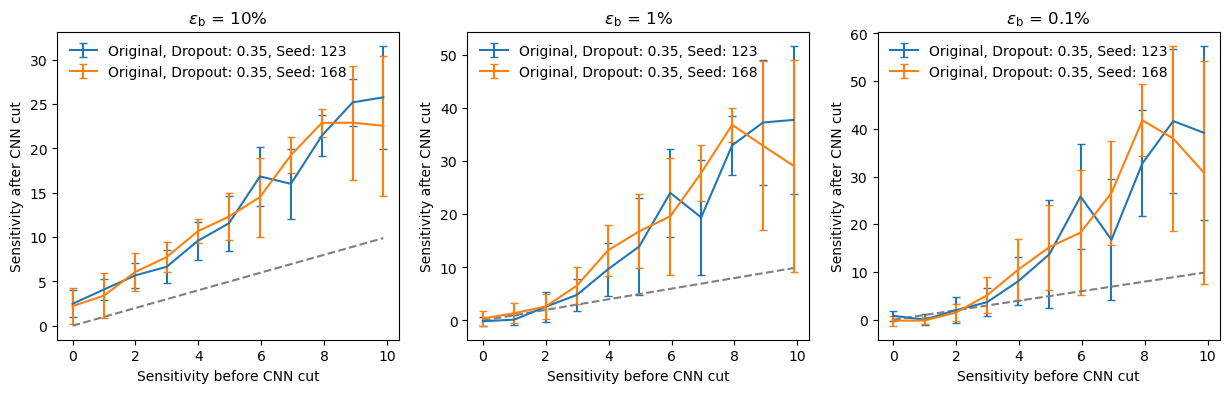

In [ ]:
sensitivities_origin, stds_origin = get_realistic_sensitivity_and_std_bkg_subtraction('SB_{:.1f}_25x25_dp_035', s=slice(0, 10))
sensitivities_origin_2, stds_origin_2 = get_realistic_sensitivity_and_std_bkg_subtraction('SB_{:.1f}_25x25_dp_035', s=slice(10, 20))
# sensitivities_jet_aug_3, stds_jet_aug_3 = get_realistic_sensitivity_and_std_bkg_subtraction('SB_{:.1f}_jet_aug_3_25x25_dp_045')
# sensitivities_pt_jet_aug_3, stds_pt_jet_aug_3 = get_realistic_sensitivity_and_std_bkg_subtraction('SB_{:.1f}_pt_jet_aug_3_25x25_dp_045')

sensitivities = convert_to_realistic_sensitivity(np.arange(11), nB=n_bkg_in_SR)

fig, ax = plt.subplots(1, 3, figsize=(15, 4))

titles = ['$\epsilon_\mathrm{b}$ = 10%', '$\epsilon_\mathrm{b}$ = 1%', '$\epsilon_\mathrm{b}$ = 0.1%']
for i in range(3):
    ax[i].errorbar(sensitivities, sensitivities_origin[i], yerr=stds_origin[i], marker='', capsize=3, label='Original, Dropout: 0.35, Seed: 123')
    ax[i].errorbar(sensitivities, sensitivities_origin_2[i], yerr=stds_origin_2[i], marker='', capsize=3, label='Original, Dropout: 0.35, Seed: 168')
    # ax[i].errorbar(sensitivities, sensitivities_jet_aug_3[i], yerr=stds_jet_aug_3[i], marker='', capsize=3, label='+3 jet rotation, Dropout: 0.45')
    # ax[i].errorbar(sensitivities, sensitivities_pt_jet_aug_3[i], yerr=stds_pt_jet_aug_3[i], marker='', capsize=3, label='+3 $p_\mathrm{T}$-jet, Dropout: 0.45')

    ax[i].plot(sensitivities, sensitivities, '--', color='grey')

    ax[i].set_title(titles[i])
    ax[i].set_xlabel('Sensitivity before CNN cut')
    ax[i].set_ylabel('Sensitivity after CNN cut')

    ax[i].legend(frameon=False, loc='upper left')

# plt.savefig('../figures/HVmodel_sensitivity_improvement_origin_jet_aug_3_pt_jet_aug_3_bkg_subtraction_dp_45.pdf', dpi=300, facecolor='White', bbox_inches='tight')
plt.show()

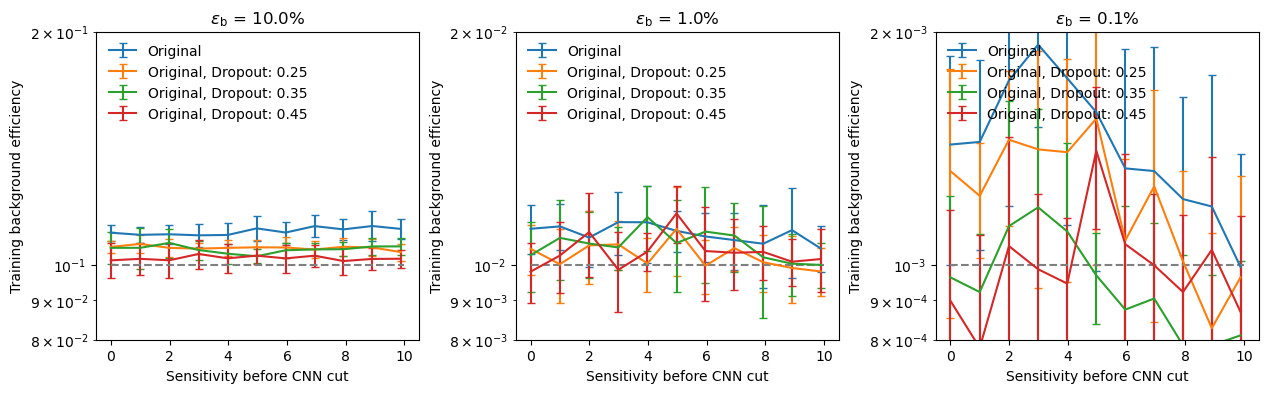

In [ ]:
n_train_S_origin, n_train_B_origin, n_test_B_origin = get_train_test_event_numbers('SB_{:.1f}_25x25')
n_train_S_origin_dp_25, n_train_B_origin_dp_25, n_test_B_origin_dp_25 = get_train_test_event_numbers('SB_{:.1f}_25x25_dp_025')
n_train_S_origin_dp_35, n_train_B_origin_dp_35, n_test_B_origin_dp_35 = get_train_test_event_numbers('SB_{:.1f}_25x25_dp_035')
n_train_S_origin_dp_45, n_train_B_origin_dp_45, n_test_B_origin_dp_45 = get_train_test_event_numbers('SB_{:.1f}_25x25_dp_045')
# n_train_S_origin_dp_50, n_train_B_origin_dp_50, n_test_B_origin_dp_50 = get_train_test_event_numbers('SB_{:.1f}_25x25_dp_050')

# enlarge the sapce between the plots
fig, ax = plt.subplots(1, 3, figsize=(15, 4))
plt.subplots_adjust(wspace=0.3)

efficiencies = [0.1, 0.01, 0.001]
sensitivities = convert_to_realistic_sensitivity(np.arange(11), nB=n_bkg_in_SR)

titles = ['$\epsilon_\mathrm{b}$ = ' + f'{eff * 100}%' for eff in efficiencies]
for i in range(3):
    test_bkg_eff = efficiencies[i]
    train_bkg_eff_origin = n_train_B_origin[i] / n_test_B_origin[i,:,0][:, None] * test_bkg_eff
    train_bkg_eff_origin_dp_25 = n_train_B_origin_dp_25[i] / n_test_B_origin_dp_25[i,:,0][:, None] * test_bkg_eff
    train_bkg_eff_origin_dp_35 = n_train_B_origin_dp_35[i] / n_test_B_origin_dp_35[i,:,0][:, None] * test_bkg_eff
    train_bkg_eff_origin_dp_45 = n_train_B_origin_dp_45[i] / n_test_B_origin_dp_45[i,:,0][:, None] * test_bkg_eff
    # train_bkg_eff_origin_dp_50 = n_train_B_origin_dp_50[i] / n_test_B_origin_dp_50[i,:,0][:, None] * test_bkg_eff

    ax[i].errorbar(sensitivities, train_bkg_eff_origin[:,0], yerr=train_bkg_eff_origin[:,1], marker='', capsize=3, label='Original')
    ax[i].errorbar(sensitivities, train_bkg_eff_origin_dp_25[:,0], yerr=train_bkg_eff_origin_dp_25[:,1], marker='', capsize=3, label='Original, Dropout: 0.25')
    ax[i].errorbar(sensitivities, train_bkg_eff_origin_dp_35[:,0], yerr=train_bkg_eff_origin_dp_35[:,1], marker='', capsize=3, label='Original, Dropout: 0.35')
    ax[i].errorbar(sensitivities, train_bkg_eff_origin_dp_45[:,0], yerr=train_bkg_eff_origin_dp_45[:,1], marker='', capsize=3, label='Original, Dropout: 0.45')
    # ax[i].errorbar(sensitivities, train_bkg_eff_origin_dp_50[:,0], yerr=train_bkg_eff_origin_dp_50[:,1], marker='', capsize=3, label='Original, Dropout: 0.50')


    ax[i].hlines(test_bkg_eff, 0, 10, color='gray', linestyle='--')

    ax[i].set_title(titles[i])
    ax[i].set_xlabel('Sensitivity before CNN cut')
    ax[i].set_ylabel('Training background efficiency')

    ax[i].set_ylim(test_bkg_eff * 0.8, test_bkg_eff * 2)
    ax[i].set_yscale('log')

    ax[i].legend(frameon=False, loc='upper left')

# plt.savefig('../figures/HVmodel_train_B_passing_rate_origin_dp_25_35_50.pdf', dpi=300, facecolor='White', bbox_inches='tight')
plt.show()

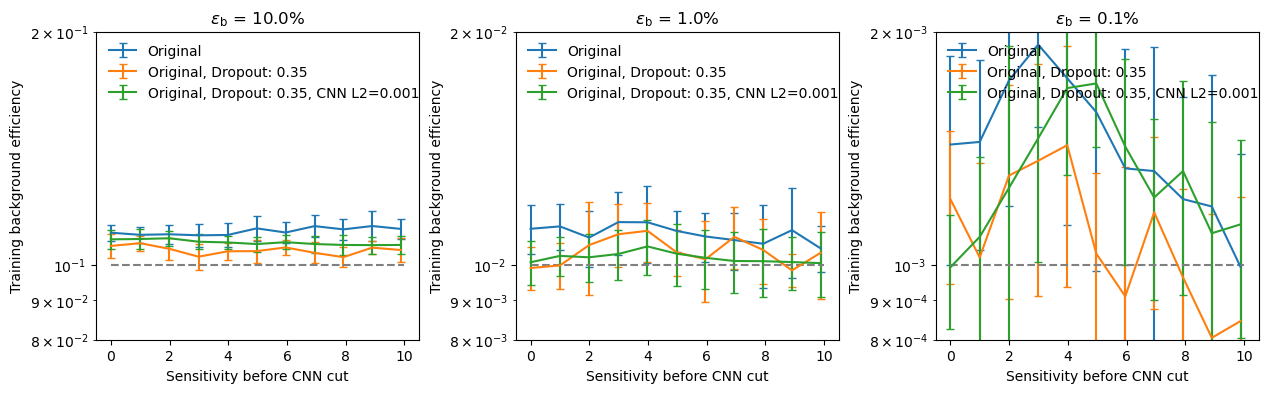

In [ ]:
n_train_S_origin, n_train_B_origin, n_test_B_origin = get_train_test_event_numbers('SB_{:.1f}_25x25')
n_train_S_origin_dp_35, n_train_B_origin_dp_35, n_test_B_origin_dp_35 = get_train_test_event_numbers('SB_{:.1f}_25x25_dp_035')
n_train_S_origin_dp_35_CNN_l2_0001, n_train_B_origin_dp_35_CNN_l2_0001, n_test_B_origin_dp_35_CNN_l2_0001 = get_train_test_event_numbers('SB_{:.1f}_25x25_dp_035_CNN_l2_0001')

fig, ax = plt.subplots(1, 3, figsize=(15, 4))
# enlarge the sapce between the plots
plt.subplots_adjust(wspace=0.3)

efficiencies = [0.1, 0.01, 0.001]
sensitivities = convert_to_realistic_sensitivity(np.arange(11), nB=n_bkg_in_SR)

titles = ['$\epsilon_\mathrm{b}$ = ' + f'{eff * 100}%' for eff in efficiencies]
for i in range(3):
    test_bkg_eff = efficiencies[i]
    train_bkg_eff_origin = n_train_B_origin[i] / n_test_B_origin[i,:,0][:, None] * test_bkg_eff
    train_bkg_eff_origin_dp_35 = n_train_B_origin_dp_35[i] / n_test_B_origin_dp_35[i,:,0][:, None] * test_bkg_eff
    train_bkg_eff_origin_dp_35_CNN_l2_0001 = n_train_B_origin_dp_35_CNN_l2_0001[i] / n_test_B_origin_dp_35_CNN_l2_0001[i,:,0][:, None] * test_bkg_eff

    ax[i].errorbar(sensitivities, train_bkg_eff_origin[:,0], yerr=train_bkg_eff_origin[:,1], marker='', capsize=3, label='Original')
    ax[i].errorbar(sensitivities, train_bkg_eff_origin_dp_35[:,0], yerr=train_bkg_eff_origin_dp_35[:,1], marker='', capsize=3, label='Original, Dropout: 0.35')
    ax[i].errorbar(sensitivities, train_bkg_eff_origin_dp_35_CNN_l2_0001[:,0], yerr=train_bkg_eff_origin_dp_35_CNN_l2_0001[:,1], marker='', capsize=3, label='Original, Dropout: 0.35, CNN L2=0.001')

    ax[i].hlines(test_bkg_eff, 0, 10, color='gray', linestyle='--')

    ax[i].set_title(titles[i])
    ax[i].set_xlabel('Sensitivity before CNN cut')
    ax[i].set_ylabel('Training background efficiency')

    ax[i].set_ylim(test_bkg_eff * 0.8, test_bkg_eff * 2)
    ax[i].set_yscale('log')

    ax[i].legend(frameon=False, loc='upper left')

plt.savefig('../figures/HVmodel_train_B_passing_rate_origin_dp_35_CNN_l2_0001.pdf', dpi=300, facecolor='White', bbox_inches='tight')
plt.show()

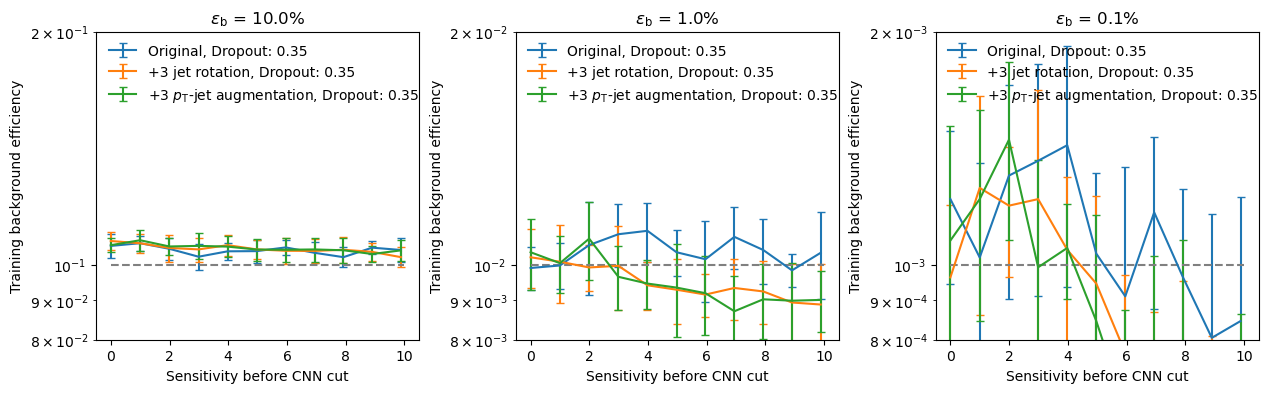

In [ ]:
n_train_S_origin, n_train_B_origin, n_test_B_origin = get_train_test_event_numbers('SB_{:.1f}_25x25')
n_train_S_jet_aug_3, n_train_B_jet_aug_3, n_test_B_jet_aug_3 = get_train_test_event_numbers('SB_{:.1f}_jet_aug_3_25x25')
n_train_S_pt_jet_aug_3, n_train_B_pt_jet_aug_3, n_test_B_pt_jet_aug_3 = get_train_test_event_numbers('SB_{:.1f}_pt_jet_aug_3_25x25')

n_train_S_origin_dp_35, n_train_B_origin_dp_35, n_test_B_origin_dp_35 = get_train_test_event_numbers('SB_{:.1f}_25x25_dp_035')
n_train_S_jet_aug_3_dp_35, n_train_B_jet_aug_3_dp_35, n_test_B_jet_aug_3_dp_35 = get_train_test_event_numbers('SB_{:.1f}_jet_aug_3_25x25_dp_035')
n_train_S_pt_jet_aug_3_dp_35, n_train_B_pt_jet_aug_3_dp_35, n_test_B_pt_jet_aug_3_dp_35 = get_train_test_event_numbers('SB_{:.1f}_pt_jet_aug_3_25x25_dp_035')

fig, ax = plt.subplots(1, 3, figsize=(15, 4))
# enlarge the sapce between the plots
plt.subplots_adjust(wspace=0.3)

efficiencies = [0.1, 0.01, 0.001]
sensitivities = convert_to_realistic_sensitivity(np.arange(11), nB=n_bkg_in_SR)

titles = ['$\epsilon_\mathrm{b}$ = ' + f'{eff * 100}%' for eff in efficiencies]
for i in range(3):
    test_bkg_eff = efficiencies[i]
    train_bkg_eff_origin = n_train_B_origin[i] / n_test_B_origin[i,:,0][:, None] * test_bkg_eff
    train_bkg_eff_jet_aug_3 = n_train_B_jet_aug_3[i] / n_test_B_jet_aug_3[i,:,0][:, None] * test_bkg_eff
    train_bkg_eff_pt_jet_aug_3 = n_train_B_pt_jet_aug_3[i] / n_test_B_pt_jet_aug_3[i,:,0][:, None] * test_bkg_eff

    train_bkg_eff_origin_dp_35 = n_train_B_origin_dp_35[i] / n_test_B_origin_dp_35[i,:,0][:, None] * test_bkg_eff
    train_bkg_eff_jet_aug_3_dp_35 = n_train_B_jet_aug_3_dp_35[i] / n_test_B_jet_aug_3_dp_35[i,:,0][:, None] * test_bkg_eff
    train_bkg_eff_pt_jet_aug_3_dp_35 = n_train_B_pt_jet_aug_3_dp_35[i] / n_test_B_pt_jet_aug_3_dp_35[i,:,0][:, None] * test_bkg_eff

    ax[i].errorbar(sensitivities, train_bkg_eff_origin_dp_35[:,0], yerr=train_bkg_eff_origin_dp_35[:,1], marker='', capsize=3, label='Original, Dropout: 0.35')
    ax[i].errorbar(sensitivities, train_bkg_eff_jet_aug_3_dp_35[:,0], yerr=train_bkg_eff_jet_aug_3_dp_35[:,1], marker='', capsize=3, label='+3 jet rotation, Dropout: 0.35')
    ax[i].errorbar(sensitivities, train_bkg_eff_pt_jet_aug_3_dp_35[:,0], yerr=train_bkg_eff_pt_jet_aug_3_dp_35[:,1], marker='', capsize=3, label='+3 $p_\mathrm{T}$-jet augmentation, Dropout: 0.35')

    ax[i].hlines(test_bkg_eff, 0, 10, color='gray', linestyle='--')

    ax[i].set_title(titles[i])
    ax[i].set_xlabel('Sensitivity before CNN cut')
    ax[i].set_ylabel('Training background efficiency')

    ax[i].set_ylim(test_bkg_eff * 0.8, test_bkg_eff * 2)
    ax[i].set_yscale('log')

    ax[i].legend(frameon=False, loc='upper left')

plt.savefig('../figures/HVmodel_train_B_passing_rate_origin_jet_aug_3_pt_jet_aug_3_dp_35.pdf', dpi=300, facecolor='White', bbox_inches='tight')
plt.show()

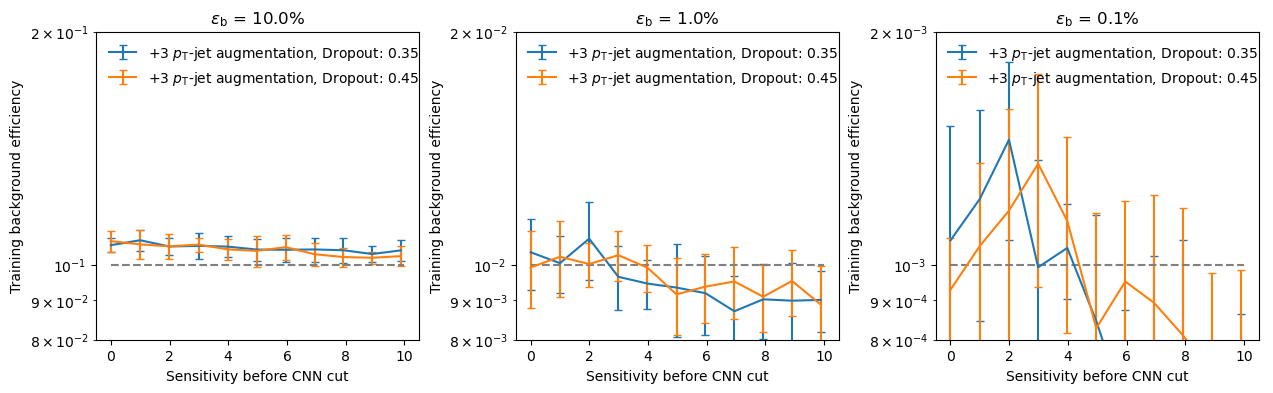

In [ ]:
n_train_S_origin_dp_45, n_train_B_origin_dp_45, n_test_B_origin_dp_45 = get_train_test_event_numbers('SB_{:.1f}_25x25_dp_045')
n_train_S_jet_aug_3_dp_45, n_train_B_jet_aug_3_dp_45, n_test_B_jet_aug_3_dp_45 = get_train_test_event_numbers('SB_{:.1f}_jet_aug_3_25x25_dp_045')
n_train_S_pt_jet_aug_3_dp_45, n_train_B_pt_jet_aug_3_dp_45, n_test_B_pt_jet_aug_3_dp_45 = get_train_test_event_numbers('SB_{:.1f}_pt_jet_aug_3_25x25_dp_045')

n_train_S_origin_dp_35, n_train_B_origin_dp_35, n_test_B_origin_dp_35 = get_train_test_event_numbers('SB_{:.1f}_25x25_dp_035')
n_train_S_jet_aug_3_dp_35, n_train_B_jet_aug_3_dp_35, n_test_B_jet_aug_3_dp_35 = get_train_test_event_numbers('SB_{:.1f}_jet_aug_3_25x25_dp_035')
n_train_S_pt_jet_aug_3_dp_35, n_train_B_pt_jet_aug_3_dp_35, n_test_B_pt_jet_aug_3_dp_35 = get_train_test_event_numbers('SB_{:.1f}_pt_jet_aug_3_25x25_dp_035')

    

fig, ax = plt.subplots(1, 3, figsize=(15, 4))
# enlarge the sapce between the plots
plt.subplots_adjust(wspace=0.3)

efficiencies = [0.1, 0.01, 0.001]
sensitivities = convert_to_realistic_sensitivity(np.arange(11), nB=n_bkg_in_SR)

titles = ['$\epsilon_\mathrm{b}$ = ' + f'{eff * 100}%' for eff in efficiencies]
for i in range(3):
    test_bkg_eff = efficiencies[i]

    train_bkg_eff_origin_dp_35 = n_train_B_origin_dp_35[i] / n_test_B_origin_dp_35[i,:,0][:, None] * test_bkg_eff
    train_bkg_eff_jet_aug_3_dp_35 = n_train_B_jet_aug_3_dp_35[i] / n_test_B_jet_aug_3_dp_35[i,:,0][:, None] * test_bkg_eff
    train_bkg_eff_pt_jet_aug_3_dp_35 = n_train_B_pt_jet_aug_3_dp_35[i] / n_test_B_pt_jet_aug_3_dp_35[i,:,0][:, None] * test_bkg_eff

    # ax[i].errorbar(sensitivities, train_bkg_eff_origin_dp_35[:,0], yerr=train_bkg_eff_origin_dp_35[:,1], marker='', capsize=3, label='Original, Dropout: 0.35')
    # ax[i].errorbar(sensitivities, train_bkg_eff_jet_aug_3_dp_35[:,0], yerr=train_bkg_eff_jet_aug_3_dp_35[:,1], marker='', capsize=3, label='+3 jet rotation, Dropout: 0.35')
    ax[i].errorbar(sensitivities, train_bkg_eff_pt_jet_aug_3_dp_35[:,0], yerr=train_bkg_eff_pt_jet_aug_3_dp_35[:,1], marker='', capsize=3, label='+3 $p_\mathrm{T}$-jet augmentation, Dropout: 0.35')

    train_bkg_eff_origin_dp_45 = n_train_B_origin_dp_45[i] / n_test_B_origin_dp_45[i,:,0][:, None] * test_bkg_eff
    train_bkg_eff_jet_aug_3_dp_45 = n_train_B_jet_aug_3_dp_45[i] / n_test_B_jet_aug_3_dp_45[i,:,0][:, None] * test_bkg_eff
    train_bkg_eff_pt_jet_aug_3_dp_45 = n_train_B_pt_jet_aug_3_dp_45[i] / n_test_B_pt_jet_aug_3_dp_45[i,:,0][:, None] * test_bkg_eff

    # ax[i].errorbar(sensitivities, train_bkg_eff_origin_dp_45[:,0], yerr=train_bkg_eff_origin_dp_45[:,1], marker='', capsize=3, label='Original, Dropout: 0.45')
    # ax[i].errorbar(sensitivities, train_bkg_eff_jet_aug_3_dp_45[:,0], yerr=train_bkg_eff_jet_aug_3_dp_45[:,1], marker='', capsize=3, label='+3 jet rotation, Dropout: 0.45')
    ax[i].errorbar(sensitivities, train_bkg_eff_pt_jet_aug_3_dp_45[:,0], yerr=train_bkg_eff_pt_jet_aug_3_dp_45[:,1], marker='', capsize=3, label='+3 $p_\mathrm{T}$-jet augmentation, Dropout: 0.45')

    ax[i].hlines(test_bkg_eff, 0, 10, color='gray', linestyle='--')

    ax[i].set_title(titles[i])
    ax[i].set_xlabel('Sensitivity before CNN cut')
    ax[i].set_ylabel('Training background efficiency')

    ax[i].set_ylim(test_bkg_eff * 0.8, test_bkg_eff * 2)
    ax[i].set_yscale('log')

    ax[i].legend(frameon=False, loc='upper left')

# plt.savefig('../figures/HVmodel_train_B_passing_rate_origin_jet_aug_3_pt_jet_aug_3_dp_45.pdf', dpi=300, facecolor='White', bbox_inches='tight')
plt.show()

# K-fold

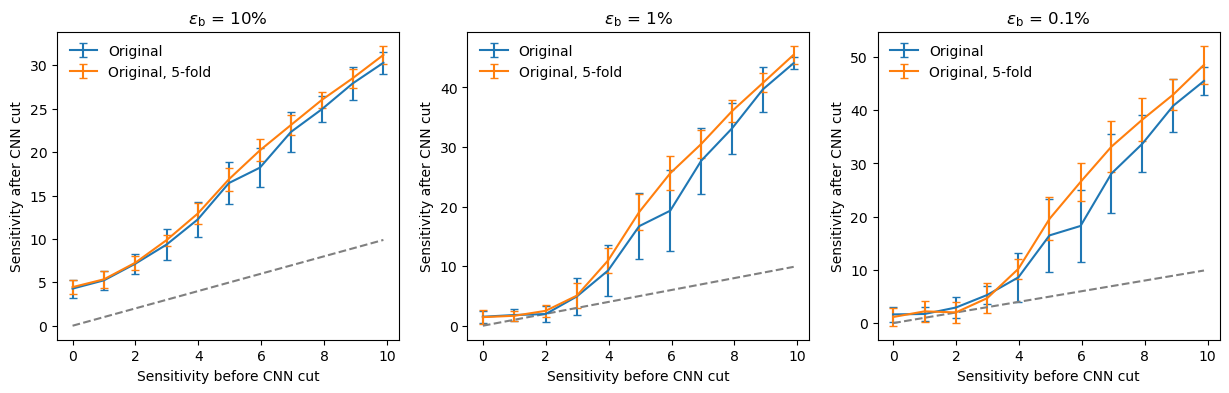

In [ ]:
sensitivities_origin, stds_origin = get_realistic_sensitivity_and_std_bkg_subtraction('SB_{:.1f}_25x25')
sensitivities_origin_5_fold, stds_origin_5_fold = get_realistic_sensitivity_and_std_bkg_subtraction('SB_{:.1f}_25x25_5_fold')

sensitivities = convert_to_realistic_sensitivity(np.arange(11), nB=n_bkg_in_SR)

fig, ax = plt.subplots(1, 3, figsize=(15, 4))

titles = ['$\epsilon_\mathrm{b}$ = 10%', '$\epsilon_\mathrm{b}$ = 1%', '$\epsilon_\mathrm{b}$ = 0.1%']
for i in range(3):
    ax[i].errorbar(sensitivities, sensitivities_origin[i], yerr=stds_origin[i], marker='', capsize=3, label='Original')
    ax[i].errorbar(sensitivities, sensitivities_origin_5_fold[i], yerr=stds_origin_5_fold[i], marker='', capsize=3, label='Original, 5-fold')

    ax[i].plot(sensitivities, sensitivities, '--', color='grey')

    ax[i].set_title(titles[i])
    ax[i].set_xlabel('Sensitivity before CNN cut')
    ax[i].set_ylabel('Sensitivity after CNN cut')

    ax[i].legend(frameon=False, loc='upper left')

plt.savefig('../figures/HVmodel_sensitivity_improvement_origin_bkg_subtraction_5_fold.pdf', dpi=300, facecolor='White', bbox_inches='tight')
plt.show()

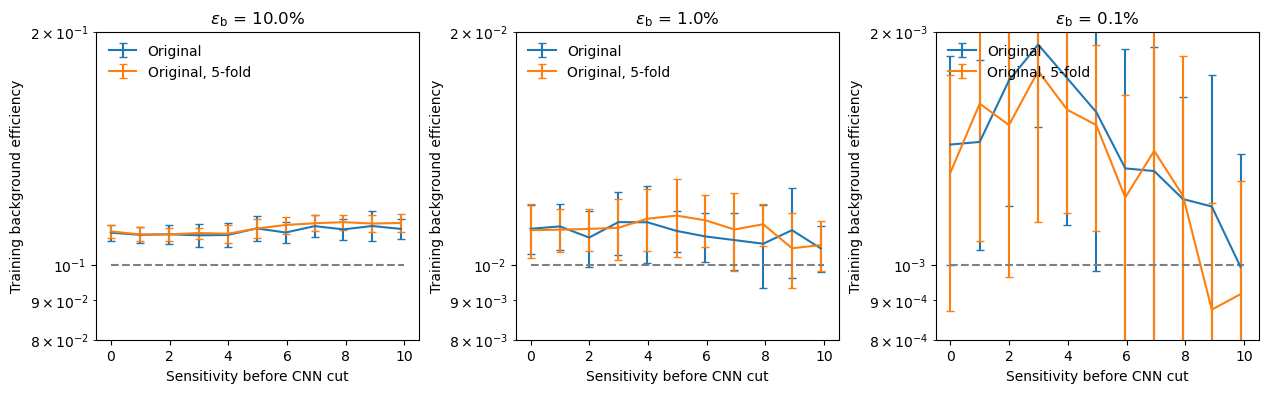

In [ ]:
n_train_S_origin, n_train_B_origin, n_test_B_origin = get_train_test_event_numbers('SB_{:.1f}_25x25')
n_train_S_origin_5_fold, n_train_B_origin_5_fold, n_test_B_origin_5_fold = get_train_test_event_numbers('SB_{:.1f}_25x25_5_fold')

fig, ax = plt.subplots(1, 3, figsize=(15, 4))
# enlarge the sapce between the plots
plt.subplots_adjust(wspace=0.3)

efficiencies = [0.1, 0.01, 0.001]
sensitivities = convert_to_realistic_sensitivity(np.arange(11), nB=n_bkg_in_SR)

titles = ['$\epsilon_\mathrm{b}$ = ' + f'{eff * 100}%' for eff in efficiencies]
for i in range(3):
    test_bkg_eff = efficiencies[i]
    train_bkg_eff_origin = n_train_B_origin[i] / n_test_B_origin[i,:,0][:, None] * test_bkg_eff
    train_bkg_eff_origin_5_fold = n_train_B_origin_5_fold[i] / n_test_B_origin_5_fold[i,:,0][:, None] * test_bkg_eff

    ax[i].errorbar(sensitivities, train_bkg_eff_origin[:,0], yerr=train_bkg_eff_origin[:,1], marker='', capsize=3, label='Original')
    ax[i].errorbar(sensitivities, train_bkg_eff_origin_5_fold[:,0], yerr=train_bkg_eff_origin_5_fold[:,1], marker='', capsize=3, label='Original, 5-fold')

    ax[i].hlines(test_bkg_eff, 0, 10, color='gray', linestyle='--')

    ax[i].set_title(titles[i])
    ax[i].set_xlabel('Sensitivity before CNN cut')
    ax[i].set_ylabel('Training background efficiency')

    ax[i].set_ylim(test_bkg_eff * 0.8, test_bkg_eff * 2)
    ax[i].set_yscale('log')

    ax[i].legend(frameon=False, loc='upper left')

plt.savefig('../figures/HVmodel_train_B_passing_rate_origin_5_fold.pdf', dpi=300, facecolor='White', bbox_inches='tight')
plt.show()

# L1 regularization

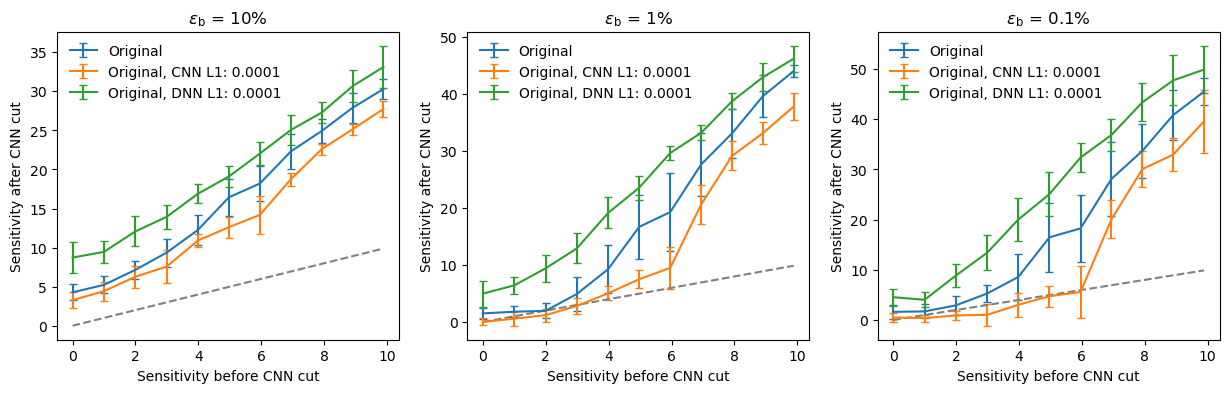

In [ ]:
sensitivities_origin, stds_origin = get_realistic_sensitivity_and_std_bkg_subtraction('SB_{:.1f}_25x25')
sensitivities_origin_CNN_l1_0001, stds_origin_CNN_l1_0001 = get_realistic_sensitivity_and_std_bkg_subtraction('SB_{:.1f}_25x25_CNN_l1_00001')
sensitivities_origin_DNN_l1_0001, stds_origin_DNN_l1_0001 = get_realistic_sensitivity_and_std_bkg_subtraction('SB_{:.1f}_25x25_DNN_l1_00001')
sensitivities = convert_to_realistic_sensitivity(np.arange(11), nB=n_bkg_in_SR)

fig, ax = plt.subplots(1, 3, figsize=(15, 4))

titles = ['$\epsilon_\mathrm{b}$ = 10%', '$\epsilon_\mathrm{b}$ = 1%', '$\epsilon_\mathrm{b}$ = 0.1%']
for i in range(3):
    ax[i].errorbar(sensitivities, sensitivities_origin[i], yerr=stds_origin[i], marker='', capsize=3, label='Original')
    ax[i].errorbar(sensitivities, sensitivities_origin_CNN_l1_0001[i], yerr=stds_origin_CNN_l1_0001[i], marker='', capsize=3, label='Original, CNN L1: 0.0001')
    ax[i].errorbar(sensitivities, sensitivities_origin_DNN_l1_0001[i], yerr=stds_origin_DNN_l1_0001[i], marker='', capsize=3, label='Original, DNN L1: 0.0001')

    ax[i].plot(sensitivities, sensitivities, '--', color='grey')

    ax[i].set_title(titles[i])
    ax[i].set_xlabel('Sensitivity before CNN cut')
    ax[i].set_ylabel('Sensitivity after CNN cut')

    ax[i].legend(frameon=False, loc='upper left')

plt.savefig('../figures/HVmodel_sensitivity_improvement_origin_bkg_subtraction_l1_00001.pdf', dpi=300, facecolor='White', bbox_inches='tight')
plt.show()

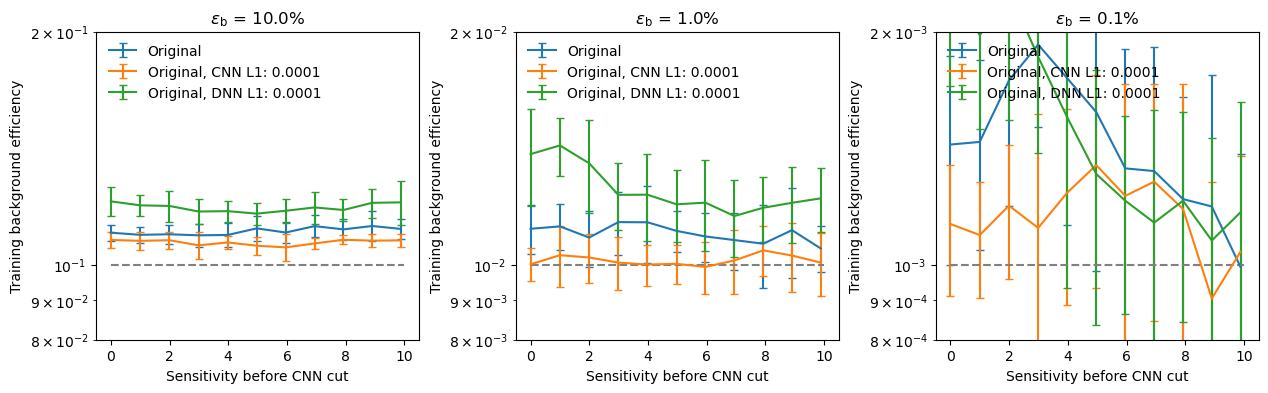

In [ ]:
n_train_S_origin, n_train_B_origin, n_test_B_origin = get_train_test_event_numbers('SB_{:.1f}_25x25')
n_train_S_origin_CNN_l1_00001, n_train_B_origin_CNN_l1_00001, n_test_B_origin_CNN_l1_00001 = get_train_test_event_numbers('SB_{:.1f}_25x25_CNN_l1_00001')
n_train_S_origin_DNN_l1_00001, n_train_B_origin_DNN_l1_00001, n_test_B_origin_DNN_l1_00001 = get_train_test_event_numbers('SB_{:.1f}_25x25_DNN_l1_00001')

fig, ax = plt.subplots(1, 3, figsize=(15, 4))
# enlarge the sapce between the plots
plt.subplots_adjust(wspace=0.3)

efficiencies = [0.1, 0.01, 0.001]
sensitivities = convert_to_realistic_sensitivity(np.arange(11), nB=n_bkg_in_SR)

titles = ['$\epsilon_\mathrm{b}$ = ' + f'{eff * 100}%' for eff in efficiencies]
for i in range(3):
    test_bkg_eff = efficiencies[i]
    train_bkg_eff_origin = n_train_B_origin[i] / n_test_B_origin[i,:,0][:, None] * test_bkg_eff
    train_bkg_eff_origin_CNN_l1_00001 = n_train_B_origin_CNN_l1_00001[i] / n_test_B_origin_CNN_l1_00001[i,:,0][:, None] * test_bkg_eff
    train_bkg_eff_origin_DNN_l1_00001 = n_train_B_origin_DNN_l1_00001[i] / n_test_B_origin_DNN_l1_00001[i,:,0][:, None] * test_bkg_eff

    ax[i].errorbar(sensitivities, train_bkg_eff_origin[:,0], yerr=train_bkg_eff_origin[:,1], marker='', capsize=3, label='Original')
    ax[i].errorbar(sensitivities, train_bkg_eff_origin_CNN_l1_00001[:,0], yerr=train_bkg_eff_origin_CNN_l1_00001[:,1], marker='', capsize=3, label='Original, CNN L1: 0.0001')
    ax[i].errorbar(sensitivities, train_bkg_eff_origin_DNN_l1_00001[:,0], yerr=train_bkg_eff_origin_DNN_l1_00001[:,1], marker='', capsize=3, label='Original, DNN L1: 0.0001')

    ax[i].hlines(test_bkg_eff, 0, 10, color='gray', linestyle='--')

    ax[i].set_title(titles[i])
    ax[i].set_xlabel('Sensitivity before CNN cut')
    ax[i].set_ylabel('Training background efficiency')

    ax[i].set_ylim(test_bkg_eff * 0.8, test_bkg_eff * 2)
    ax[i].set_yscale('log')

    ax[i].legend(frameon=False, loc='upper left')

plt.savefig('../figures/HVmodel_train_B_passing_rate_origin_l1_00001.pdf', dpi=300, facecolor='White', bbox_inches='tight')
plt.show()

# Asymptotic behaviour

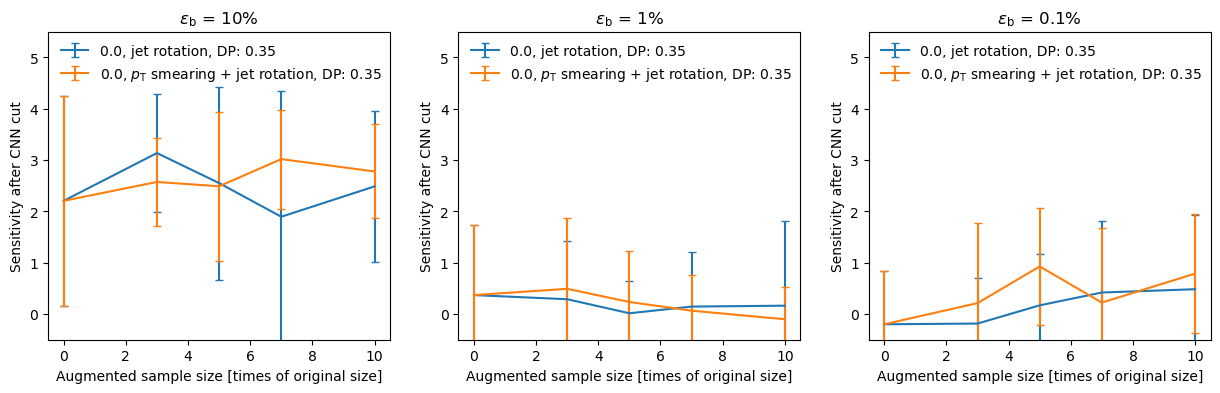

In [ ]:
sample_size = [3, 5, 7, 10]
res = 25
models = [f'SB_0.0_{res}x{res}_dp_035'] + [f'SB_0.0_jet_aug_{n}_{res}x{res}_dp_035' for n in sample_size]
sensitivities_jet_aug_3, stds_jet_aug_3 = get_realistic_sensitivity_and_std_bkg_subtraction_from_models(models, sensitivity=0.0)

models = [f'SB_0.0_{res}x{res}_dp_035'] + [f'SB_0.0_pt_jet_aug_{n}_{res}x{res}_dp_035' for n in sample_size]
sensitivities_pt_jet_aug_3, stds_pt_jet_aug_3 = get_realistic_sensitivity_and_std_bkg_subtraction_from_models(models, sensitivity=0.0)

fig, ax = plt.subplots(1, 3, figsize=(15, 4))

titles = ['$\epsilon_\mathrm{b}$ = 10%', '$\epsilon_\mathrm{b}$ = 1%', '$\epsilon_\mathrm{b}$ = 0.1%']
for i in range(3):

    ax[i].errorbar([0] + sample_size, sensitivities_jet_aug_3[i], yerr=stds_jet_aug_3[i], marker='', capsize=3, label='0.0, jet rotation, DP: 0.35')
    ax[i].errorbar([0] + sample_size, sensitivities_pt_jet_aug_3[i], yerr=stds_pt_jet_aug_3[i], marker='', capsize=3, label='0.0, $p_\mathrm{T}$ smearing + jet rotation, DP: 0.35')

    ax[i].set_title(titles[i])
    # ax[i].hlines(3, 0, sample_size[-1], color='gray', linestyle='--')
    ax[i].set_ylim(-0.5, 5.5)
    ax[i].set_xlabel('Augmented sample size [times of original size]')
    ax[i].set_ylabel('Sensitivity after CNN cut')

    ax[i].legend(frameon=False, loc='upper left')

plt.savefig(f'../figures/HVmodel_sensitivity_improvement_pt_jet_aug_3_to_10_SB_0_dp_35_res_{res}.pdf', dpi=300, facecolor='White', bbox_inches='tight')
plt.show()

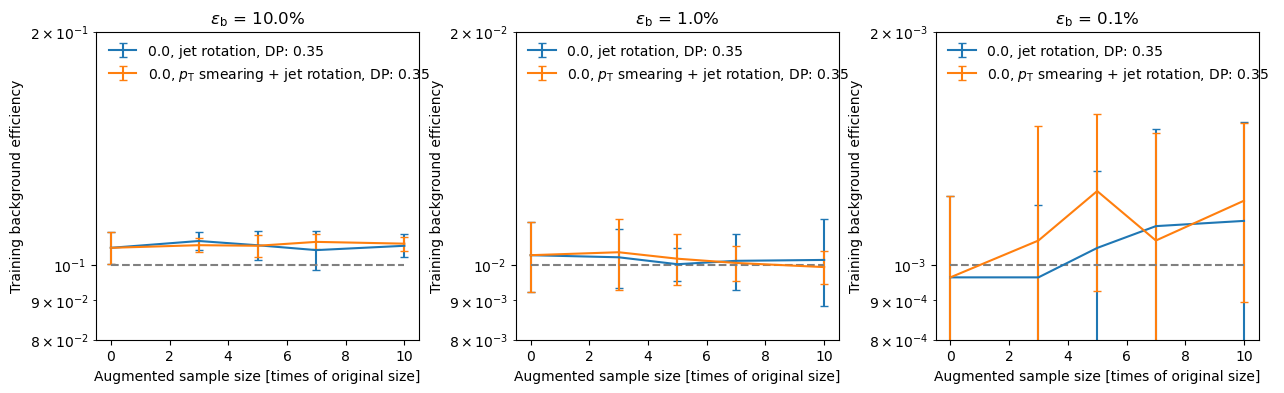

In [ ]:
sample_size = [3, 5, 7, 10]
res = 25
models = [f'SB_0.0_{res}x{res}_dp_035'] + [f'SB_0.0_jet_aug_{n}_{res}x{res}_dp_035' for n in sample_size]
n_train_S_jet_aug_3_dp_35, n_train_B_jet_aug_3_dp_35, n_test_B_jet_aug_3_dp_35 = get_train_test_event_numbers_from_models(models, sensitivity=0.0)

models = [f'SB_0.0_{res}x{res}_dp_035'] + [f'SB_0.0_pt_jet_aug_{n}_{res}x{res}_dp_035' for n in sample_size]
n_train_S_pt_jet_aug_3_dp_35, n_train_B_pt_jet_aug_3_dp_35, n_test_B_pt_jet_aug_3_dp_35 = get_train_test_event_numbers_from_models(models, sensitivity=0.0)

fig, ax = plt.subplots(1, 3, figsize=(15, 4))
# enlarge the sapce between the plots
plt.subplots_adjust(wspace=0.3)

efficiencies = [0.1, 0.01, 0.001]
sensitivities = convert_to_realistic_sensitivity(np.arange(11), nB=n_bkg_in_SR)

titles = ['$\epsilon_\mathrm{b}$ = ' + f'{eff * 100}%' for eff in efficiencies]
for i in range(3):
    test_bkg_eff = efficiencies[i]

    train_bkg_eff_jet_aug_3_dp_35 = n_train_B_jet_aug_3_dp_35[i] / n_test_B_jet_aug_3_dp_35[i,:,0][:, None] * test_bkg_eff
    train_bkg_eff_pt_jet_aug_3_dp_35 = n_train_B_pt_jet_aug_3_dp_35[i] / n_test_B_pt_jet_aug_3_dp_35[i,:,0][:, None] * test_bkg_eff

    ax[i].errorbar([0] + sample_size, train_bkg_eff_jet_aug_3_dp_35[:, 0], yerr=train_bkg_eff_jet_aug_3_dp_35[:, 1], marker='', capsize=3, label='0.0, jet rotation, DP: 0.35')
    ax[i].errorbar([0] + sample_size, train_bkg_eff_pt_jet_aug_3_dp_35[:, 0], yerr=train_bkg_eff_pt_jet_aug_3_dp_35[:, 1], marker='', capsize=3, label='0.0, $p_\mathrm{T}$ smearing + jet rotation, DP: 0.35')

    ax[i].hlines(test_bkg_eff, 0, 10, color='gray', linestyle='--')

    ax[i].set_title(titles[i])
    ax[i].set_xlabel('Augmented sample size [times of original size]')
    ax[i].set_ylabel('Training background efficiency')

    ax[i].set_ylim(test_bkg_eff * 0.8, test_bkg_eff * 2)
    ax[i].set_yscale('log')

    ax[i].legend(frameon=False, loc='upper left')

plt.savefig(f'../figures/HVmodel_train_B_passing_rate_origin_pt_jet_aug_3_to_10_SB_0_dp_35_res_{res}.pdf', dpi=300, facecolor='White', bbox_inches='tight')
plt.show()

# Sensitivity 0

[[4.273963364161078], [1.508375878656988], [1.6323127223804732]] [[1.0393197137688428], [0.9854696350619377], [1.3617714860734358]]
[[1.9532921153416591], [1.0002727943596095], [1.2453684402707115]] [[1.600059383809187], [1.3585054234124196], [0.9598584611123089]]
[[1.7554758888077178], [1.1305783710176924], [0.9970019975058797]] [[1.4521048128159924], [1.0183660492855906], [1.459286850893012]]


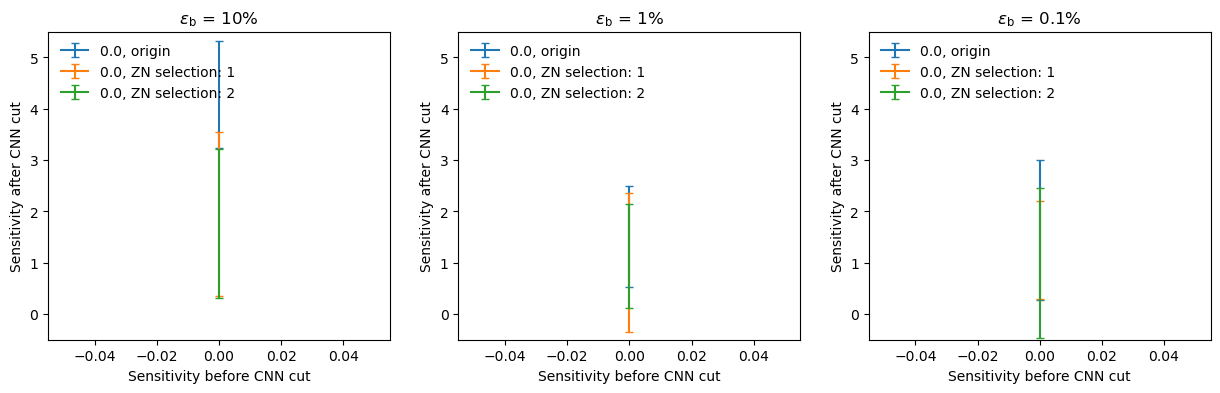

In [ ]:
sample_size = []
res = 25
models = [f'SB_0.0_{res}x{res}']
sensitivities_origin, stds_origin = get_realistic_sensitivity_and_std_bkg_subtraction_from_models(models, sensitivity=0.0)
print(sensitivities_origin, stds_origin)

models = [f'SB_0.0_{res}x{res}_FY']
sensitivities_FY, stds_FY = get_realistic_sensitivity_and_std_bkg_subtraction_from_models(models, sensitivity=0.0)
print(sensitivities_FY, stds_FY)

models = [f'SB_0.0_{res}x{res}_ZN']
sensitivities_ZN, stds_ZN = get_realistic_sensitivity_and_std_bkg_subtraction_from_models(models, sensitivity=0.0)
print(sensitivities_ZN, stds_ZN)

fig, ax = plt.subplots(1, 3, figsize=(15, 4))

titles = ['$\epsilon_\mathrm{b}$ = 10%', '$\epsilon_\mathrm{b}$ = 1%', '$\epsilon_\mathrm{b}$ = 0.1%']
for i in range(3):

    ax[i].errorbar([0] + sample_size, sensitivities_origin[i], yerr=stds_origin[i], marker='', capsize=3, label='0.0, origin')
    ax[i].errorbar([0] + sample_size, sensitivities_FY[i], yerr=stds_FY[i], marker='', capsize=3, label='0.0, ZN selection: 1')
    ax[i].errorbar([0] + sample_size, sensitivities_ZN[i], yerr=stds_ZN[i], marker='', capsize=3, label='0.0, ZN selection: 2')

    ax[i].set_title(titles[i])
    # ax[i].hlines(3, 0, sample_size[-1], color='gray', linestyle='--')
    ax[i].set_ylim(-0.5, 5.5)
    ax[i].set_xlabel('Sensitivity before CNN cut')
    ax[i].set_ylabel('Sensitivity after CNN cut')

    ax[i].legend(frameon=False, loc='upper left')

# plt.savefig(f'../figures/HVmodel_sensitivity_improvement_pt_jet_aug_3_to_10_SB_0_dp_35_res_{res}.pdf', dpi=300, facecolor='White', bbox_inches='tight')
plt.show()

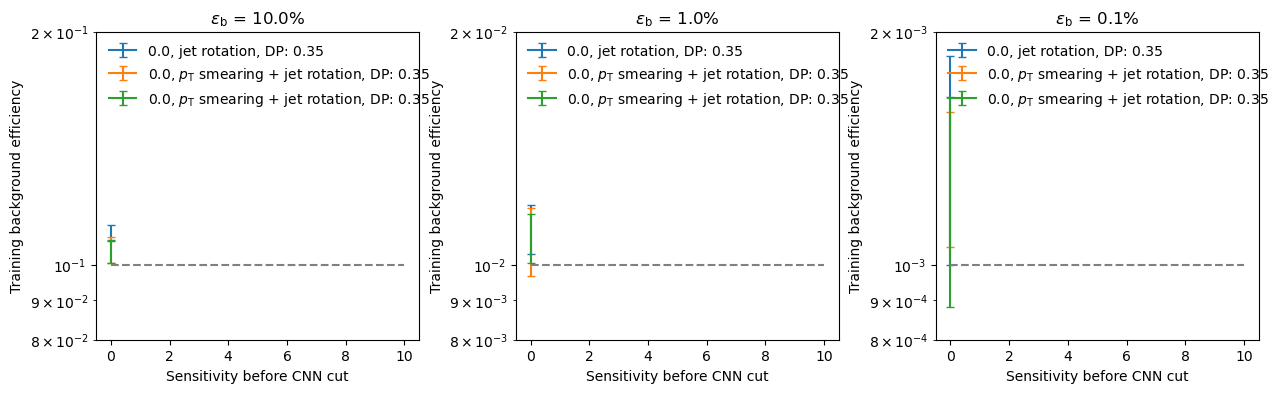

In [ ]:
sample_size = []
res = 25
models = [f'SB_0.0_{res}x{res}']
n_train_S_origin, n_train_B_origin, n_test_B_origin = get_train_test_event_numbers_from_models(models, sensitivity=0.0)

models = [f'SB_0.0_{res}x{res}_FY']
n_train_S_FY, n_train_B_FY, n_test_B_FY = get_train_test_event_numbers_from_models(models, sensitivity=0.0)

models = [f'SB_0.0_{res}x{res}_ZN']
n_train_S_ZN, n_train_B_ZN, n_test_B_ZN = get_train_test_event_numbers_from_models(models, sensitivity=0.0)

fig, ax = plt.subplots(1, 3, figsize=(15, 4))
# enlarge the sapce between the plots
plt.subplots_adjust(wspace=0.3)

efficiencies = [0.1, 0.01, 0.001]
sensitivities = convert_to_realistic_sensitivity(np.arange(11), nB=n_bkg_in_SR)

titles = ['$\epsilon_\mathrm{b}$ = ' + f'{eff * 100}%' for eff in efficiencies]
for i in range(3):
    test_bkg_eff = efficiencies[i]

    train_bkg_eff_origin = n_train_B_origin[i] / n_test_B_origin[i,:,0][:, None] * test_bkg_eff
    train_bkg_eff_FY = n_train_B_FY[i] / n_test_B_FY[i,:,0][:, None] * test_bkg_eff
    train_bkg_eff_ZN = n_train_B_ZN[i] / n_test_B_ZN[i,:,0][:, None] * test_bkg_eff

    ax[i].errorbar([0] + sample_size, train_bkg_eff_origin[:, 0], yerr=train_bkg_eff_origin[:, 1], marker='', capsize=3, label='0.0, jet rotation, DP: 0.35')
    ax[i].errorbar([0] + sample_size, train_bkg_eff_FY[:, 0], yerr=train_bkg_eff_FY[:, 1], marker='', capsize=3, label='0.0, $p_\mathrm{T}$ smearing + jet rotation, DP: 0.35')
    ax[i].errorbar([0] + sample_size, train_bkg_eff_ZN[:, 0], yerr=train_bkg_eff_ZN[:, 1], marker='', capsize=3, label='0.0, $p_\mathrm{T}$ smearing + jet rotation, DP: 0.35')

    ax[i].hlines(test_bkg_eff, 0, 10, color='gray', linestyle='--')

    ax[i].set_title(titles[i])
    ax[i].set_xlabel('Sensitivity before CNN cut')
    ax[i].set_ylabel('Training background efficiency')

    ax[i].set_ylim(test_bkg_eff * 0.8, test_bkg_eff * 2)
    ax[i].set_yscale('log')

    ax[i].legend(frameon=False, loc='upper left')

# plt.savefig(f'../figures/HVmodel_train_B_passing_rate_origin_pt_jet_aug_3_to_10_SB_0_dp_35_res_{res}.pdf', dpi=300, facecolor='White', bbox_inches='tight')
plt.show()

# Another pool

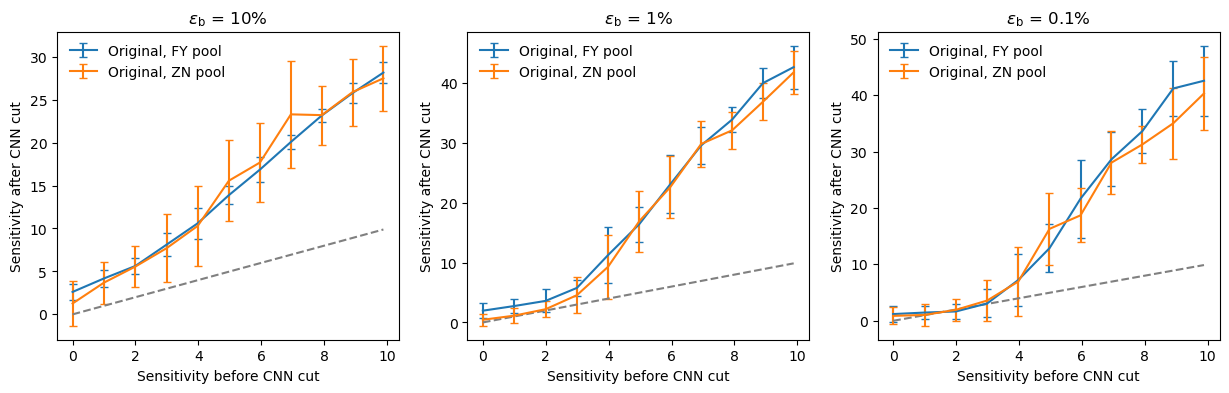

In [ ]:
sensitivities_origin, stds_origin = get_realistic_sensitivity_and_std_bkg_subtraction('SB_{:.1f}_25x25')
sensitivities_origin_ZN, stds_origin_ZN = get_realistic_sensitivity_and_std_bkg_subtraction('SB_{:.1f}_25x25_ZN_pool')
sensitivities = convert_to_realistic_sensitivity(np.arange(11), nB=n_bkg_in_SR)

fig, ax = plt.subplots(1, 3, figsize=(15, 4))

titles = ['$\epsilon_\mathrm{b}$ = 10%', '$\epsilon_\mathrm{b}$ = 1%', '$\epsilon_\mathrm{b}$ = 0.1%']
for i in range(3):
    ax[i].errorbar(sensitivities, sensitivities_origin[i], yerr=stds_origin[i], marker='', capsize=3, label='Original, FY pool')
    ax[i].errorbar(sensitivities, sensitivities_origin_ZN[i], yerr=stds_origin_ZN[i], marker='', capsize=3, label='Original, ZN pool')

    ax[i].plot(sensitivities, sensitivities, '--', color='grey')

    ax[i].set_title(titles[i])
    ax[i].set_xlabel('Sensitivity before CNN cut')
    ax[i].set_ylabel('Sensitivity after CNN cut')

    ax[i].legend(frameon=False, loc='upper left')

# plt.savefig('../figures/HVmodel_sensitivity_improvement_origin_bkg_subtraction_ZN_pool.pdf', dpi=300, facecolor='White', bbox_inches='tight')
plt.show()

# Random seed

3.8244309041493265 1.2259116460927229
2.9851894423548413 1.2026724605182413


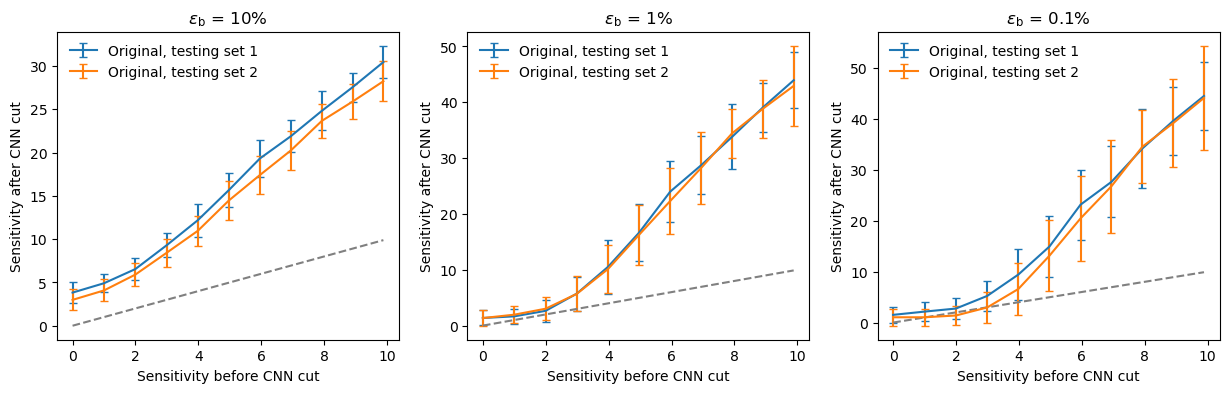

In [ ]:
sensitivities_origin, stds_origin = get_realistic_sensitivity_and_std_bkg_subtraction('SB_{:.1f}_25x25', s=slice(-100, None), filter_condition="time > '2024-07-04' and time < '2024-07-05'")
sensitivities_origin_2, stds_origin_2 = get_realistic_sensitivity_and_std_bkg_subtraction('SB_{:.1f}_25x25', s=slice(-100, None), filter_condition="time > '2024-07-23 09'")
print(sensitivities_origin[0][0], stds_origin[0][0])
print(sensitivities_origin_2[0][0], stds_origin_2[0][0])
sensitivities = convert_to_realistic_sensitivity(np.arange(11), nB=n_bkg_in_SR)

fig, ax = plt.subplots(1, 3, figsize=(15, 4))

titles = ['$\epsilon_\mathrm{b}$ = 10%', '$\epsilon_\mathrm{b}$ = 1%', '$\epsilon_\mathrm{b}$ = 0.1%']
for i in range(3):
    ax[i].errorbar(sensitivities, sensitivities_origin[i], yerr=stds_origin[i], marker='', capsize=3, label='Original, testing set 1')
    ax[i].errorbar(sensitivities, sensitivities_origin_2[i], yerr=stds_origin_2[i], marker='', capsize=3, label='Original, testing set 2')

    ax[i].plot(sensitivities, sensitivities, '--', color='grey')

    ax[i].set_title(titles[i])
    ax[i].set_xlabel('Sensitivity before CNN cut')
    ax[i].set_ylabel('Sensitivity after CNN cut')

    ax[i].legend(frameon=False, loc='upper left')

plt.savefig('../figures/HVmodel_sensitivity_improvement_origin_bkg_subtraction_100_random_seed_new_testing_set.pdf', dpi=300, facecolor='White', bbox_inches='tight')
plt.show()

# Testing dataset

4.226896368178605 1.0358695462448457
2.781529221419142 1.0558536744125595
2.398114443236181 0.8110312277972672
2.632960750887155 0.9239196935017489


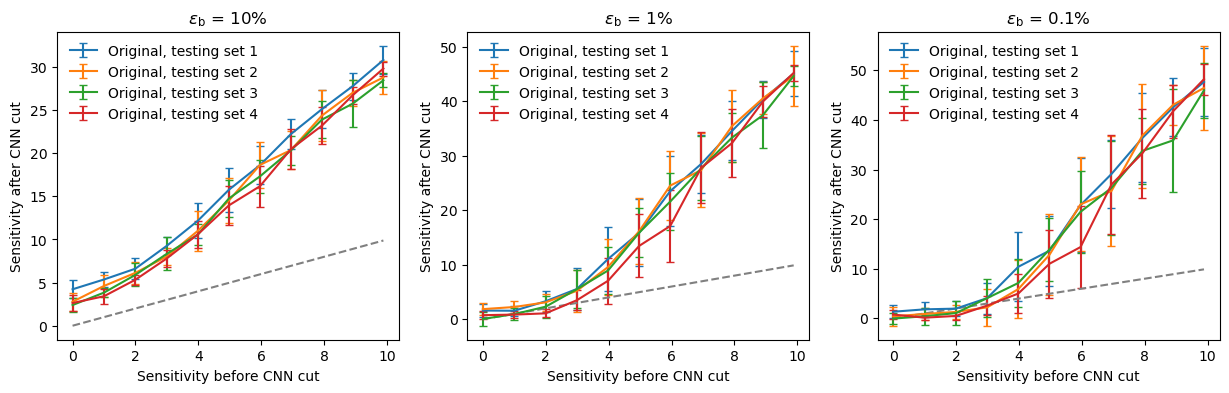

In [ ]:
sensitivities_origin, stds_origin = get_realistic_sensitivity_and_std_bkg_subtraction('SB_{:.1f}_25x25', filter_condition="time > '2024-07-04' and time < '2024-07-05'")
sensitivities_origin_2, stds_origin_2 = get_realistic_sensitivity_and_std_bkg_subtraction('SB_{:.1f}_25x25', filter_condition="time > '2024-07-23 09' and time < '2024-07-24'")
sensitivities_origin_3, stds_origin_3 = get_realistic_sensitivity_and_std_bkg_subtraction('SB_{:.1f}_25x25', filter_condition="time > '2024-07-24'")
sensitivities_origin_4, stds_origin_4 = get_realistic_sensitivity_and_std_bkg_subtraction('SB_{:.1f}_25x25_test4')
print(sensitivities_origin[0][0], stds_origin[0][0])
print(sensitivities_origin_2[0][0], stds_origin_2[0][0])
print(sensitivities_origin_3[0][0], stds_origin_3[0][0])
print(sensitivities_origin_4[0][0], stds_origin_4[0][0])
sensitivities = convert_to_realistic_sensitivity(np.arange(11), nB=n_bkg_in_SR)

fig, ax = plt.subplots(1, 3, figsize=(15, 4))

titles = ['$\epsilon_\mathrm{b}$ = 10%', '$\epsilon_\mathrm{b}$ = 1%', '$\epsilon_\mathrm{b}$ = 0.1%']
for i in range(3):
    ax[i].errorbar(sensitivities, sensitivities_origin[i], yerr=stds_origin[i], marker='', capsize=3, label='Original, testing set 1')
    ax[i].errorbar(sensitivities, sensitivities_origin_2[i], yerr=stds_origin_2[i], marker='', capsize=3, label='Original, testing set 2')
    ax[i].errorbar(sensitivities, sensitivities_origin_3[i], yerr=stds_origin_3[i], marker='', capsize=3, label='Original, testing set 3')
    ax[i].errorbar(sensitivities, sensitivities_origin_4[i], yerr=stds_origin_4[i], marker='', capsize=3, label='Original, testing set 4')

    ax[i].plot(sensitivities, sensitivities, '--', color='grey')

    ax[i].set_title(titles[i])
    ax[i].set_xlabel('Sensitivity before CNN cut')
    ax[i].set_ylabel('Sensitivity after CNN cut')

    ax[i].legend(frameon=False, loc='upper left')

# plt.savefig('../figures/HVmodel_sensitivity_improvement_origin_bkg_subtraction_new_testing_set.pdf', dpi=300, facecolor='White', bbox_inches='tight')
plt.show()

4.226896368178605 1.0358695462448457
2.632960750887155 0.9239196935017489


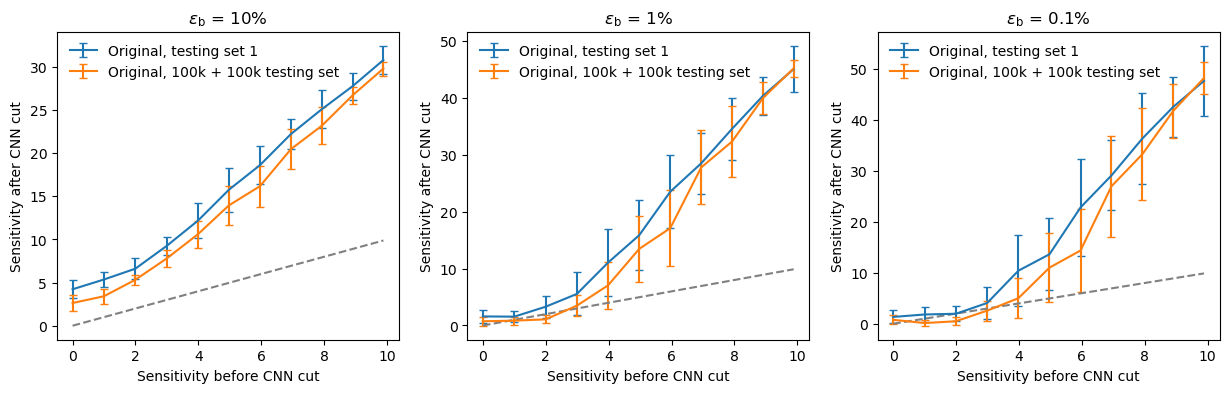

In [5]:
sensitivities_origin, stds_origin = get_realistic_sensitivity_and_std_bkg_subtraction('SB_{:.1f}_25x25', filter_condition="time > '2024-07-04' and time < '2024-07-05'")
sensitivities_origin_4, stds_origin_4 = get_realistic_sensitivity_and_std_bkg_subtraction('SB_{:.1f}_25x25_test4')
print(sensitivities_origin[0][0], stds_origin[0][0])
print(sensitivities_origin_4[0][0], stds_origin_4[0][0])
sensitivities = convert_to_realistic_sensitivity(np.arange(11), nB=n_bkg_in_SR)

fig, ax = plt.subplots(1, 3, figsize=(15, 4))

titles = ['$\epsilon_\mathrm{b}$ = 10%', '$\epsilon_\mathrm{b}$ = 1%', '$\epsilon_\mathrm{b}$ = 0.1%']
for i in range(3):
    ax[i].errorbar(sensitivities, sensitivities_origin[i], yerr=stds_origin[i], marker='', capsize=3, label='Original, testing set 1')
    ax[i].errorbar(sensitivities, sensitivities_origin_4[i], yerr=stds_origin_4[i], marker='', capsize=3, label='Original, 100k + 100k testing set')

    ax[i].plot(sensitivities, sensitivities, '--', color='grey')

    ax[i].set_title(titles[i])
    ax[i].set_xlabel('Sensitivity before CNN cut')
    ax[i].set_ylabel('Sensitivity after CNN cut')

    ax[i].legend(frameon=False, loc='upper left')

plt.savefig('../figures/HVmodel_sensitivity_improvement_origin_bkg_subtraction_larger_testing_set.pdf', dpi=300, facecolor='White', bbox_inches='tight')
plt.show()

2.632960750887155 0.9239196935017489
0.9796320380013336 2.3572798722600794


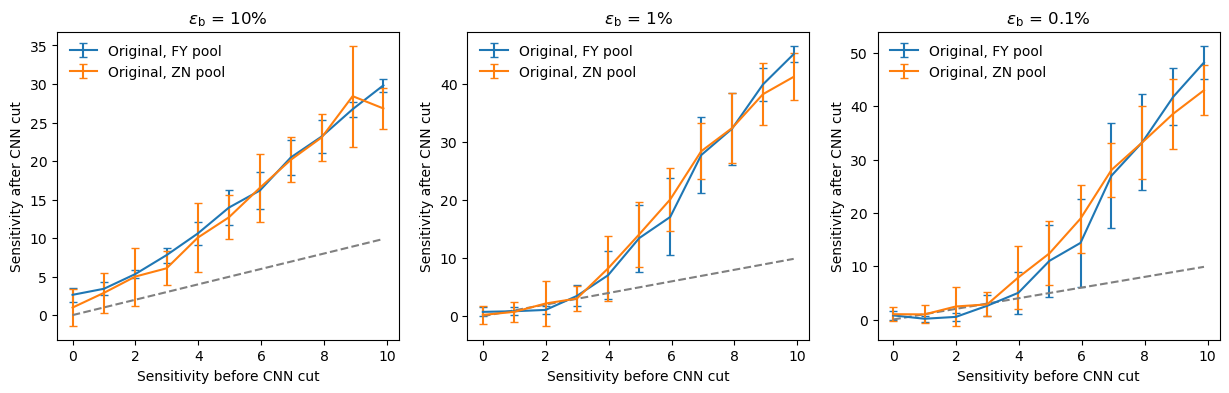

In [6]:
sensitivities_origin, stds_origin = get_realistic_sensitivity_and_std_bkg_subtraction('SB_{:.1f}_25x25_test4')
sensitivities_origin_ZN, stds_origin_ZN = get_realistic_sensitivity_and_std_bkg_subtraction('SB_{:.1f}_25x25_ZN_pool_test4')
sensitivities = convert_to_realistic_sensitivity(np.arange(11), nB=n_bkg_in_SR)

print(sensitivities_origin[0][0], stds_origin[0][0])
print(sensitivities_origin_ZN[0][0], stds_origin_ZN[0][0])

fig, ax = plt.subplots(1, 3, figsize=(15, 4))

titles = ['$\epsilon_\mathrm{b}$ = 10%', '$\epsilon_\mathrm{b}$ = 1%', '$\epsilon_\mathrm{b}$ = 0.1%']
for i in range(3):
    ax[i].errorbar(sensitivities, sensitivities_origin[i], yerr=stds_origin[i], marker='', capsize=3, label='Original, FY pool')
    ax[i].errorbar(sensitivities, sensitivities_origin_ZN[i], yerr=stds_origin_ZN[i], marker='', capsize=3, label='Original, ZN pool')

    ax[i].plot(sensitivities, sensitivities, '--', color='grey')

    ax[i].set_title(titles[i])
    ax[i].set_xlabel('Sensitivity before CNN cut')
    ax[i].set_ylabel('Sensitivity after CNN cut')

    ax[i].legend(frameon=False, loc='upper left')

plt.savefig('../figures/HVmodel_sensitivity_improvement_origin_bkg_subtraction_ZN_pool_larger_testing_set.pdf', dpi=300, facecolor='White', bbox_inches='tight')
plt.show()

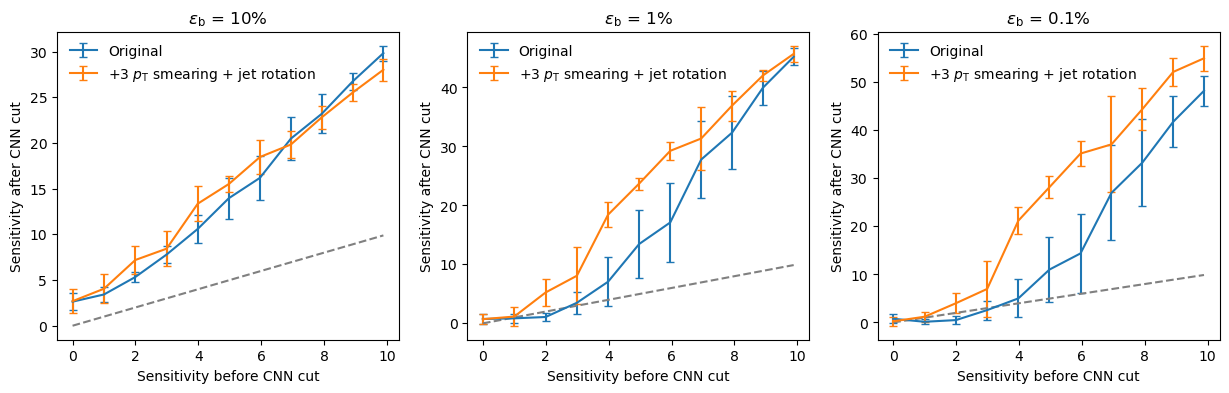

In [7]:
sensitivities_origin, stds_origin = get_realistic_sensitivity_and_std_bkg_subtraction('SB_{:.1f}_25x25_test4')
sensitivities_pt_jet_aug_3, stds_pt_jet_aug_3 = get_realistic_sensitivity_and_std_bkg_subtraction('SB_{:.1f}_pt_jet_aug_3_25x25_test4')

sensitivities = convert_to_realistic_sensitivity(np.arange(11), nB=n_bkg_in_SR)

fig, ax = plt.subplots(1, 3, figsize=(15, 4))

titles = ['$\epsilon_\mathrm{b}$ = 10%', '$\epsilon_\mathrm{b}$ = 1%', '$\epsilon_\mathrm{b}$ = 0.1%']
for i in range(3):
    ax[i].errorbar(sensitivities, sensitivities_origin[i], yerr=stds_origin[i], marker='', capsize=3, label='Original')
    ax[i].errorbar(sensitivities, sensitivities_pt_jet_aug_3[i], yerr=stds_pt_jet_aug_3[i], marker='', capsize=3, label='+3 $p_\mathrm{T}$ smearing + jet rotation')

    ax[i].plot(sensitivities, sensitivities, '--', color='grey')

    ax[i].set_title(titles[i])
    ax[i].set_xlabel('Sensitivity before CNN cut')
    ax[i].set_ylabel('Sensitivity after CNN cut')

    ax[i].legend(frameon=False, loc='upper left')

plt.savefig('../figures/HVmodel_sensitivity_improvement_origin_pt_jet_aug_3_bkg_subtraction_larger_testing_set.pdf', dpi=300, facecolor='White', bbox_inches='tight')
plt.show()

# $p_{\text{T}}$ normalization

2.632960750887155 0.9239196935017489
0.7090565575850002 0.9984358220971828


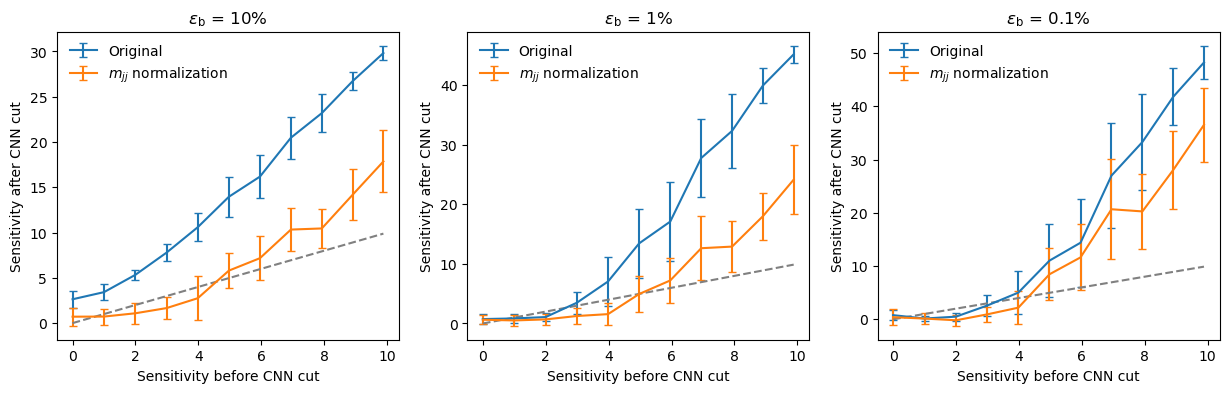

In [6]:
sensitivities_origin, stds_origin = get_realistic_sensitivity_and_std_bkg_subtraction('SB_{:.1f}_25x25_test4')
sensitivities_pt_nor, stds_pt_nor = get_realistic_sensitivity_and_std_bkg_subtraction('SB_{:.1f}_25x25_pt_nor')

print(sensitivities_origin[0][0], stds_origin[0][0])
print(sensitivities_pt_nor[0][0], stds_pt_nor[0][0])

sensitivities = convert_to_realistic_sensitivity(np.arange(11), nB=n_bkg_in_SR)

fig, ax = plt.subplots(1, 3, figsize=(15, 4))

titles = ['$\epsilon_\mathrm{b}$ = 10%', '$\epsilon_\mathrm{b}$ = 1%', '$\epsilon_\mathrm{b}$ = 0.1%']
for i in range(3):
    ax[i].errorbar(sensitivities, sensitivities_origin[i], yerr=stds_origin[i], marker='', capsize=3, label='Original')
    ax[i].errorbar(sensitivities, sensitivities_pt_nor[i], yerr=stds_pt_nor[i], marker='', capsize=3, label='$m_{jj}$ normalization')

    ax[i].plot(sensitivities, sensitivities, '--', color='grey')

    ax[i].set_title(titles[i])
    ax[i].set_xlabel('Sensitivity before CNN cut')
    ax[i].set_ylabel('Sensitivity after CNN cut')

    ax[i].legend(frameon=False, loc='upper left')

plt.savefig('../figures/HVmodel_sensitivity_improvement_origin_mjj_normalied.pdf', dpi=300, facecolor='White', bbox_inches='tight')
plt.show()

2.632960750887155 0.9239196935017489
2.5014005960816057 1.2433088105544259


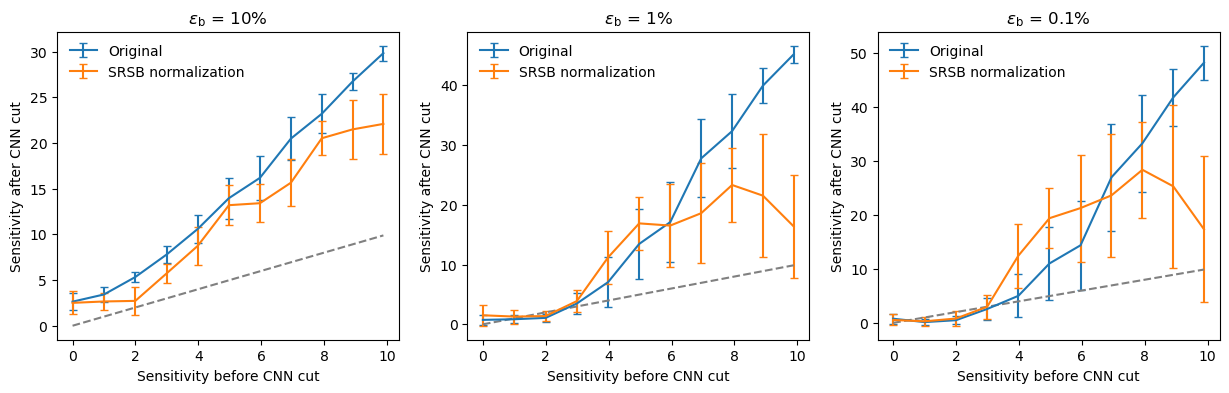

In [6]:
sensitivities_origin, stds_origin = get_realistic_sensitivity_and_std_bkg_subtraction('SB_{:.1f}_25x25_test4')
# sensitivities_pt_nor, stds_pt_nor = get_realistic_sensitivity_and_std_bkg_subtraction('SB_{:.1f}_25x25_pt_nor')
sensitivities_SRSB_norm, stds_SRSB_norm = get_realistic_sensitivity_and_std_bkg_subtraction('SB_{:.1f}_25x25_SRSB_norm')

print(sensitivities_origin[0][0], stds_origin[0][0])
# print(sensitivities_pt_nor[0][0], stds_pt_nor[0][0])
print(sensitivities_SRSB_norm[0][0], stds_SRSB_norm[0][0])

sensitivities = convert_to_realistic_sensitivity(np.arange(11), nB=n_bkg_in_SR)

fig, ax = plt.subplots(1, 3, figsize=(15, 4))

titles = ['$\epsilon_\mathrm{b}$ = 10%', '$\epsilon_\mathrm{b}$ = 1%', '$\epsilon_\mathrm{b}$ = 0.1%']
for i in range(3):
    ax[i].errorbar(sensitivities, sensitivities_origin[i], yerr=stds_origin[i], marker='', capsize=3, label='Original')
    # ax[i].errorbar(sensitivities, sensitivities_pt_nor[i], yerr=stds_pt_nor[i], marker='', capsize=3, label='$m_{jj}$ normalization')
    ax[i].errorbar(sensitivities, sensitivities_SRSB_norm[i], yerr=stds_SRSB_norm[i], marker='', capsize=3, label='SRSB normalization')

    ax[i].plot(sensitivities, sensitivities, '--', color='grey')

    ax[i].set_title(titles[i])
    ax[i].set_xlabel('Sensitivity before CNN cut')
    ax[i].set_ylabel('Sensitivity after CNN cut')

    ax[i].legend(frameon=False, loc='upper left')

plt.savefig('../figures/HVmodel_sensitivity_improvement_origin_SRSB_normalied.pdf', dpi=300, facecolor='White', bbox_inches='tight')
plt.show()

/home/r10222035/.conda/envs/jupyter/lib/python3.8/site-packages/numpy/core/_methods.py:236: RuntimeWarning: invalid value encountered in subtract
  x = asanyarray(arr - arrmean)
/home/r10222035/.conda/envs/jupyter/lib/python3.8/site-packages/numpy/core/_methods.py:45: RuntimeWarning: invalid value encountered in reduce
  return umr_minimum(a, axis, None, out, keepdims, initial, where)
/home/r10222035/.conda/envs/jupyter/lib/python3.8/site-packages/numpy/core/_methods.py:41: RuntimeWarning: invalid value encountered in reduce
  return umr_maximum(a, axis, None, out, keepdims, initial, where)
/home/r10222035/.conda/envs/jupyter/lib/python3.8/site-packages/numpy/core/_methods.py:45: RuntimeWarning: invalid value encountered in reduce
  return umr_minimum(a, axis, None, out, keepdims, initial, where)
/home/r10222035/.conda/envs/jupyter/lib/python3.8/site-packages/numpy/core/_methods.py:41: RuntimeWarning: invalid value encountered in reduce
  return umr_maximum(a, axis, None, out, keepdims

2.632960750887155 0.9239196935017489
1.4198162543797805 0.0
2.902389687938518 2.0002856877707447


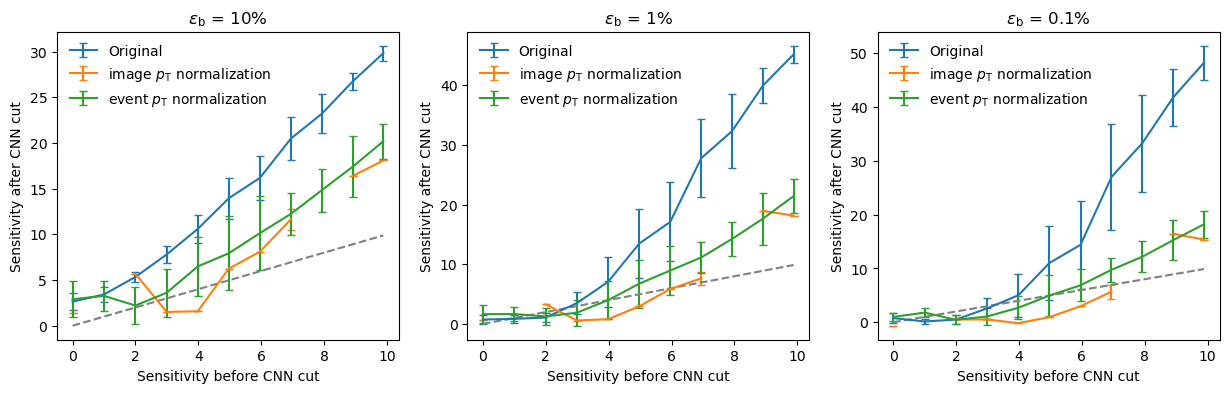

In [6]:
sensitivities_origin, stds_origin = get_realistic_sensitivity_and_std_bkg_subtraction('SB_{:.1f}_25x25_test4')
sensitivities_pT_norm, stds_pT_norm = get_realistic_sensitivity_and_std_bkg_subtraction('SB_{:.1f}_25x25_pT_norm')
sensitivities_pT_norm_2, stds_pT_norm_2 = get_realistic_sensitivity_and_std_bkg_subtraction('SB_{:.1f}_25x25_pT_norm_2')

print(sensitivities_origin[0][0], stds_origin[0][0])
print(sensitivities_pT_norm[0][0], stds_pT_norm[0][0])
print(sensitivities_pT_norm_2[0][0], stds_pT_norm_2[0][0])

sensitivities = convert_to_realistic_sensitivity(np.arange(11), nB=n_bkg_in_SR)

fig, ax = plt.subplots(1, 3, figsize=(15, 4))

titles = ['$\epsilon_\mathrm{b}$ = 10%', '$\epsilon_\mathrm{b}$ = 1%', '$\epsilon_\mathrm{b}$ = 0.1%']
for i in range(3):
    ax[i].errorbar(sensitivities, sensitivities_origin[i], yerr=stds_origin[i], marker='', capsize=3, label='Original')
    ax[i].errorbar(sensitivities, sensitivities_pT_norm[i], yerr=stds_pT_norm[i], marker='', capsize=3, label='image $p_{\mathrm{T}}$ normalization')
    ax[i].errorbar(sensitivities, sensitivities_pT_norm_2[i], yerr=stds_pT_norm_2[i], marker='', capsize=3, label='event $p_{\mathrm{T}}$ normalization')

    ax[i].plot(sensitivities, sensitivities, '--', color='grey')

    ax[i].set_title(titles[i])
    ax[i].set_xlabel('Sensitivity before CNN cut')
    ax[i].set_ylabel('Sensitivity after CNN cut')

    ax[i].legend(frameon=False, loc='upper left')

plt.savefig('../figures/HVmodel_sensitivity_improvement_origin_pT_normalied.pdf', dpi=300, facecolor='White', bbox_inches='tight')
plt.show()

0.0 0.0


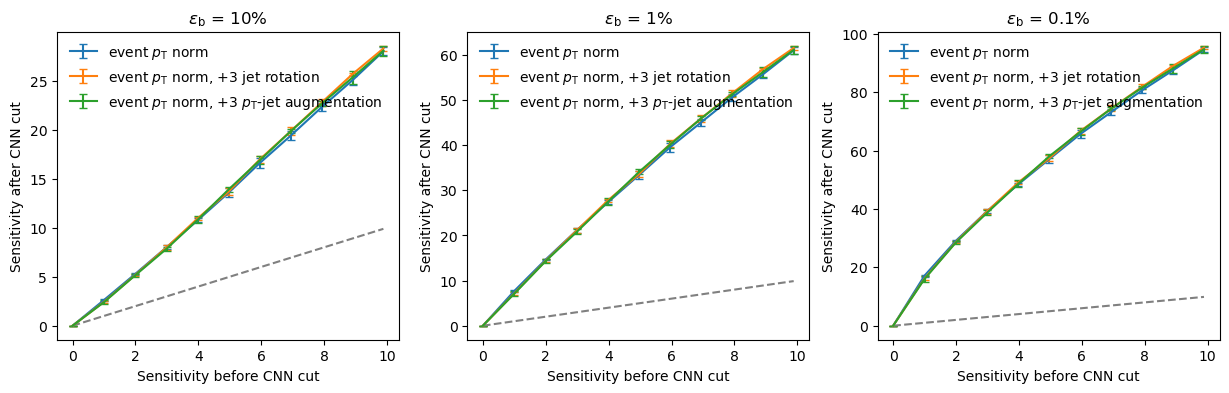

In [7]:
sensitivities_pT_norm_2, stds_pT_norm_2 = get_realistic_sensitivity_and_std('SB_{:.1f}_25x25_pT_norm_2')
sensitivities_event_pT_norm_jet_aug_3, stds_event_pT_norm_jet_aug_3 = get_realistic_sensitivity_and_std('SB_{:.1f}_jet_aug_3_25x25_event_pT_norm')
sensitivities_event_pT_norm_pt_jet_aug_3, stds_event_pT_norm_pt_jet_aug_3 = get_realistic_sensitivity_and_std('SB_{:.1f}_pt_jet_aug_3_25x25_event_pT_norm')

print(sensitivities_pT_norm_2[0][0], stds_pT_norm_2[0][0])

sensitivities = convert_to_realistic_sensitivity(np.arange(11), nB=n_bkg_in_SR)

fig, ax = plt.subplots(1, 3, figsize=(15, 4))

titles = ['$\epsilon_\mathrm{b}$ = 10%', '$\epsilon_\mathrm{b}$ = 1%', '$\epsilon_\mathrm{b}$ = 0.1%']
for i in range(3):
    ax[i].errorbar(sensitivities, sensitivities_pT_norm_2[i], yerr=stds_pT_norm_2[i], marker='', capsize=3, label='event $p_{\mathrm{T}}$ norm')
    ax[i].errorbar(sensitivities, sensitivities_event_pT_norm_jet_aug_3[i], yerr=stds_event_pT_norm_jet_aug_3[i], marker='', capsize=3, label='event $p_{\mathrm{T}}$ norm, +3 jet rotation')
    ax[i].errorbar(sensitivities, sensitivities_event_pT_norm_pt_jet_aug_3[i], yerr=stds_event_pT_norm_pt_jet_aug_3[i], marker='', capsize=3, label='event $p_{\mathrm{T}}$ norm, +3 $p_{\mathrm{T}}$-jet augmentation')

    ax[i].plot(sensitivities, sensitivities, '--', color='grey')

    ax[i].set_title(titles[i])
    ax[i].set_xlabel('Sensitivity before CNN cut')
    ax[i].set_ylabel('Sensitivity after CNN cut')

    ax[i].legend(frameon=False, loc='upper left')

# plt.savefig('../figures/HVmodel_sensitivity_improvement_event_pT_normalied_origin_jet_aug_3_pt_jet_aug_3.pdf', dpi=300, facecolor='White', bbox_inches='tight')
plt.show()

0.0 0.0
0.0 0.0


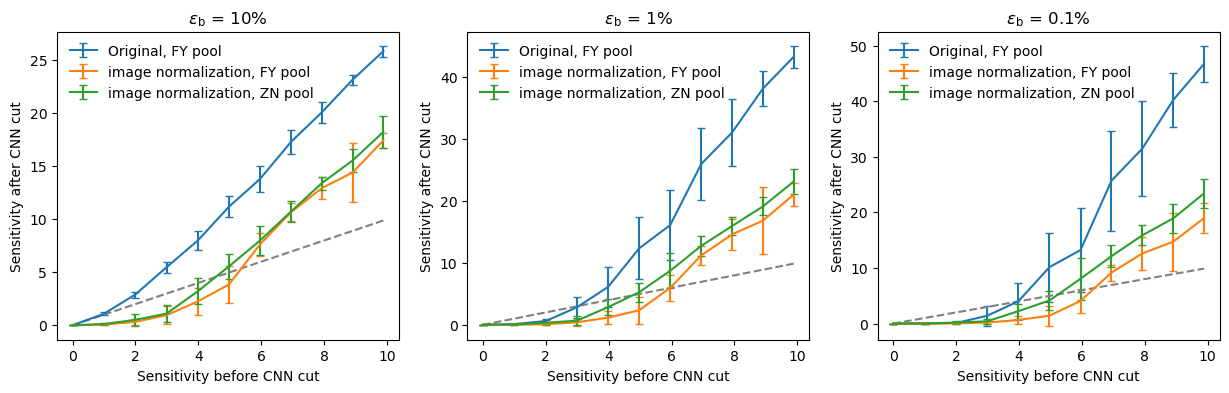

In [5]:
sensitivities_origin, stds_origin = get_realistic_sensitivity_and_std('SB_{:.1f}_25x25_test4')
sensitivities_image_pT_norm_FY, stds_image_pT_norm_FY = get_realistic_sensitivity_and_std('SB_{:.1f}_25x25_image_pT_norm', filter_condition="time > '2024-08-22 09' and time < '2024-08-23'")
sensitivities_image_pT_norm_ZN, stds_image_pT_norm_ZN = get_realistic_sensitivity_and_std('SB_{:.1f}_25x25_image_pT_norm_ZN_pool', filter_condition="time > '2024-08-22 09' and time < '2024-08-23'")

print(sensitivities_origin[0][0], stds_origin[0][0])
print(sensitivities_image_pT_norm_FY[0][0], stds_image_pT_norm_FY[0][0])

sensitivities = convert_to_realistic_sensitivity(np.arange(11), nB=n_bkg_in_SR)

fig, ax = plt.subplots(1, 3, figsize=(15, 4))

titles = ['$\epsilon_\mathrm{b}$ = 10%', '$\epsilon_\mathrm{b}$ = 1%', '$\epsilon_\mathrm{b}$ = 0.1%']
for i in range(3):
    ax[i].errorbar(sensitivities, sensitivities_origin[i], yerr=stds_origin[i], marker='', capsize=3, label='Original, FY pool')
    ax[i].errorbar(sensitivities, sensitivities_image_pT_norm_FY[i], yerr=stds_image_pT_norm_FY[i], marker='', capsize=3, label='image normalization, FY pool')
    ax[i].errorbar(sensitivities, sensitivities_image_pT_norm_ZN[i], yerr=stds_image_pT_norm_ZN[i], marker='', capsize=3, label='image normalization, ZN pool')

    ax[i].plot(sensitivities, sensitivities, '--', color='grey')

    ax[i].set_title(titles[i])
    ax[i].set_xlabel('Sensitivity before CNN cut')
    ax[i].set_ylabel('Sensitivity after CNN cut')

    ax[i].legend(frameon=False, loc='upper left')

plt.savefig('../figures/HVmodel_sensitivity_improvement_origin_image_pt_normalized_FY_ZN_pool.pdf', dpi=300, facecolor='White', bbox_inches='tight')
plt.show()

/tmp/ipykernel_4080453/3566785838.py:47: RuntimeWarning: Mean of empty slice.
  sensitivities[j].append(real_sensitivities.mean())
/home/r10222035/.conda/envs/jupyter/lib/python3.8/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/home/r10222035/.conda/envs/jupyter/lib/python3.8/site-packages/numpy/core/_methods.py:269: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/r10222035/.conda/envs/jupyter/lib/python3.8/site-packages/numpy/core/_methods.py:226: RuntimeWarning: invalid value encountered in divide
  arrmean = um.true_divide(arrmean, div, out=arrmean,
/home/r10222035/.conda/envs/jupyter/lib/python3.8/site-packages/numpy/core/_methods.py:261: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/home/r10222035/.conda/envs/jupyter/lib/python3.8/site-packages/numpy/core/_methods.py:45: Ru

2.632960750887155 0.9239196935017489
6.184475854024704 0.0
2.902389687938518 2.0002856877707447


/home/r10222035/.conda/envs/jupyter/lib/python3.8/site-packages/numpy/core/_methods.py:45: RuntimeWarning: invalid value encountered in reduce
  return umr_minimum(a, axis, None, out, keepdims, initial, where)
/home/r10222035/.conda/envs/jupyter/lib/python3.8/site-packages/numpy/core/_methods.py:41: RuntimeWarning: invalid value encountered in reduce
  return umr_maximum(a, axis, None, out, keepdims, initial, where)
/home/r10222035/.conda/envs/jupyter/lib/python3.8/site-packages/numpy/core/_methods.py:45: RuntimeWarning: invalid value encountered in reduce
  return umr_minimum(a, axis, None, out, keepdims, initial, where)
/home/r10222035/.conda/envs/jupyter/lib/python3.8/site-packages/numpy/core/_methods.py:41: RuntimeWarning: invalid value encountered in reduce
  return umr_maximum(a, axis, None, out, keepdims, initial, where)


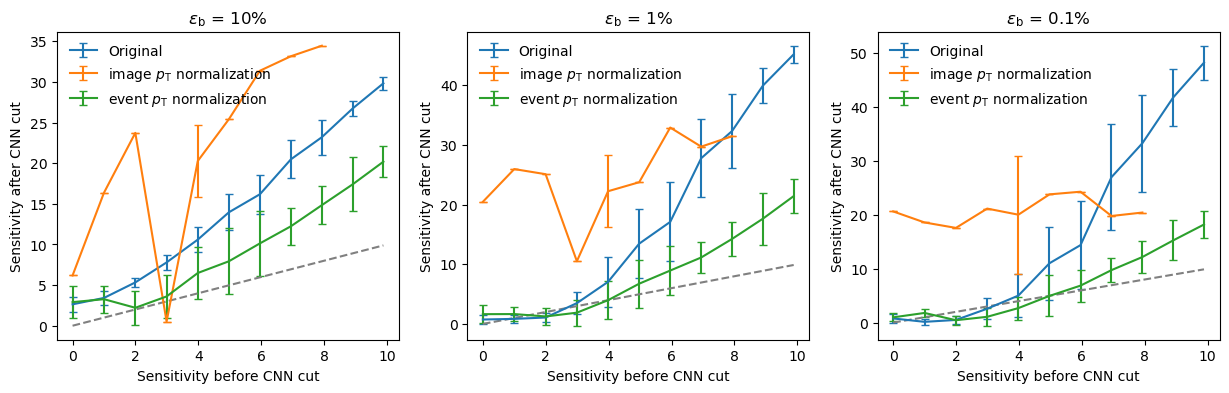

In [15]:
sensitivities_origin, stds_origin = get_realistic_sensitivity_and_std_bkg_subtraction('SB_{:.1f}_25x25_test4')
sensitivities_pT_norm, stds_pT_norm = get_realistic_sensitivity_and_std_bkg_subtraction('SB_{:.1f}_25x25_event_pT_norm_ZN_pool')
sensitivities_pT_norm_2, stds_pT_norm_2 = get_realistic_sensitivity_and_std_bkg_subtraction('SB_{:.1f}_25x25_pT_norm_2')

print(sensitivities_origin[0][0], stds_origin[0][0])
print(sensitivities_pT_norm[0][0], stds_pT_norm[0][0])
print(sensitivities_pT_norm_2[0][0], stds_pT_norm_2[0][0])

sensitivities = convert_to_realistic_sensitivity(np.arange(11), nB=n_bkg_in_SR)

fig, ax = plt.subplots(1, 3, figsize=(15, 4))

titles = ['$\epsilon_\mathrm{b}$ = 10%', '$\epsilon_\mathrm{b}$ = 1%', '$\epsilon_\mathrm{b}$ = 0.1%']
for i in range(3):
    ax[i].errorbar(sensitivities, sensitivities_origin[i], yerr=stds_origin[i], marker='', capsize=3, label='Original')
    ax[i].errorbar(sensitivities, sensitivities_pT_norm[i], yerr=stds_pT_norm[i], marker='', capsize=3, label='image $p_{\mathrm{T}}$ normalization')
    ax[i].errorbar(sensitivities, sensitivities_pT_norm_2[i], yerr=stds_pT_norm_2[i], marker='', capsize=3, label='event $p_{\mathrm{T}}$ normalization')

    ax[i].plot(sensitivities, sensitivities, '--', color='grey')

    ax[i].set_title(titles[i])
    ax[i].set_xlabel('Sensitivity before CNN cut')
    ax[i].set_ylabel('Sensitivity after CNN cut')

    ax[i].legend(frameon=False, loc='upper left')

# plt.savefig('../figures/HVmodel_sensitivity_improvement_origin_pT_normalied.pdf', dpi=300, facecolor='White', bbox_inches='tight')
plt.show()

[[0.0, 10.234064873459436], [0.0, 9.420064700249075], [0.0, 7.226759351491056]] [[0.0, 1.1083727622690798], [0.0, 3.4227478218135325], [0.0, 3.8919350211220514]]
[[0.0, 9.492403293987541], [0.0, 8.244195777451797], [0.0, 5.944133134372314]] [[0.0, 1.209869739752269], [0.0, 2.82004858852416], [0.0, 3.446641506447441]]


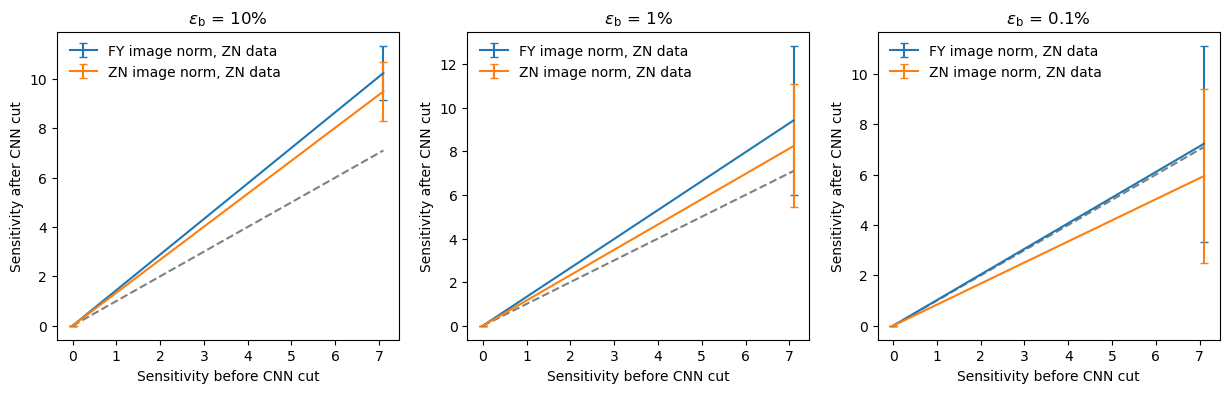

In [6]:
model_sensitivities = [0, 7.1]
res = 25
models = [f'SB_0.0_25x25_image_norm_ZN_data', f'SB_7.1_25x25_image_norm_ZN_data']
sensitivities_origin, stds_origin = get_realistic_sensitivity_and_std_from_models(models, model_sensitivities)
print(sensitivities_origin, stds_origin)

models = [f'SB_0.0_25x25_ZN_image_norm_data', f'SB_7.1_25x25_ZN_image_norm_data']
sensitivities_FY, stds_FY = get_realistic_sensitivity_and_std_from_models(models, model_sensitivities)
print(sensitivities_FY, stds_FY)

fig, ax = plt.subplots(1, 3, figsize=(15, 4))

titles = ['$\epsilon_\mathrm{b}$ = 10%', '$\epsilon_\mathrm{b}$ = 1%', '$\epsilon_\mathrm{b}$ = 0.1%']
for i in range(3):

    ax[i].errorbar(model_sensitivities, sensitivities_origin[i], yerr=stds_origin[i], marker='', capsize=3, label='FY image norm, ZN data')
    ax[i].errorbar(model_sensitivities, sensitivities_FY[i], yerr=stds_FY[i], marker='', capsize=3, label='ZN image norm, ZN data')

    ax[i].set_title(titles[i])
    ax[i].plot(model_sensitivities, model_sensitivities, '--', color='grey')
    # ax[i].set_ylim(-0.5, 5.5)
    ax[i].set_xlabel('Sensitivity before CNN cut')
    ax[i].set_ylabel('Sensitivity after CNN cut')

    ax[i].legend(frameon=False, loc='upper left')

plt.savefig(f'../figures/HVmodel_sensitivity_improvement_SB_0_7_ZN_data_res_{res}.pdf', dpi=300, facecolor='White', bbox_inches='tight')
plt.show()

# Data augmentation with image normalization

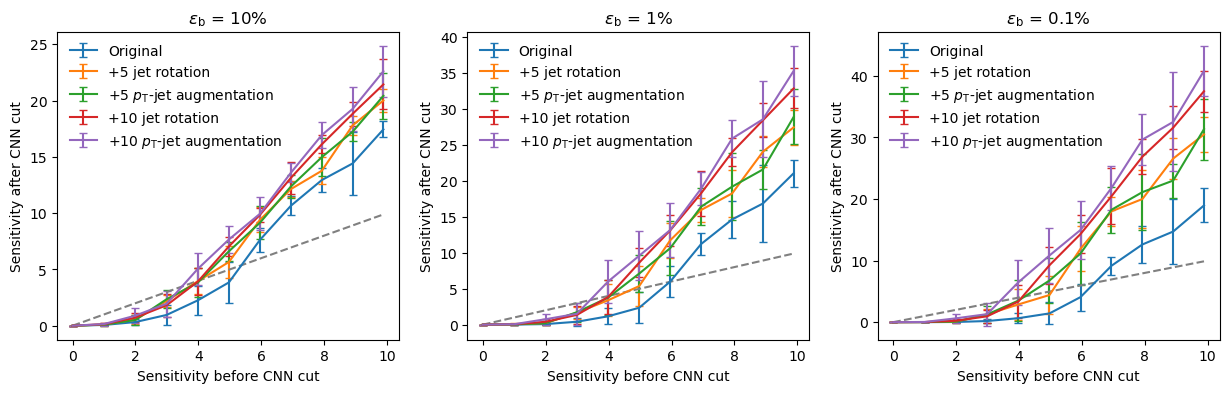

In [5]:
sensitivities_image_pT_norm_FY, stds_image_pT_norm_FY = get_realistic_sensitivity_and_std('SB_{:.1f}_25x25_image_pT_norm')
sensitivities_image_pT_norm_jet_aug_5, stds_image_pT_norm_jet_aug_5 = get_realistic_sensitivity_and_std('SB_{:.1f}_jet_aug_5_25x25_image_pT_norm')
sensitivities_image_pT_norm_jet_aug_10, stds_image_pT_norm_jet_aug_10 = get_realistic_sensitivity_and_std('SB_{:.1f}_jet_aug_10_25x25_image_pT_norm')
sensitivities_image_pT_norm_pt_jet_aug_5, stds_image_pT_norm_pt_jet_aug_5 = get_realistic_sensitivity_and_std('SB_{:.1f}_pt_jet_aug_5_25x25_image_pT_norm')
sensitivities_image_pT_norm_pt_jet_aug_10, stds_image_pT_norm_pt_jet_aug_10 = get_realistic_sensitivity_and_std('SB_{:.1f}_pt_jet_aug_10_25x25_image_pT_norm')

sensitivities = convert_to_realistic_sensitivity(np.arange(11), nB=n_bkg_in_SR)

fig, ax = plt.subplots(1, 3, figsize=(15, 4))

titles = ['$\epsilon_\mathrm{b}$ = 10%', '$\epsilon_\mathrm{b}$ = 1%', '$\epsilon_\mathrm{b}$ = 0.1%']
for i in range(3):
    ax[i].errorbar(sensitivities, sensitivities_image_pT_norm_FY[i], yerr=stds_image_pT_norm_FY[i], marker='', capsize=3, label='Original')
    ax[i].errorbar(sensitivities, sensitivities_image_pT_norm_jet_aug_5[i], yerr=stds_image_pT_norm_jet_aug_5[i], marker='', capsize=3, label='+5 jet rotation')
    ax[i].errorbar(sensitivities, sensitivities_image_pT_norm_pt_jet_aug_5[i], yerr=stds_image_pT_norm_pt_jet_aug_5[i], marker='', capsize=3, label='+5 $p_{\mathrm{T}}$-jet augmentation')
    ax[i].errorbar(sensitivities, sensitivities_image_pT_norm_jet_aug_10[i], yerr=stds_image_pT_norm_jet_aug_10[i], marker='', capsize=3, label='+10 jet rotation')
    ax[i].errorbar(sensitivities, sensitivities_image_pT_norm_pt_jet_aug_10[i], yerr=stds_image_pT_norm_pt_jet_aug_10[i], marker='', capsize=3, label='+10 $p_{\mathrm{T}}$-jet augmentation')

    ax[i].plot(sensitivities, sensitivities, '--', color='grey')

    ax[i].set_title(titles[i])
    ax[i].set_xlabel('Sensitivity before CNN cut')
    ax[i].set_ylabel('Sensitivity after CNN cut')

    ax[i].legend(frameon=False, loc='upper left')

plt.savefig('../figures/HVmodel_sensitivity_improvement_image_pT_normalied_origin_jet_aug_pt_jet_aug_5_10.pdf', dpi=300, facecolor='White', bbox_inches='tight')
plt.show()

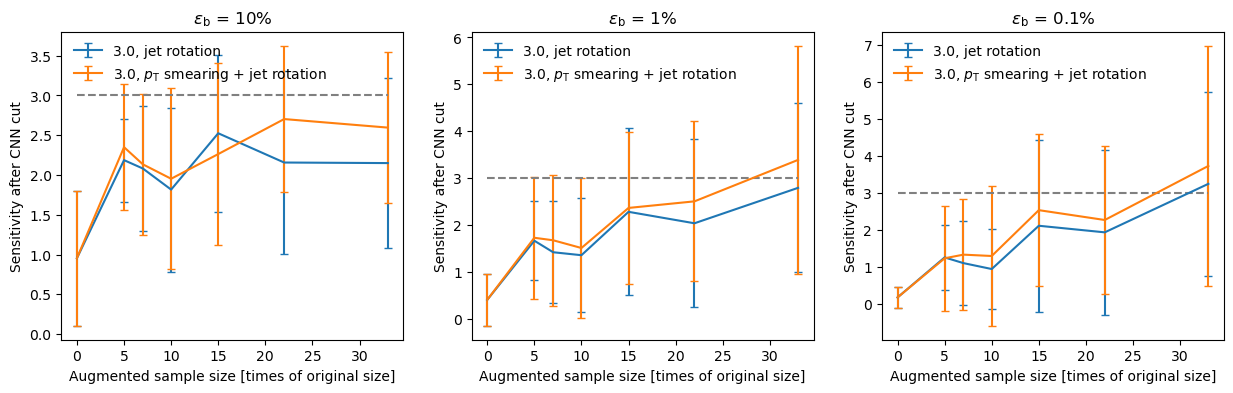

In [5]:
sample_size = [5, 7, 10, 15, 22, 33]
# sample_size = [ 5,  10, ]
res = 25
models = [f'SB_3.0_{res}x{res}_image_pT_norm'] + [f'SB_3.0_jet_aug_{n}_{res}x{res}_image_pT_norm' for n in sample_size]
sensitivities_jet_aug_3, stds_jet_aug_3 = get_realistic_sensitivity_and_std_from_models(models, model_sensitivities=[3.0]*len(models))

models = [f'SB_3.0_{res}x{res}_image_pT_norm'] + [f'SB_3.0_pt_jet_aug_{n}_{res}x{res}_image_pT_norm' for n in sample_size]
sensitivities_pt_jet_aug_3, stds_pt_jet_aug_3 = get_realistic_sensitivity_and_std_from_models(models, model_sensitivities=[3.0]*len(models))


fig, ax = plt.subplots(1, 3, figsize=(15, 4))

titles = ['$\epsilon_\mathrm{b}$ = 10%', '$\epsilon_\mathrm{b}$ = 1%', '$\epsilon_\mathrm{b}$ = 0.1%']
for i in range(3):

    ax[i].errorbar([0] + sample_size, sensitivities_jet_aug_3[i], yerr=stds_jet_aug_3[i], marker='', capsize=3, label='3.0, jet rotation')
    ax[i].errorbar([0] + sample_size, sensitivities_pt_jet_aug_3[i], yerr=stds_pt_jet_aug_3[i], marker='', capsize=3, label='3.0, $p_\mathrm{T}$ smearing + jet rotation')

    ax[i].set_title(titles[i])
    ax[i].hlines(3, 0, sample_size[-1], color='gray', linestyle='--')
    # ax[i].set_ylim(-0.5, 30)
    ax[i].set_xlabel('Augmented sample size [times of original size]')
    ax[i].set_ylabel('Sensitivity after CNN cut')

    ax[i].legend(frameon=False, loc='upper left')

plt.savefig(f'../figures/HVmodel_sensitivity_improvement_image_pT_normalied_aug_3_to_33_SB_3.pdf', dpi=300, facecolor='White', bbox_inches='tight')
plt.show()

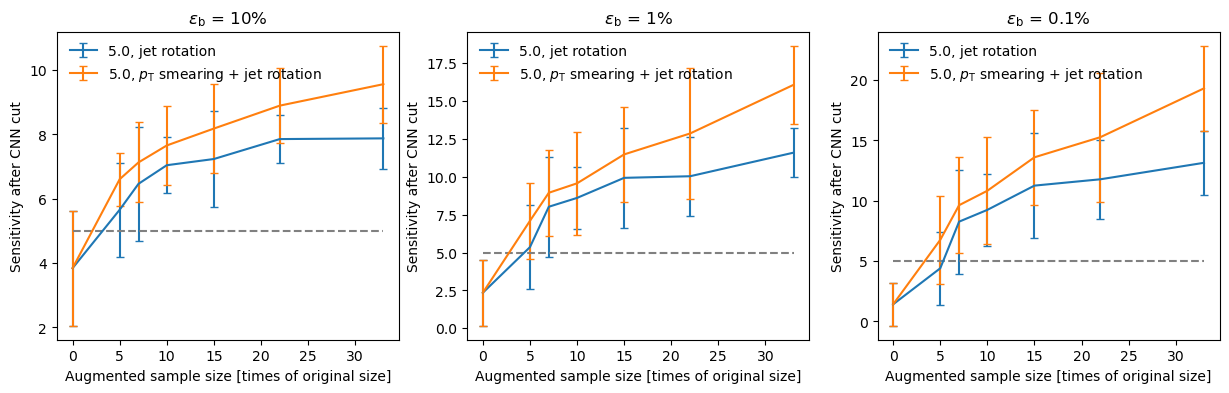

In [16]:
sample_size = [5, 7, 10, 15, 22, 33]
res = 25
s = 5.0
models = [f'SB_5.0_{res}x{res}_image_pT_norm'] + [f'SB_5.0_jet_aug_{n}_{res}x{res}_image_pT_norm' for n in sample_size]
sensitivities_jet_aug_3, stds_jet_aug_3 = get_realistic_sensitivity_and_std_from_models(models, model_sensitivities=[s]*len(models))

models = [f'SB_5.0_{res}x{res}_image_pT_norm'] + [f'SB_5.0_pt_jet_aug_{n}_{res}x{res}_image_pT_norm' for n in sample_size]
sensitivities_pt_jet_aug_3, stds_pt_jet_aug_3 = get_realistic_sensitivity_and_std_from_models(models, model_sensitivities=[s]*len(models))


fig, ax = plt.subplots(1, 3, figsize=(15, 4))

titles = ['$\epsilon_\mathrm{b}$ = 10%', '$\epsilon_\mathrm{b}$ = 1%', '$\epsilon_\mathrm{b}$ = 0.1%']
for i in range(3):

    ax[i].errorbar([0] + sample_size, sensitivities_jet_aug_3[i], yerr=stds_jet_aug_3[i], marker='', capsize=3, label='5.0, jet rotation')
    ax[i].errorbar([0] + sample_size, sensitivities_pt_jet_aug_3[i], yerr=stds_pt_jet_aug_3[i], marker='', capsize=3, label='5.0, $p_\mathrm{T}$ smearing + jet rotation')

    ax[i].set_title(titles[i])
    ax[i].hlines(s, 0, sample_size[-1], color='gray', linestyle='--')
    # ax[i].set_ylim(-0.5, 30)
    ax[i].set_xlabel('Augmented sample size [times of original size]')
    ax[i].set_ylabel('Sensitivity after CNN cut')

    ax[i].legend(frameon=False, loc='upper left')

plt.savefig(f'../figures/HVmodel_sensitivity_improvement_image_pT_normalied_aug_3_to_33_SB_5.pdf', dpi=300, facecolor='White', bbox_inches='tight')
plt.show()

# Data augmentation with event normalization

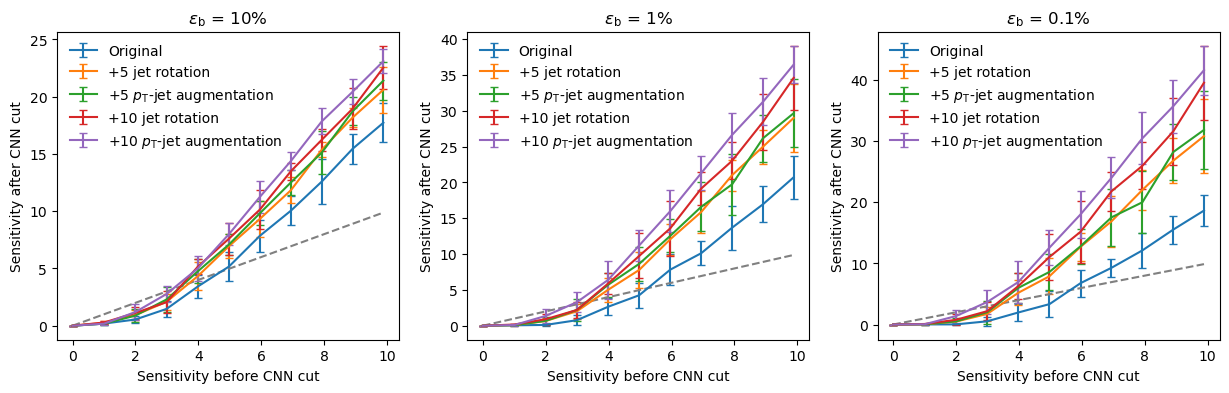

In [5]:
sensitivities_event_pT_norm_FY, stds_event_pT_norm_FY = get_realistic_sensitivity_and_std('SB_{:.1f}_25x25_event_pT_norm')
sensitivities_event_pT_norm_jet_aug_5, stds_event_pT_norm_jet_aug_5 = get_realistic_sensitivity_and_std('SB_{:.1f}_jet_aug_5_25x25_event_pT_norm')
sensitivities_event_pT_norm_jet_aug_10, stds_event_pT_norm_jet_aug_10 = get_realistic_sensitivity_and_std('SB_{:.1f}_jet_aug_10_25x25_event_pT_norm')
sensitivities_event_pT_norm_pt_jet_aug_5, stds_event_pT_norm_pt_jet_aug_5 = get_realistic_sensitivity_and_std('SB_{:.1f}_pt_jet_aug_5_25x25_event_pT_norm')
sensitivities_event_pT_norm_pt_jet_aug_10, stds_event_pT_norm_pt_jet_aug_10 = get_realistic_sensitivity_and_std('SB_{:.1f}_pt_jet_aug_10_25x25_event_pT_norm')

sensitivities = convert_to_realistic_sensitivity(np.arange(11), nB=n_bkg_in_SR)

fig, ax = plt.subplots(1, 3, figsize=(15, 4))

titles = ['$\epsilon_\mathrm{b}$ = 10%', '$\epsilon_\mathrm{b}$ = 1%', '$\epsilon_\mathrm{b}$ = 0.1%']
for i in range(3):
    ax[i].errorbar(sensitivities, sensitivities_event_pT_norm_FY[i], yerr=stds_event_pT_norm_FY[i], marker='', capsize=3, label='Original')
    ax[i].errorbar(sensitivities, sensitivities_event_pT_norm_jet_aug_5[i], yerr=stds_event_pT_norm_jet_aug_5[i], marker='', capsize=3, label='+5 jet rotation')
    ax[i].errorbar(sensitivities, sensitivities_event_pT_norm_pt_jet_aug_5[i], yerr=stds_event_pT_norm_pt_jet_aug_5[i], marker='', capsize=3, label='+5 $p_{\mathrm{T}}$-jet augmentation')
    ax[i].errorbar(sensitivities, sensitivities_event_pT_norm_jet_aug_10[i], yerr=stds_event_pT_norm_jet_aug_10[i], marker='', capsize=3, label='+10 jet rotation')
    ax[i].errorbar(sensitivities, sensitivities_event_pT_norm_pt_jet_aug_10[i], yerr=stds_event_pT_norm_pt_jet_aug_10[i], marker='', capsize=3, label='+10 $p_{\mathrm{T}}$-jet augmentation')

    ax[i].plot(sensitivities, sensitivities, '--', color='grey')

    ax[i].set_title(titles[i])
    ax[i].set_xlabel('Sensitivity before CNN cut')
    ax[i].set_ylabel('Sensitivity after CNN cut')

    ax[i].legend(frameon=False, loc='upper left')

plt.savefig('../figures/HVmodel_sensitivity_improvement_event_pT_normalied_origin_jet_aug_pt_jet_aug_5_10.pdf', dpi=300, facecolor='White', bbox_inches='tight')
plt.show()

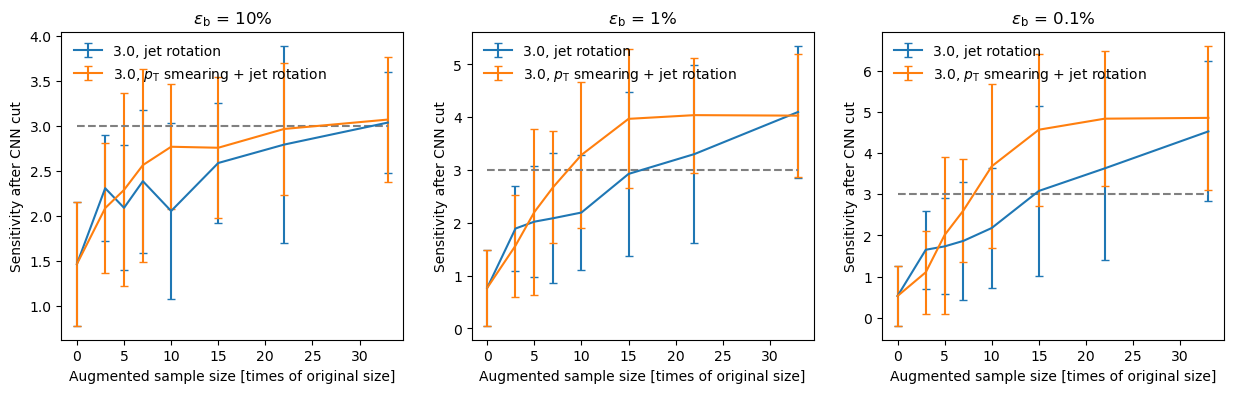

In [6]:
sample_size = [3, 5, 7, 10, 15, 22, 33]
s = 3.0
res = 25
models = [f'SB_{s:.1f}_{res}x{res}_event_pT_norm'] + [f'SB_{s:.1f}_jet_aug_{n}_{res}x{res}_event_pT_norm' for n in sample_size]
sensitivities_jet_aug_3, stds_jet_aug_3 = get_realistic_sensitivity_and_std_from_models(models, model_sensitivities=[s]*len(models))

models = [f'SB_{s:.1f}_{res}x{res}_event_pT_norm'] + [f'SB_{s:.1f}_pt_jet_aug_{n}_{res}x{res}_event_pT_norm' for n in sample_size]
sensitivities_pt_jet_aug_3, stds_pt_jet_aug_3 = get_realistic_sensitivity_and_std_from_models(models, model_sensitivities=[s]*len(models))

fig, ax = plt.subplots(1, 3, figsize=(15, 4))

titles = ['$\epsilon_\mathrm{b}$ = 10%', '$\epsilon_\mathrm{b}$ = 1%', '$\epsilon_\mathrm{b}$ = 0.1%']
for i in range(3):

    ax[i].errorbar([0] + sample_size, sensitivities_jet_aug_3[i], yerr=stds_jet_aug_3[i], marker='', capsize=3, label=f'{s:.1f}, jet rotation')
    ax[i].errorbar([0] + sample_size, sensitivities_pt_jet_aug_3[i], yerr=stds_pt_jet_aug_3[i], marker='', capsize=3, label=f'{s:.1f},'+' $p_\mathrm{T}$ smearing + jet rotation')

    ax[i].set_title(titles[i])
    ax[i].hlines(s, 0, sample_size[-1], color='gray', linestyle='--')
    # ax[i].set_ylim(-0.5, 30)
    ax[i].set_xlabel('Augmented sample size [times of original size]')
    ax[i].set_ylabel('Sensitivity after CNN cut')

    ax[i].legend(frameon=False, loc='upper left')

plt.savefig(f'../figures/HVmodel_sensitivity_improvement_event_pT_normalied_aug_3_to_33_SB_3.pdf', dpi=300, facecolor='White', bbox_inches='tight')
plt.show()

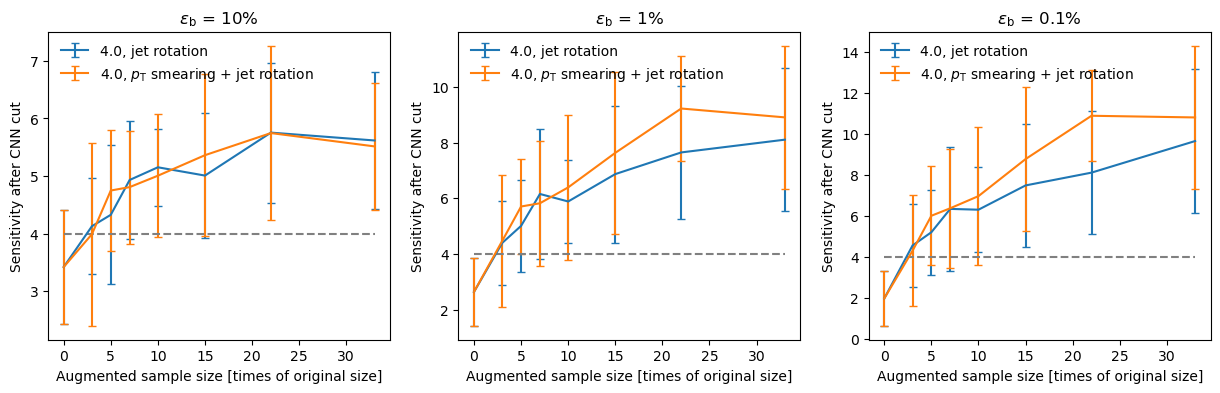

In [7]:
sample_size = [3, 5, 7, 10, 15, 22, 33]
s = 4.0
res = 25
models = [f'SB_{s:.1f}_{res}x{res}_event_pT_norm'] + [f'SB_{s:.1f}_jet_aug_{n}_{res}x{res}_event_pT_norm' for n in sample_size]
sensitivities_jet_aug_3, stds_jet_aug_3 = get_realistic_sensitivity_and_std_from_models(models, model_sensitivities=[s]*len(models))

models = [f'SB_{s:.1f}_{res}x{res}_event_pT_norm'] + [f'SB_{s:.1f}_pt_jet_aug_{n}_{res}x{res}_event_pT_norm' for n in sample_size]
sensitivities_pt_jet_aug_3, stds_pt_jet_aug_3 = get_realistic_sensitivity_and_std_from_models(models, model_sensitivities=[s]*len(models))


fig, ax = plt.subplots(1, 3, figsize=(15, 4))

titles = ['$\epsilon_\mathrm{b}$ = 10%', '$\epsilon_\mathrm{b}$ = 1%', '$\epsilon_\mathrm{b}$ = 0.1%']
for i in range(3):

    ax[i].errorbar([0] + sample_size, sensitivities_jet_aug_3[i], yerr=stds_jet_aug_3[i], marker='', capsize=3, label=f'{s:.1f}, jet rotation')
    ax[i].errorbar([0] + sample_size, sensitivities_pt_jet_aug_3[i], yerr=stds_pt_jet_aug_3[i], marker='', capsize=3, label=f'{s:.1f},'+' $p_\mathrm{T}$ smearing + jet rotation')

    ax[i].set_title(titles[i])
    ax[i].hlines(s, 0, sample_size[-1], color='gray', linestyle='--')
    # ax[i].set_ylim(-0.5, 30)
    ax[i].set_xlabel('Augmented sample size [times of original size]')
    ax[i].set_ylabel('Sensitivity after CNN cut')

    ax[i].legend(frameon=False, loc='upper left')

plt.savefig(f'../figures/HVmodel_sensitivity_improvement_event_pT_normalied_aug_3_to_33_SB_4.pdf', dpi=300, facecolor='White', bbox_inches='tight')
plt.show()

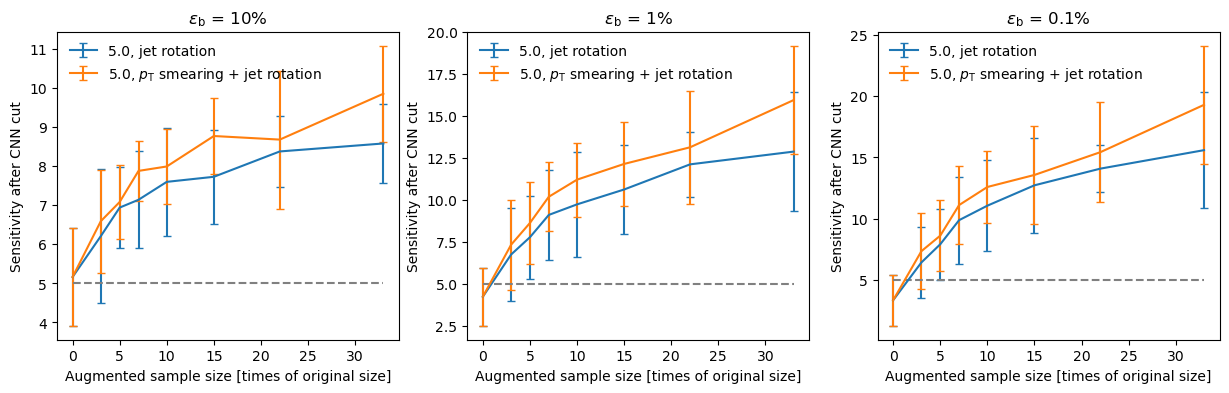

In [8]:
sample_size = [3, 5, 7, 10, 15, 22, 33]
s = 5.0
res = 25
models = [f'SB_{s:.1f}_{res}x{res}_event_pT_norm'] + [f'SB_{s:.1f}_jet_aug_{n}_{res}x{res}_event_pT_norm' for n in sample_size]
sensitivities_jet_aug_3, stds_jet_aug_3 = get_realistic_sensitivity_and_std_from_models(models, model_sensitivities=[s]*len(models))

models = [f'SB_{s:.1f}_{res}x{res}_event_pT_norm'] + [f'SB_{s:.1f}_pt_jet_aug_{n}_{res}x{res}_event_pT_norm' for n in sample_size]
sensitivities_pt_jet_aug_3, stds_pt_jet_aug_3 = get_realistic_sensitivity_and_std_from_models(models, model_sensitivities=[s]*len(models))

fig, ax = plt.subplots(1, 3, figsize=(15, 4))

titles = ['$\epsilon_\mathrm{b}$ = 10%', '$\epsilon_\mathrm{b}$ = 1%', '$\epsilon_\mathrm{b}$ = 0.1%']
for i in range(3):

    ax[i].errorbar([0] + sample_size, sensitivities_jet_aug_3[i], yerr=stds_jet_aug_3[i], marker='', capsize=3, label=f'{s:.1f}, jet rotation')
    ax[i].errorbar([0] + sample_size, sensitivities_pt_jet_aug_3[i], yerr=stds_pt_jet_aug_3[i], marker='', capsize=3, label=f'{s:.1f},'+' $p_\mathrm{T}$ smearing + jet rotation')

    ax[i].set_title(titles[i])
    ax[i].hlines(s, 0, sample_size[-1], color='gray', linestyle='--')
    # ax[i].set_ylim(-0.5, 30)
    ax[i].set_xlabel('Augmented sample size [times of original size]')
    ax[i].set_ylabel('Sensitivity after CNN cut')

    ax[i].legend(frameon=False, loc='upper left')

plt.savefig(f'../figures/HVmodel_sensitivity_improvement_event_pT_normalied_aug_3_to_33_SB_5.pdf', dpi=300, facecolor='White', bbox_inches='tight')
plt.show()

# Dropout with event normalization

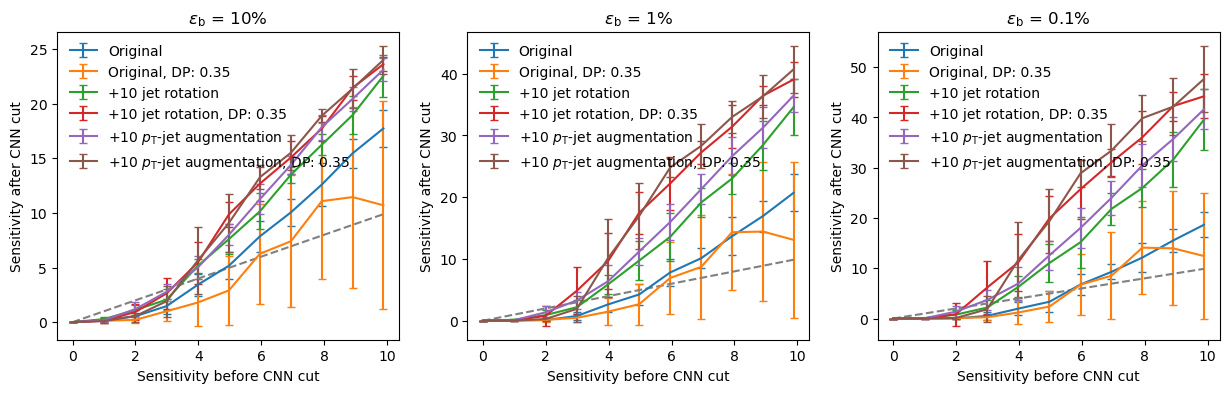

In [6]:
sensitivities_event_pT_norm_FY, stds_event_pT_norm_FY = get_realistic_sensitivity_and_std('SB_{:.1f}_25x25_event_pT_norm')
sensitivities_event_pT_norm_dp_035, stds_event_pT_norm_dp_035 = get_realistic_sensitivity_and_std('SB_{:.1f}_25x25_event_pT_norm_dp_035')
sensitivities_event_pT_norm_jet_aug_10_dp_035, stds_event_pT_norm_jet_aug_10_dp_035 = get_realistic_sensitivity_and_std('SB_{:.1f}_jet_aug_10_25x25_event_pT_norm_dp_035')
sensitivities_event_pT_norm_pt_jet_aug_10_dp_035, stds_event_pT_norm_pt_jet_aug_10_dp_035 = get_realistic_sensitivity_and_std('SB_{:.1f}_pt_jet_aug_10_25x25_event_pT_norm_dp_035')
sensitivities_event_pT_norm_jet_aug_10, stds_event_pT_norm_jet_aug_10 = get_realistic_sensitivity_and_std('SB_{:.1f}_jet_aug_10_25x25_event_pT_norm')
sensitivities_event_pT_norm_pt_jet_aug_10, stds_event_pT_norm_pt_jet_aug_10 = get_realistic_sensitivity_and_std('SB_{:.1f}_pt_jet_aug_10_25x25_event_pT_norm')


sensitivities = convert_to_realistic_sensitivity(np.arange(11), nB=n_bkg_in_SR)

fig, ax = plt.subplots(1, 3, figsize=(15, 4))

titles = ['$\\epsilon_\\mathrm{b}$ = 10%', '$\\epsilon_\\mathrm{b}$ = 1%', '$\\epsilon_\\mathrm{b}$ = 0.1%']
for i in range(3):
    ax[i].errorbar(sensitivities, sensitivities_event_pT_norm_FY[i], yerr=stds_event_pT_norm_FY[i], marker='', capsize=3, label='Original')
    ax[i].errorbar(sensitivities, sensitivities_event_pT_norm_dp_035[i], yerr=stds_event_pT_norm_dp_035[i], marker='', capsize=3, label='Original, DP: 0.35')
    ax[i].errorbar(sensitivities, sensitivities_event_pT_norm_jet_aug_10[i], yerr=stds_event_pT_norm_jet_aug_10[i], marker='', capsize=3, label='+10 jet rotation')
    ax[i].errorbar(sensitivities, sensitivities_event_pT_norm_jet_aug_10_dp_035[i], yerr=stds_event_pT_norm_jet_aug_10_dp_035[i], marker='', capsize=3, label='+10 jet rotation, DP: 0.35')
    ax[i].errorbar(sensitivities, sensitivities_event_pT_norm_pt_jet_aug_10[i], yerr=stds_event_pT_norm_pt_jet_aug_10[i], marker='', capsize=3, label='+10 $p_{\\mathrm{T}}$-jet augmentation')
    ax[i].errorbar(sensitivities, sensitivities_event_pT_norm_pt_jet_aug_10_dp_035[i], yerr=stds_event_pT_norm_pt_jet_aug_10_dp_035[i], marker='', capsize=3, label='+10 $p_{\\mathrm{T}}$-jet augmentation, DP: 0.35')

    ax[i].plot(sensitivities, sensitivities, '--', color='grey')

    ax[i].set_title(titles[i])
    ax[i].set_xlabel('Sensitivity before CNN cut')
    ax[i].set_ylabel('Sensitivity after CNN cut')

    ax[i].legend(frameon=False, loc='upper left')

# plt.savefig('../figures/HVmodel_sensitivity_improvement_event_pT_normalied_dp_035_origin_jet_aug_pt_jet_aug_10.pdf', dpi=300, facecolor='White', bbox_inches='tight')
plt.show()

/tmp/ipykernel_53200/355965659.py:163: RuntimeWarning: Mean of empty slice.
  sensitivities[j].append(real_sensitivities.mean())
/home/fyhsieh/miniconda3/envs/jupyter/lib/python3.12/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/home/fyhsieh/miniconda3/envs/jupyter/lib/python3.12/site-packages/numpy/core/_methods.py:206: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/fyhsieh/miniconda3/envs/jupyter/lib/python3.12/site-packages/numpy/core/_methods.py:163: RuntimeWarning: invalid value encountered in divide
  arrmean = um.true_divide(arrmean, div, out=arrmean,
/home/fyhsieh/miniconda3/envs/jupyter/lib/python3.12/site-packages/numpy/core/_methods.py:198: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


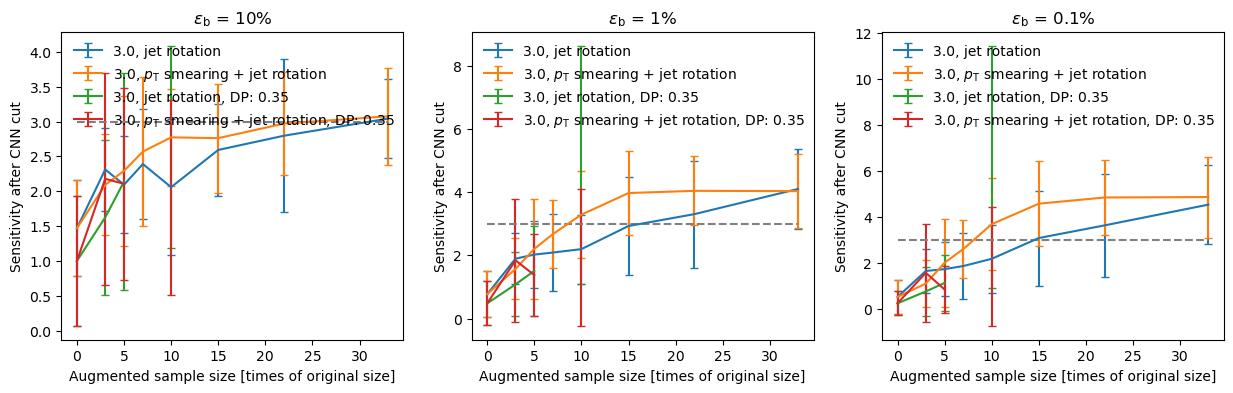

In [11]:
sample_size = [3, 5, 7, 10, 15, 22, 33]
s = 3.0
res = 25
models = [f'SB_{s:.1f}_{res}x{res}_event_pT_norm'] + [f'SB_{s:.1f}_jet_aug_{n}_{res}x{res}_event_pT_norm' for n in sample_size]
sensitivities_jet_aug_3, stds_jet_aug_3 = get_realistic_sensitivity_and_std_from_models(models, model_sensitivities=[s]*len(models))

models = [f'SB_{s:.1f}_{res}x{res}_event_pT_norm'] + [f'SB_{s:.1f}_pt_jet_aug_{n}_{res}x{res}_event_pT_norm' for n in sample_size]
sensitivities_pt_jet_aug_3, stds_pt_jet_aug_3 = get_realistic_sensitivity_and_std_from_models(models, model_sensitivities=[s]*len(models))

models = [f'SB_{s:.1f}_{res}x{res}_event_pT_norm_dp_035'] + [f'SB_{s:.1f}_jet_aug_{n}_{res}x{res}_event_pT_norm_dp_035' for n in sample_size]
sensitivities_jet_aug_3_dp_035, stds_jet_aug_3_dp_035 = get_realistic_sensitivity_and_std_from_models(models, model_sensitivities=[s]*len(models))

models = [f'SB_{s:.1f}_{res}x{res}_event_pT_norm_dp_035'] + [f'SB_{s:.1f}_pt_jet_aug_{n}_{res}x{res}_event_pT_norm_dp_035' for n in sample_size]
sensitivities_pt_jet_aug_3_dp_035, stds_pt_jet_aug_3_dp_035 = get_realistic_sensitivity_and_std_from_models(models, model_sensitivities=[s]*len(models))

fig, ax = plt.subplots(1, 3, figsize=(15, 4))

titles = ['$\\epsilon_\\mathrm{b}$ = 10%', '$\\epsilon_\\mathrm{b}$ = 1%', '$\\epsilon_\\mathrm{b}$ = 0.1%']
for i in range(3):

    ax[i].errorbar([0] + sample_size, sensitivities_jet_aug_3[i], yerr=stds_jet_aug_3[i], marker='', capsize=3, label=f'{s:.1f}, jet rotation')
    ax[i].errorbar([0] + sample_size, sensitivities_pt_jet_aug_3[i], yerr=stds_pt_jet_aug_3[i], marker='', capsize=3, label=f'{s:.1f},'+' $p_\\mathrm{T}$ smearing + jet rotation')
    ax[i].errorbar([0] + sample_size, sensitivities_jet_aug_3_dp_035[i], yerr=stds_jet_aug_3_dp_035[i], marker='', capsize=3, label=f'{s:.1f}, jet rotation, DP: 0.35')
    ax[i].errorbar([0] + sample_size, sensitivities_pt_jet_aug_3_dp_035[i], yerr=stds_pt_jet_aug_3_dp_035[i], marker='', capsize=3, label=f'{s:.1f},'+' $p_\\mathrm{T}$ smearing + jet rotation, DP: 0.35')
    ax[i].set_title(titles[i])
    ax[i].hlines(s, 0, sample_size[-1], color='gray', linestyle='--')
    # ax[i].set_ylim(-0.5, 30)
    ax[i].set_xlabel('Augmented sample size [times of original size]')
    ax[i].set_ylabel('Sensitivity after CNN cut')

    ax[i].legend(frameon=False, loc='upper left')

# plt.savefig(f'../figures/HVmodel_sensitivity_improvement_event_pT_normalied_dp_035_aug_3_to_33_SB_3.pdf', dpi=300, facecolor='White', bbox_inches='tight')
plt.show()